In [2]:
from Backtest import Backtest,Position,Bid
import pandas as pd
import numpy as np
import yfinance as yf
import pickle
import random

In [3]:
import os
import sys
from unittest import load_tests
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore as score
from statistics import mean
from math import floor


class Backtest1:
    def __init__(self,
                 df:pd.DataFrame,   #indexed by time, price df
                 strategy: None,
                 cash: float = 10000,
                 commission: float = .001,
                 future = False):
        # check for NaN
        assert(not df.isnull().values.any())
        # check for time sequence
        if not df.index.is_monotonic_increasing:
            df = df.sort_index()

        self.df = df        # nxm (num_periods, num_assets)
        self.strategy = strategy
        self.stock_pool = self.df.columns
        self.init_cap = cash
        self.cash = cash               #currently used as init cap, need to be changed in realistic case
        self.portfolio_value = 0
        self.value = self.get_value()    #value = portfolio+cash
        self.X = self.get_X()
        self.S = []
        self.bs = []
        self.times = self.df.index
        self.times_X = self.X.index
        #self.current_time = self.times[0]
        #self.future = future
    def get_value(self):
#         self.value = self.cash+self.portfolio_value
        self.value = self.portfolio_value
        return self.value
    def get_value_array(self):
        return [i * 10000 for i in self.S]

    def get_cash(self):
        return self.cash
    def get_portfolio_value(self):
        return self.portfolio_value
    def get_X(self):
        return (self.df/self.df.shift(1)).dropna()
    def get_S(self):
        return [i for i in self.S]
    def get_transaction_cost_factor(self,bs_change):
        bs_change = [abs(i) for i in bs_change]
        return (1-sum(bs_change)*0.02)
    
    def algo2(self, positions,df_close):
        bid_info_list = []
        self.df = df_close
        f_close = self.df
        f_close = f_close.fillna(f_close.mean())
        f_close = f_close.dropna(axis='columns')
        strat = self.strategy
        #print(self.df)
        window = self.X.loc[:len(self.X)-1,:]
        b_temp = strat.compute(window)
        self.bs.append(b_temp)
        factor_temp = self.X.loc[len(self.X)].dot(b_temp)
        if self.S==[]:
            self.S.append(1.0)
            self.S.append(self.S[-1]*(self.X.iloc[0].dot(self.bs[0])))
        else:
            self.S.append(self.S[-1]*factor_temp)
        
        self.portfolio_value = self.S[-1]*self.init_cap
        self.portfolio_value = self.S[-1]*self.init_cap
        self.get_value()
        strat.update(window)
        sig_weight = {}
        ticker_list = list(f_close.columns)
        threshold = 0.01
        prices = f_close.iloc[-1]
        bid = 0
        print(b_temp)
        for i in range(len(b_temp)):
            stock_id=ticker_list[i]
            try:
                temp = positions[stock_id].shares
            except:
                temp = 0

            previous_weight = float(temp)*float(prices[stock_id])/10000
            if abs(b_temp[i]-previous_weight)>=threshold:
                sig_weight[ticker_list[i]] = b_temp[i]
                value = (b_temp[i]-previous_weight)*10000
                
                if value <= 0:
                    bid = Bid(ticker = stock_id,price = prices[stock_id],shares= abs(value)//prices[stock_id],bid_type =0)
                else:
                    bid = Bid(ticker = stock_id,price = prices[stock_id],shares= value//prices[stock_id],bid_type =1)
                bid_info_list.append(bid)
        return bid_info_list
        


    def create_timed_portfolio_value(self):
        temp = np.array(self.S)*self.init_cap
        # times_temp = self.times.insert(0,self.times[0]-pd.to_timedelta(1, unit='d') )
        times_temp = self.times
        return pd.DataFrame(temp, index=times_temp, columns = ['portfolio_value'])
    def create_timed_return(self):
        temp = np.array(self.S)
        # times_temp = self.times.insert(0,self.times[0]-pd.to_timedelta(1, unit='d') )
        times_temp = self.times
        res = pd.DataFrame(temp, index=times_temp, columns = ['return'])
        return (res/res.shift(1)-1).dropna()
    def analysis_pf(self):
        #the method takes a series of returns indexed by dates as input, not df

        return pf.create_full_tear_sheet(self.create_timed_return()['return'])
        return pf.create_returns_tear_sheet(self.create_timed_return()['return'])

class Strategy():
    def __init__(self):
        self.cache = {}
    def compute(self, window):
        return np.ones_like(window.iloc[0])/len(window.iloc[0])
    def update(self, window):
        return


class EXP3_trading(Strategy):
    def __init__(self, k, η):
        super(EXP3_trading,self).__init__()
        self.k = k
        self.η = η
        self.S = []
        self.P = []
        self.X = [0]
        self.regret = [0]
        self.A = []
        self.S.append(np.zeros(k))
    def compute(self, window):
        Pt = np.exp(self.η*self.S[-1])/np.exp(self.η*self.S[-1]).sum()
        self.P.append(Pt)
        At = self.draw(Pt)
        self.A.append(At)
        # res = np.zeros(self.k)
        # res[At] = 1
        return Pt
    def update(self, window):
        Xt = np.log(window.iloc[-1,:].values[self.A[-1]])
        self.X.append(self.X[-1]+Xt)
        At = self.A[-1]
        St = self.S[-1]+1
        # print(Xt)
        St[At] = St[At]-(1-Xt)/self.P[-1][At]
        self.S.append(St)
        return
    def draw(self, Pt):
        cut = np.random.uniform(0,1)
        for i in range(len(Pt)):
            cut -= Pt[i]
            if cut < 0:
                break
        return i

def backtest_portfolio_full(df_close):
    data = df_close

    exp3 = EXP3_trading(len(data.columns), 0.3)


    res_df = pd.DataFrame(columns=["exp3", "bah", "crp"])

    exp3_test = Backtest1(data, strategy=exp3)
    exp3_test.algo1()
    res_df['exp3'] = exp3_test.get_value_array()
    res_df['exp3_weight'] = exp3_test.get_S()
    return exp3_test.bs


def strategy_construct(ti,count,df,positions):
    df_close = df
    df_close.reset_index(drop=True, inplace=True)
    exp3 = EXP3_trading(len(df_close.columns), 0.3)
    exp3_test = Backtest1(df_close,strategy=exp3)
    ti_bid = exp3_test.algo2(positions,df_close)
    return exp3_test


def my_strategy(ti,count,df,positions,exp3_test):
    ti_bid = []

    if count == 0 or count == 1 or count==2 or count==3:
        return ti_bid
    else:
        df_close = df
        df_close.reset_index(drop=True, inplace=True)
        ti_bid = exp3_test.algo2(positions,df_close)
        return ti_bid

# Demo
## sp100 data for 15 day with 15min interval 
## input data must have a datetime index and must not contain null values

In [147]:
data = pd.read_csv("sample_data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)

[*********************100%***********************]  100 of 100 completed


In [148]:
bt = Backtest(data,100000)

In [149]:
bt.backtest()

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
2016-12-14 00:00:00
2016-12-15 00:00:00
2016-12-16 00:00:00
2016-12-19 00:00:00
2016-12-20 00:00:00
[1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.0101010

 1.11111111e-02 8.08861631e-15 1.11111111e-02 1.11111111e-02]
Biding:

Ticker: ACN
Shares: 0.0
price: 106.68113708496094
Biding:

Ticker: AMGN
Shares: 0.0
price: 127.35710906982422
Biding:

Ticker: AVGO
Shares: 0.0
price: 147.2018585205078
Biding:

Ticker: BA
Shares: 0.0
price: 145.53369140625
Biding:

Ticker: BKNG
Shares: 0.0
price: 1477.5699462890625
Biding:

Ticker: BLK
Shares: 0.0
price: 336.97625732421875
Biding:

Ticker: CHTR
Shares: 0.0
price: 285.7699890136719
Biding:

Ticker: COST
Shares: 0.0
price: 141.90081787109375
Biding:

Ticker: GD
Shares: 0.0
price: 154.15184020996094
Biding:

Ticker: GE
Shares: 0.0
price: 226.06085205078125
Biding:

Ticker: IBM
Shares: 0.0
price: 122.51852416992188
Biding:

Ticker: LMT
Shares: 0.0
price: 217.7596435546875
Biding:

Ticker: META
Shares: 0.0
price: 116.86000061035156
Biding:

Ticker: MMM
Shares: 0.0
price: 148.68621826171875
Biding:

Ticker: NFLX
Shares: 0.0
price: 127.48999786376953
Biding:

Ticker: SPG
Shares: 0.0
price: 137.69996643066

[1.26582278e-02 1.26582278e-02 1.26582278e-02 1.26582278e-02
 3.23952089e-15 1.26582278e-02 1.26582278e-02 1.26582278e-02
 1.26582278e-02 1.26582278e-02 1.26582278e-02 1.26582278e-02
 1.26582278e-02 1.53271807e-14 1.26582278e-02 1.26582278e-02
 1.26582278e-02 6.11571400e-14 1.26582278e-02 1.26582278e-02
 1.26582278e-02 1.26582278e-02 1.50010127e-14 1.26582278e-02
 1.26582278e-02 1.26582278e-02 1.26582278e-02 1.26582278e-02
 1.26582278e-02 1.26582278e-02 1.26582278e-02 1.26582278e-02
 1.26582278e-02 1.26582278e-02 7.57949522e-14 1.26582278e-02
 1.26582278e-02 2.15831655e-15 1.26582278e-02 1.26582278e-02
 1.26582278e-02 5.79490614e-13 1.26582278e-02 1.26582278e-02
 4.21780345e-15 5.15505556e-15 1.26582278e-02 1.26582278e-02
 1.26582278e-02 1.26582278e-02 1.55820785e-13 1.26582278e-02
 4.32247932e-13 1.26582278e-02 1.26582278e-02 1.26582278e-02
 3.34226641e-14 1.26582278e-02 1.26582278e-02 1.26582278e-02
 2.74863624e-13 1.26582278e-02 1.26582278e-02 2.17693396e-14
 1.26582278e-02 1.265822

[5.18504021e-12 1.49253731e-02 1.99538846e-12 1.77511795e-11
 3.81973358e-15 1.49253731e-02 1.49253731e-02 1.49253731e-02
 1.49253731e-02 1.49253731e-02 1.49253731e-02 1.49253731e-02
 1.49253731e-02 1.80723474e-14 1.49253731e-02 1.49253731e-02
 8.85402470e-12 7.21106577e-14 1.49253731e-02 1.49253731e-02
 1.49253731e-02 1.49253731e-02 1.76877613e-14 1.49253731e-02
 1.49253731e-02 1.49253731e-02 1.49253731e-02 1.49253731e-02
 1.49253731e-02 1.49253731e-02 1.49253731e-02 1.49253731e-02
 1.38587055e-12 1.49253731e-02 8.93701676e-14 1.49253731e-02
 1.49253731e-02 2.54488071e-15 1.49253731e-02 1.49253731e-02
 1.49253731e-02 6.83279978e-13 1.49253731e-02 1.49253731e-02
 4.97323093e-15 6.07834909e-15 1.49253731e-02 1.49253731e-02
 1.49253731e-02 1.49253731e-02 1.83728985e-13 1.49253731e-02
 5.09665472e-13 1.49253731e-02 1.49253731e-02 1.49253731e-02
 3.94088129e-14 1.49253731e-02 1.49253731e-02 1.57087587e-11
 3.24092930e-13 1.49253731e-02 1.49253731e-02 2.56683258e-14
 1.49253731e-02 2.486888


Ticker: AMGN
Shares: 0.0
price: 146.42477416992188
Biding:

Ticker: AVGO
Shares: 0.0
price: 171.83180236816406
Biding:

Ticker: BA
Shares: 0.0
price: 159.72755432128906
Biding:

Ticker: BKNG
Shares: 0.0
price: 1648.8800048828125
Biding:

Ticker: BLK
Shares: 0.0
price: 341.80731201171875
Biding:

Ticker: CHTR
Shares: 0.0
price: 324.4599914550781
Biding:

Ticker: COST
Shares: 0.0
price: 156.5531768798828
Biding:

Ticker: CVS
Shares: 1.0
price: 68.11371612548828
Biding:

Ticker: GD
Shares: 0.0
price: 166.54782104492188
Biding:

Ticker: GE
Shares: 0.0
price: 217.21534729003906
Biding:

Ticker: KHC
Shares: 1.0
price: 67.90806579589844
Biding:

Ticker: LMT
Shares: 0.0
price: 228.09268188476562
Biding:

Ticker: NFLX
Shares: 0.0
price: 142.00999450683594
Biding:

Ticker: SPG
Shares: 0.0
price: 136.41790771484375
Biding:

Ticker: TMO
Shares: 0.0
price: 155.43345642089844
Biding:

Ticker: UNH
Shares: 0.0
price: 150.77125549316406
2017-02-21 00:00:00
[5.98961541e-12 1.72413793e-02 2.30501770e-12

[6.68072483e-12 1.92307691e-02 2.57098126e-12 2.28717119e-11
 4.92157976e-15 1.92307691e-02 1.92307691e-02 1.48825017e-10
 2.92033481e-11 1.92307691e-02 2.68667138e-10 1.92307691e-02
 1.92307691e-02 2.32855244e-14 1.79677095e-09 1.92307691e-02
 1.14080702e-11 9.29118081e-14 1.92307691e-02 1.92307691e-02
 4.30741057e-10 1.92307691e-02 2.27899999e-14 1.92307691e-02
 1.92307691e-02 2.21413524e-10 1.06771855e-09 1.92307691e-02
 1.92307691e-02 1.92307691e-02 1.92307691e-02 1.92307691e-02
 1.78564088e-12 1.92307691e-02 1.15150023e-13 1.92307691e-02
 1.92307691e-02 3.27898088e-15 1.92307691e-02 1.92307691e-02
 8.47030343e-11 8.80379964e-13 1.92307691e-02 1.92307691e-02
 6.40781672e-15 7.83171895e-15 1.92307691e-02 1.92307691e-02
 1.92307691e-02 1.92307691e-02 2.36727729e-13 1.92307691e-02
 6.56684352e-13 1.92307691e-02 1.92307691e-02 1.92307691e-02
 5.07767392e-14 1.92307691e-02 4.98523908e-10 2.02401312e-11
 4.17581272e-13 1.92307691e-02 1.92307691e-02 3.30726502e-14
 1.92307691e-02 3.204260

[8.27137180e-12 2.38095184e-02 3.18311897e-12 2.83173514e-11
 6.09338314e-15 2.38095184e-02 2.38095184e-02 1.84259505e-10
 3.61565183e-11 2.38095184e-02 3.32635432e-10 2.38095184e-02
 5.58000021e-09 2.88296906e-14 2.22457308e-09 1.13165487e-08
 1.41242743e-11 1.15033642e-13 2.38095184e-02 2.38095184e-02
 5.33298336e-10 2.38095184e-02 2.82161842e-14 2.38095184e-02
 8.09211513e-09 2.74130970e-10 1.32193697e-09 5.32854110e-08
 2.38095184e-02 2.38095184e-02 2.38095184e-02 2.38095184e-02
 2.21079299e-12 2.38095184e-02 1.42566664e-13 2.38095184e-02
 2.38095184e-02 4.05968973e-15 2.38095184e-02 2.38095184e-02
 1.04870401e-10 1.08999400e-12 2.38095184e-02 3.14554088e-08
 7.93348564e-15 9.69641183e-15 2.38095184e-02 5.16055823e-09
 2.38095184e-02 2.38095184e-02 2.93091410e-13 2.38095184e-02
 8.13037592e-13 2.38095184e-02 2.38095184e-02 2.38095184e-02
 6.28664254e-14 2.07163041e-08 6.17219942e-10 2.50592046e-11
 5.17005272e-13 2.38095184e-02 2.38095184e-02 4.09470819e-14
 2.38095184e-02 3.967178

[1.19790237e-11 3.44821624e-02 4.60995570e-12 4.10106367e-11
 8.82474915e-15 3.44821624e-02 1.80508948e-07 2.66854040e-10
 5.23637192e-11 8.12639988e-07 4.81739647e-10 3.44821624e-02
 8.08124173e-09 4.17526325e-14 3.22174052e-09 1.63892046e-08
 2.04554965e-11 1.66597605e-13 3.44821624e-02 1.91028649e-06
 7.72349929e-10 3.44821624e-02 4.08641213e-14 3.44821624e-02
 1.17194150e-08 3.97010493e-10 1.91449674e-09 7.71706578e-08
 3.44821624e-02 3.44821624e-02 2.47264204e-07 3.44821624e-02
 3.20178349e-12 2.48798938e-06 2.06472335e-13 3.44821624e-02
 3.44821624e-02 5.87945033e-15 3.95778302e-07 3.44821624e-02
 1.51878678e-10 1.57858507e-12 3.44821624e-02 4.55553320e-08
 1.14896797e-14 1.40428396e-14 1.14154588e-07 7.47378440e-09
 3.35008143e-06 3.44821624e-02 4.24469972e-13 3.44821624e-02
 1.17748263e-12 3.44821624e-02 3.44821624e-02 3.44821624e-02
 9.10463728e-14 3.00024113e-08 8.93889491e-10 3.62920219e-11
 7.48753480e-13 3.44821624e-02 2.96169390e-07 5.93016584e-14
 3.44821624e-02 5.745471

[1.92854872e-11 5.55141487e-02 7.42174354e-12 6.60245884e-11
 1.42073003e-14 1.03533564e-04 2.90608240e-07 4.29618498e-10
 8.43023490e-11 1.30830012e-06 7.75571034e-10 5.55141487e-02
 1.30102993e-08 6.72191558e-14 5.18680295e-09 2.63856057e-08
 3.29320841e-11 2.68211839e-13 1.80311962e-05 3.07544309e-06
 1.24343561e-09 5.55141487e-02 6.57887076e-14 1.41351497e-04
 1.88675333e-08 6.39162337e-10 3.08222133e-09 1.24239986e-07
 5.55141487e-02 2.49486665e-05 3.98080073e-07 5.55141487e-02
 5.15467338e-12 4.00550900e-06 3.32407687e-13 8.49878397e-05
 5.55141487e-02 9.46555136e-15 6.37178585e-07 5.55141487e-02
 2.44515278e-10 2.54142432e-12 4.17113337e-05 7.33412668e-08
 1.84976736e-14 2.26081031e-14 1.83781825e-07 1.20323306e-08
 5.39342389e-06 1.93615295e-04 6.83370400e-13 5.55141487e-02
 1.89567420e-12 5.55141487e-02 5.55141487e-02 5.55141487e-02
 1.46579029e-13 4.83020264e-08 1.43910679e-09 5.84279104e-11
 1.20544679e-12 5.55141487e-02 4.76814399e-07 9.54720019e-14
 5.55141487e-02 9.249853

[4.72623413e-11 1.36046790e-01 1.81882351e-11 1.61804397e-10
 3.48173871e-14 2.53726471e-04 7.12184538e-07 1.05285264e-09
 2.06597134e-10 3.20621023e-06 1.90066771e-09 3.57175184e-03
 3.18839342e-08 1.64731886e-13 1.27111360e-08 6.46623798e-08
 8.07056300e-11 6.57298376e-13 4.41884893e-05 7.53689234e-06
 3.04724882e-09 1.36046790e-01 1.61226331e-13 3.46405699e-04
 4.62380746e-08 1.56637518e-09 7.55350354e-09 3.04471053e-07
 5.01686908e-03 6.11409178e-05 9.75562403e-07 1.12912868e-03
 1.26323971e-11 9.81617581e-06 8.14621138e-13 2.08277044e-04
 8.41938814e-04 2.31969311e-14 1.56151366e-06 1.36046790e-01
 5.99225954e-10 6.22818921e-12 1.02220663e-04 1.79735152e-07
 4.53316711e-14 5.54049722e-14 4.50388380e-07 2.94872568e-08
 1.32174955e-05 4.74486955e-04 1.67471450e-12 1.36046790e-01
 4.64566955e-12 8.80311953e-03 1.30458603e-02 1.36046790e-01
 3.59216648e-13 1.18372267e-07 3.52677406e-09 1.43187455e-10
 2.95415080e-12 1.36046790e-01 1.16851416e-06 2.33970253e-13
 1.52975330e-03 2.266832

[2.27438958e-10 7.30777108e-02 8.75266255e-11 7.78645799e-10
 1.67550528e-13 1.22099927e-03 3.42722145e-06 5.06660695e-09
 9.94200365e-10 1.54291365e-05 9.14651862e-09 1.71882200e-02
 1.53433973e-07 7.92733654e-13 6.11693678e-08 3.11172572e-07
 3.88376960e-10 3.16309463e-12 2.12646765e-04 3.62695308e-05
 1.46641719e-08 2.85863087e-05 7.75863993e-13 1.66699637e-03
 2.22509915e-07 7.53781402e-09 3.63494683e-08 1.46519570e-06
 2.41425085e-02 2.94226361e-04 4.69466579e-06 5.43366758e-03
 6.07904550e-11 4.72380492e-05 3.92017361e-12 1.00228454e-03
 4.05163354e-03 1.11629803e-13 7.51441911e-06 3.12358393e-01
 2.88363469e-09 2.99717032e-11 4.91913021e-04 8.64933363e-07
 2.18148060e-13 2.66623465e-13 2.16738869e-06 1.41900524e-07
 6.36061042e-05 2.28335745e-03 8.05917165e-12 2.17487582e-01
 2.23561977e-11 4.23629529e-02 6.27801503e-02 3.05358978e-04
 1.72864606e-12 5.69638840e-07 1.69717750e-08 6.89056124e-10
 1.42161595e-11 7.53739739e-05 5.62320095e-06 1.12592710e-12
 7.36157983e-03 1.090860

[1.06275941e-09 1.44357038e-02 4.08987737e-10 3.63839668e-09
 7.82917324e-13 5.70539224e-03 1.60144589e-05 2.36748544e-08
 4.64562361e-09 7.20960919e-05 4.27391543e-08 2.42712332e-04
 7.16954561e-07 3.70422533e-12 2.85827554e-07 1.45402345e-06
 1.81477823e-09 1.47802672e-11 9.93639578e-04 1.69477496e-04
 6.85216236e-08 1.33575922e-04 3.62539806e-12 7.78941344e-03
 1.03972735e-06 3.52221222e-08 1.69851022e-07 6.84645466e-06
 6.02555753e-06 1.37483849e-03 2.19368761e-05 2.53900273e-02
 2.84057000e-10 2.20730352e-04 1.83178881e-11 4.68339873e-03
 1.89321640e-02 5.21615226e-13 3.51128042e-05 4.04566800e-01
 1.34744282e-08 1.40049488e-10 2.29857363e-03 4.04159462e-06
 1.01934561e-12 1.24585778e-12 1.01276085e-05 6.63061939e-07
 2.97213751e-04 1.06694985e-02 3.76582823e-11 2.75503366e-01
 1.04464335e-10 1.74696224e-04 6.15520587e-08 1.42685813e-03
 8.07748542e-12 2.66176490e-06 7.93044150e-08 3.21976888e-09
 6.64281852e-11 3.52201754e-04 2.62756643e-05 5.26114623e-12
 3.43986285e-02 5.097288

[6.01841231e-09 8.17494692e-02 2.31609978e-09 2.06042601e-08
 4.43366506e-12 1.02434954e-06 9.06899675e-05 1.34070829e-07
 2.63081917e-08 4.08280560e-04 2.42032063e-07 1.37448125e-03
 4.06011757e-06 2.09770482e-11 1.61864299e-06 8.23414271e-06
 1.02770989e-08 8.37007337e-11 5.62698632e-03 9.59751980e-04
 3.88038326e-07 7.56441170e-04 2.05306489e-11 4.41114906e-02
 5.88798164e-06 1.99463069e-07 9.61867260e-07 3.87715099e-05
 3.41227650e-05 7.78571782e-03 1.24228648e-04 1.43783862e-01
 1.60861633e-09 1.24999718e-03 1.03734300e-10 2.65221124e-02
 1.07212948e-01 2.95390985e-12 1.98844001e-04 1.50233528e-02
 7.63057598e-08 7.93101010e-10 1.30168349e-02 2.28875723e-05
 5.77255972e-12 7.05529938e-12 5.73527019e-05 3.75492336e-06
 1.68312308e-03 8.11619349e-06 2.13259057e-10 7.20972820e-02
 5.91582095e-10 9.89305663e-04 3.48569642e-07 8.08030534e-03
 4.57428438e-11 1.50735891e-05 4.49101333e-07 1.82335686e-08
 3.76183174e-10 1.99452045e-03 1.48799230e-04 2.97938997e-11
 1.94799620e-01 2.886597

[1.51757466e-08 2.06135632e-01 5.84016870e-09 5.19547372e-08
 1.11797221e-11 2.58295182e-06 2.28679574e-04 3.38066722e-07
 6.63375039e-08 1.02950113e-03 6.10296713e-07 3.46582754e-03
 1.02378023e-05 5.28947420e-11 4.08149435e-06 2.07628285e-05
 2.59142513e-08 2.11055849e-10 1.41887451e-02 2.42006564e-03
 9.78459268e-07 1.90740662e-03 5.17691226e-11 1.11229468e-01
 1.48468587e-05 5.02956732e-07 2.42539943e-06 9.77644232e-05
 8.60423658e-05 1.96321014e-02 3.13249141e-04 9.47498970e-02
 4.05621159e-09 3.15193434e-03 2.61571552e-10 3.84457589e-05
 7.95049869e-07 7.44844072e-12 5.01395719e-04 3.78821827e-02
 1.92409030e-07 1.99984636e-09 3.28226413e-02 5.77122301e-05
 1.45558162e-11 1.77903124e-11 1.44617887e-04 9.46823886e-06
 4.24408433e-03 2.04654133e-05 5.37744049e-10 6.40000223e-10
 1.49170570e-09 2.49458682e-03 8.78936882e-07 5.70514198e-10
 1.15343012e-10 3.80088562e-05 1.13243288e-06 4.59769126e-08
 9.48565869e-10 5.02928933e-03 3.75205168e-04 7.51269018e-11
 4.78261914e-03 7.278708

Ticker: WMT
Shares: 1.0
price: 71.10455322265625
2017-07-27 00:00:00
[6.70759377e-08 4.32315812e-01 2.58132139e-08 2.29636987e-07
 4.94137366e-11 1.14165003e-05 1.01075072e-03 1.49423570e-06
 2.93207998e-07 4.55033653e-03 2.69747680e-06 1.53187608e-02
 4.52505045e-05 2.33791755e-10 1.80399731e-05 9.17705226e-05
 1.14539518e-07 9.32854863e-10 3.02333784e-07 1.06965526e-02
 4.32473437e-06 8.43062890e-03 2.28816581e-10 3.66007718e-02
 6.56222720e-05 2.22304018e-06 1.07201277e-05 4.32113196e-04
 3.80302369e-04 8.67727726e-02 1.38454341e-03 5.10071687e-02
 1.79282248e-08 1.39313707e-02 1.15613140e-09 1.69928070e-04
 3.51407525e-06 3.29216848e-11 2.21614059e-03 6.51480000e-03
 8.50436980e-07 8.83920728e-09 6.82352540e-05 2.55084778e-04
 6.43358806e-11 7.86321702e-11 6.39202842e-04 4.18490778e-05
 1.87586116e-02 9.04559642e-05 2.37679815e-09 2.82876462e-09
 6.59325444e-09 1.10259320e-02 3.88485109e-06 2.52164034e-09
 5.09809561e-10 1.67996985e-04 5.00528901e-06 2.03215342e-07
 4.19260725e-09 

Ticker: WMT
Shares: 2.0
price: 74.36756896972656
2017-08-11 00:00:00
[1.65626260e-07 4.43242576e-02 6.37388939e-08 5.67027709e-07
 1.22014133e-10 2.81900233e-05 2.49578117e-03 3.68961926e-06
 7.23999482e-07 1.12358507e-02 6.66070440e-06 3.78256220e-02
 1.11734134e-04 5.77286808e-10 4.45449349e-05 2.26602996e-04
 2.82825000e-07 2.30343798e-09 7.46533192e-07 2.64123032e-02
 1.06787859e-05 2.08172049e-02 5.65001934e-10 9.03759107e-02
 1.62036818e-04 5.48920886e-06 2.64705156e-05 1.06698907e-03
 9.39055959e-04 2.14262376e-01 3.41876318e-03 3.58271398e-04
 4.42690020e-08 3.43998296e-02 2.85476023e-09 4.19592356e-04
 8.67707798e-06 8.12913799e-11 5.24130111e-36 1.60865729e-02
 2.09992885e-06 2.18260809e-08 1.68488885e-04 6.29864290e-04
 1.58860415e-10 1.94161315e-10 1.57834210e-03 1.03335212e-04
 4.96457703e-07 2.23357042e-04 5.86887342e-09 6.98488491e-09
 1.62802953e-08 2.72256184e-02 9.59261068e-06 6.22652286e-09
 1.25883967e-09 4.14824053e-04 1.23592353e-05 5.01786455e-07
 1.03525330e-08 

[3.38040858e-07 9.04651839e-02 1.30090182e-07 1.15729555e-06
 2.49029123e-10 5.75354394e-05 5.09385413e-03 7.53046080e-06
 1.47767272e-06 4.79436657e-10 1.35944036e-05 7.72015604e-02
 2.28047790e-04 1.17823422e-09 9.09155832e-05 4.62493515e-04
 5.77241831e-07 4.70128438e-09 1.52366370e-06 1.43597957e-04
 2.17952513e-05 4.24876211e-02 1.15316097e-09 1.84455958e-01
 3.30714857e-04 1.12033978e-05 5.40259485e-05 2.17770963e-03
 1.91659995e-03 1.12719184e-02 6.97764738e-03 7.31226864e-04
 9.03524080e-08 7.02095665e-02 5.82652533e-09 8.56382073e-04
 1.77097936e-05 1.65914558e-10 1.06974215e-35 3.28324681e-02
 4.28592512e-06 4.45467230e-08 3.43883434e-04 1.28554412e-03
 3.24231863e-10 3.96280503e-10 3.22137393e-03 2.10905709e-04
 1.01326316e-06 4.55868569e-04 1.19782878e-08 1.42560515e-08
 3.32278529e-08 6.41574929e-05 1.95783829e-05 1.27082452e-08
 2.56927398e-09 8.46650034e-04 2.52250248e-05 1.02413907e-06
 2.11293737e-08 1.03533425e-03 8.35772238e-03 1.67345720e-09
 3.02000100e-06 1.621337

[1.19839263e-06 8.42469359e-02 4.61184240e-07 4.10274209e-06
 8.82836080e-10 2.03969565e-04 1.80582823e-02 2.66963254e-05
 5.23851499e-06 1.69965655e-09 4.81936806e-05 7.29549352e-02
 8.08454910e-04 4.17697204e-09 3.22305906e-04 1.63959121e-03
 2.04638682e-06 1.66665787e-08 5.40155816e-06 5.09070811e-04
 7.72666024e-05 1.50623367e-01 4.08808455e-09 2.10884779e-01
 1.17242114e-03 3.97172975e-05 1.91528027e-04 7.72022410e-03
 6.79456109e-03 3.99602110e-02 2.47365400e-02 2.59228098e-03
 3.20309387e-07 3.56913692e-03 2.06556836e-08 3.03597019e-03
 6.27831982e-05 5.88185658e-10 3.79235553e-35 8.48733645e-04
 1.51940837e-05 1.57923113e-07 1.21910522e-03 4.55739762e-03
 1.14943820e-09 1.40485868e-09 1.14201307e-02 7.47684315e-04
 3.59213118e-06 1.61610504e-03 4.24643693e-08 5.05392962e-08
 1.17796453e-07 2.27445485e-04 6.94075562e-05 4.50521500e-08
 9.10836349e-09 3.00146902e-03 8.94255329e-05 3.63068749e-06
 7.49059918e-08 3.67037567e-03 3.07664254e-14 5.93259285e-09
 1.07062412e-05 5.747822

2017-09-26 00:00:00
[4.12788930e-06 8.41259936e-03 1.58855907e-06 1.41319837e-05
 3.04094794e-09 7.02577570e-04 6.22021434e-02 9.19560692e-05
 1.80441780e-05 5.85450367e-09 1.66004173e-04 2.51294849e-01
 2.78474039e-03 1.43876704e-08 1.11018965e-03 5.64760734e-03
 7.04882360e-06 5.74083902e-08 1.86057837e-05 1.75350540e-03
 2.66146480e-04 2.23837743e-01 1.40814955e-08 1.83378072e-02
 4.03842993e-03 1.36807089e-04 6.59722425e-04 1.33062181e-09
 2.34040124e-02 3.56520658e-03 3.73447076e-04 8.92916780e-03
 1.10331260e-06 1.22939692e-02 7.11489483e-08 1.04574649e-02
 2.16258082e-04 2.02601820e-09 1.30628505e-34 2.92348137e-03
 5.23363493e-05 5.43969572e-07 4.19923425e-03 1.56980545e-02
 3.95926471e-09 4.83906607e-09 3.93368869e-02 2.57541477e-03
 1.23731734e-05 5.56670871e-03 1.46269437e-07 1.74083697e-07
 4.05752426e-07 7.83440883e-04 2.39075826e-04 1.55183104e-07
 3.13739547e-08 1.03386249e-02 3.08028179e-04 1.25059815e-05
 2.58015306e-07 1.26426883e-02 1.05975617e-13 2.04349442e-08
 3.6

[9.56792252e-06 1.94993356e-02 3.68207794e-06 3.27561414e-05
 7.04853066e-09 1.62848547e-03 1.44176659e-01 2.13142476e-04
 4.18241102e-05 1.35699951e-08 3.84776566e-04 8.77476119e-03
 6.45467414e-03 3.33487905e-08 2.57327845e-03 1.30904357e-02
 1.63382768e-05 1.33065349e-07 4.31258409e-05 4.06440256e-03
 6.16893700e-04 2.57400636e-02 3.26391161e-08 4.25047055e-02
 9.36056708e-03 3.17101437e-04 1.52915270e-03 3.08421217e-09
 5.42475249e-02 8.26369554e-03 8.65602837e-04 2.06966756e-02
 2.55733832e-06 2.84958574e-02 1.64914215e-07 2.42390739e-02
 5.01258736e-04 4.69605257e-09 3.02780265e-34 5.76000091e-29
 1.21309003e-04 1.26085230e-06 9.73329105e-03 3.63860943e-02
 9.17707216e-09 1.12163398e-08 2.10248449e-03 5.96948396e-03
 2.86794427e-05 1.29029230e-02 3.39033956e-07 4.03503874e-07
 9.40482531e-07 1.81591635e-03 5.54147366e-04 3.59694702e-07
 7.27208377e-08 2.39636178e-02 7.13970152e-04 2.89872749e-05
 5.98046672e-07 2.93041438e-02 2.45638004e-13 4.73656022e-08
 8.54782341e-05 4.589040

[2.52508899e-05 5.14610748e-02 9.71744329e-06 8.64473679e-05
 1.86019140e-08 4.29776759e-03 1.45280012e-01 5.62508442e-04
 1.10378820e-04 3.58128372e-08 1.01547130e-03 2.31576424e-02
 1.70346557e-02 8.80114398e-08 6.79118907e-03 3.45472227e-02
 4.31186632e-05 3.51175343e-07 1.13814243e-04 1.07264436e-02
 1.62805613e-03 6.79311009e-02 8.61385242e-08 1.12174992e-01
 2.47036541e-02 8.36868551e-04 4.03561654e-03 8.13960415e-09
 2.75942955e-03 2.18088791e-02 2.28442923e-03 4.68630920e-05
 6.74912115e-06 7.52039698e-02 4.35228304e-07 1.91560762e-05
 1.32288165e-03 1.23934434e-08 7.99073269e-34 1.52013301e-28
 3.20148942e-04 3.32753976e-06 2.56873172e-02 9.60272471e-02
 2.42193891e-08 2.96012600e-08 5.54870758e-03 1.57541809e-02
 7.56884734e-05 3.40523542e-02 8.94751088e-07 1.06489490e-06
 2.48204569e-06 4.79242005e-03 1.46246106e-03 9.49277264e-07
 1.91918973e-07 6.32428485e-02 1.88425247e-03 7.65008792e-05
 1.57831657e-06 4.18765547e-04 6.48268020e-13 1.25003479e-07
 2.25587265e-04 1.211102

[5.18937672e-05 7.30942080e-04 1.99705730e-05 1.77660257e-04
 3.82292821e-08 8.83245509e-03 1.11868128e-03 1.15602588e-03
 2.26842414e-04 7.35999027e-08 2.08692174e-03 6.26287086e-05
 3.50083685e-02 1.80874622e-07 1.39567511e-02 7.09989051e-02
 8.86142976e-05 7.21709674e-07 2.33902641e-04 2.08170304e-14
 3.34586092e-03 3.92535559e-03 1.77025544e-07 1.65685568e-02
 1.20755131e-06 1.71987055e-03 8.29370157e-03 1.67279144e-08
 5.67097616e-03 4.48200005e-02 4.69479054e-03 9.63095717e-05
 1.38702962e-05 1.54553654e-01 8.94449122e-07 3.93681555e-05
 2.71868884e-03 2.54700912e-08 1.64219647e-33 3.12406529e-28
 6.57946503e-04 6.83851439e-06 5.27906804e-02 1.93652314e-02
 4.97739029e-08 6.08343271e-08 1.14032947e-02 3.23768311e-02
 1.55549370e-04 6.99818878e-02 1.83882647e-06 2.18849349e-06
 5.10091730e-06 9.84902837e-03 3.00554215e-03 1.95088465e-06
 3.94417724e-07 1.29972040e-01 3.87237677e-03 1.57218967e-04
 3.24363985e-06 8.60616079e-04 1.33227264e-12 2.56897935e-07
 4.63610316e-04 2.488968

[1.13346386e-04 1.59652397e-03 4.36197331e-05 3.88045601e-04
 8.35004125e-08 2.63201889e-09 2.44342407e-03 2.52499216e-03
 4.95469285e-04 1.60756935e-07 4.55825526e-03 1.36793649e-04
 7.64652917e-02 3.95066418e-07 1.81050599e-08 3.03149001e-15
 1.93551382e-04 1.57635854e-06 5.10890237e-04 4.54685657e-14
 7.30803069e-03 8.57376315e-03 3.86659260e-07 3.61890481e-02
 2.63753402e-06 3.75654190e-03 1.81151061e-02 3.65371168e-08
 1.23865483e-02 1.31347103e-04 1.02543633e-02 2.10359403e-04
 3.02955062e-05 1.11372806e-01 1.95365611e-06 8.59879402e-05
 5.93816118e-03 5.56317827e-08 3.58688615e-33 6.82358459e-28
 1.43708700e-03 1.49366857e-05 1.68212587e-03 4.22975458e-02
 1.08716177e-07 1.32874360e-07 2.49070807e-02 7.07174866e-02
 3.39750993e-04 4.82572908e-03 4.01636547e-06 4.78010830e-06
 1.11414255e-05 2.15122515e-02 6.56470629e-03 4.26112298e-06
 8.61487342e-07 2.83884978e-01 8.45804679e-03 3.43397727e-04
 7.08475939e-06 1.87975796e-03 2.90995040e-12 5.61116566e-07
 1.01261783e-03 5.436406

[3.25337307e-004 4.58249113e-003 1.25201403e-004 1.11380446e-003
 2.39670626e-007 7.55466466e-009 7.01334233e-003 7.24746662e-003
 1.42214189e-003 4.61419462e-007 1.30835269e-002 3.92637815e-004
 9.82765303e-003 1.13395627e-006 5.19668216e-008 8.70126373e-015
 5.55549124e-004 4.52461045e-006 1.75568085e-106 1.30508093e-013
 2.09761873e-002 2.46092100e-002 1.10982526e-006 3.63212464e-003
 7.57049470e-006 1.07823749e-002 5.19956573e-002 1.04872221e-007
 3.55530194e-002 3.77004634e-004 2.94330243e-002 6.03793064e-004
 8.69569710e-005 5.87036129e-004 5.60756492e-006 2.46810559e-004
 1.70442608e-002 1.59679501e-007 1.02954132e-032 1.95856852e-027
 4.12486036e-003 4.28726603e-005 4.82819366e-003 2.38783574e-004
 3.12047253e-007 3.81388310e-007 7.14906124e-002 2.02979887e-001
 9.75184804e-004 1.38512551e-002 1.15281446e-005 1.37203101e-005
 3.19791525e-005 6.17464589e-002 1.88426287e-002 1.22306703e-005
 2.47272085e-006 1.23257963e-001 2.42770702e-002 9.85651997e-004
 2.03353333e-005 5.395455

[7.20369391e-004 1.01466579e-002 2.77223842e-004 2.46621161e-003
 5.30684245e-007 1.67277133e-008 1.55291048e-002 1.60475083e-002
 3.14893946e-003 1.02168565e-006 2.89698480e-002 8.69387734e-004
 2.17606167e-002 2.51083220e-006 1.15066139e-007 1.92665395e-014
 1.23010972e-003 1.00184971e-005 3.88746914e-106 2.88974039e-013
 4.64459592e-002 7.26885099e-005 2.45740077e-006 8.04233440e-003
 1.67627645e-005 2.38745839e-002 4.89311787e-004 2.32210497e-007
 7.87223180e-002 8.34772382e-004 6.51712832e-002 1.33693257e-003
 1.92542137e-004 1.29982898e-003 1.24164000e-005 5.46493650e-004
 6.40226142e-008 3.53566046e-007 2.27963421e-032 4.33670772e-027
 9.13336124e-003 9.49296363e-005 1.06906981e-002 5.28720113e-004
 6.90942247e-007 8.44478818e-007 7.12219293e-003 2.10322783e-002
 2.15927675e-003 3.06697694e-002 2.55258844e-005 3.03798280e-005
 7.08089794e-005 1.36720438e-001 4.17217844e-002 2.70814331e-005
 5.47515571e-006 3.39022191e-002 5.37548504e-002 2.18245345e-003
 4.50269655e-005 1.194674

[1.89947521e-003 4.41677892e-008 7.30985829e-004 6.50292459e-003
 1.39931205e-006 4.41077551e-008 4.09472558e-002 4.23141857e-002
 8.30314632e-003 2.69398809e-006 8.22505793e-004 2.29240786e-003
 5.73785513e-002 6.62058047e-006 3.03407225e-007 5.08021504e-014
 3.24356220e-003 2.64168456e-005 1.02505067e-105 7.61968835e-013
 1.97903342e-004 1.91665588e-004 6.47969210e-006 2.12060855e-002
 4.42001785e-005 6.29526753e-002 1.29022086e-003 6.12294316e-007
 7.58285352e-003 2.20113385e-003 1.68025220e-002 3.52523346e-003
 5.07696497e-004 3.42739844e-003 3.27396532e-005 1.44099840e-003
 1.68815292e-007 9.32285503e-007 6.01095595e-032 1.14350623e-026
 2.40829129e-002 2.50311151e-004 7.30877967e-010 1.39413301e-003
 1.82188151e-006 2.22672785e-006 1.87798498e-002 5.54580635e-002
 5.69359654e-003 8.08702694e-002 6.73068365e-005 8.01057499e-005
 1.86709628e-004 3.08341030e-003 1.19461189e-003 7.14085184e-005
 1.44369301e-005 8.93936164e-002 1.41741178e-001 5.75470903e-003
 1.18727428e-004 3.150125

[3.48539307e-003 8.10445460e-008 1.34130360e-003 1.19323738e-002
 2.56763157e-006 8.09343881e-008 8.52470181e-005 1.14696591e-003
 1.52356443e-002 4.94326399e-006 1.50923580e-003 4.20639469e-003
 1.05285293e-001 1.21482634e-005 5.56729265e-007 9.32180961e-014
 5.95169084e-003 4.84729098e-005 1.88089030e-105 1.39815507e-012
 3.63137634e-004 3.51691829e-004 1.18897440e-005 3.89115597e-002
 8.11039780e-005 9.13784595e-004 1.68476109e-097 1.12351367e-006
 1.39139616e-002 4.03891380e-003 3.08313546e-002 6.46853624e-003
 9.31584598e-004 6.28901639e-003 6.00747824e-005 2.64412287e-003
 3.09763267e-007 1.71067325e-006 1.10296486e-031 2.09824727e-026
 4.41903201e-002 4.59301992e-004 1.34110568e-009 2.55812843e-003
 3.34301450e-006 4.08587685e-006 3.44596012e-002 2.04373950e-003
 1.04473182e-002 1.27894323e-002 1.23502944e-004 1.46987980e-004
 3.42598018e-004 2.49588554e-033 2.19202229e-003 1.31029220e-004
 2.64906727e-005 1.64030511e-001 4.35167233e-002 1.05594550e-002
 2.17855833e-004 1.308502

[8.61219113e-003 2.00256070e-007 3.31427840e-003 2.94841591e-002
 6.34445912e-006 1.99983877e-007 2.10640119e-004 2.83408197e-003
 3.76463365e-002 1.22145002e-005 3.72922849e-003 1.03937416e-002
 5.26538759e-002 3.00176091e-005 1.37564365e-006 2.30336161e-013
 1.47062607e-002 1.19773568e-004 4.64756383e-105 3.45475487e-012
 8.97290679e-004 8.69008800e-004 2.93788234e-005 9.61480622e-002
 2.00402923e-004 2.25790533e-003 4.16294066e-097 2.77613292e-006
 3.43805401e-002 9.97990669e-003 2.84110465e-005 1.59833538e-002
 2.30188804e-003 3.57535776e-011 1.48441079e-004 6.53346439e-003
 7.65405911e-007 4.22696800e-006 2.72535810e-031 5.18463947e-026
 1.09191553e-001 1.13490687e-003 3.31378935e-009 6.32097744e-003
 8.26038247e-006 1.00959495e-005 8.51475473e-002 5.04995414e-003
 1.20844662e-007 3.16018978e-002 3.05168152e-004 3.63198226e-004
 8.46538556e-004 6.16717911e-033 5.41635178e-003 3.23765114e-004
 6.54568170e-005 9.68138468e-002 3.64701093e-003 2.60917614e-002
 5.38308315e-004 3.233227

[4.36884138e-015 4.90815583e-007 8.12309701e-003 7.22639005e-002
 1.55498877e-005 4.90148453e-007 5.16266263e-004 6.94616443e-003
 9.22689063e-002 2.99370053e-005 9.14011472e-003 2.54744355e-002
 1.29051483e-001 7.35713543e-005 3.37161984e-006 5.64540076e-013
 3.60441603e-002 2.93557811e-004 1.13908994e-104 8.46739637e-012
 2.19920548e-003 2.12988830e-003 7.20057290e-005 1.29692152e-002
 4.91175511e-004 5.53399015e-003 1.02031172e-096 6.80413481e-006
 8.42646359e-002 2.44601510e-002 6.96337661e-005 3.91742387e-002
 5.64178912e-003 8.76298681e-011 3.63820156e-004 1.60131282e-002
 1.87596385e-006 1.03600443e-005 6.67968876e-031 1.27072395e-025
 3.35919820e-002 2.78158848e-003 8.12189838e-009 1.54923355e-002
 2.02457006e-005 2.47445649e-005 1.09865180e-002 1.23771338e-002
 2.96182997e-007 4.75482860e-004 7.47948784e-004 8.90177006e-004
 2.07481508e-003 1.51153850e-032 1.32751524e-002 7.93528819e-004
 1.60430721e-004 5.39806779e-002 8.93860441e-003 6.39493378e-002
 1.31936130e-003 7.924447

[8.67872570e-015 9.75007661e-007 8.10974516e-014 2.32881345e-003
 3.08899312e-005 9.73682404e-007 1.02556557e-003 1.37985911e-002
 2.70952344e-002 5.94700137e-005 1.81568845e-002 5.06050962e-002
 3.38662727e-002 1.46149871e-004 6.69774002e-006 1.12146174e-012
 7.16019085e-002 5.83154089e-004 2.26280798e-104 1.68205261e-011
 4.36873291e-003 4.23103397e-003 1.43039748e-004 2.57634121e-002
 9.75722658e-004 1.09932997e-002 2.02685443e-096 1.35164485e-005
 1.67392129e-001 4.85902148e-002 1.38327832e-004 6.48249310e-005
 1.12074429e-002 1.74077180e-010 7.22730597e-004 5.30473852e-007
 3.72661176e-006 2.05802809e-005 1.32692358e-030 2.52429961e-025
 6.67306436e-002 5.52563970e-003 1.61341926e-008 3.07756035e-002
 4.02181875e-005 4.91552045e-005 2.18247741e-002 8.83964439e-009
 5.88369035e-007 9.44549127e-004 1.48580408e-003 1.76834117e-003
 4.12163075e-003 3.00267895e-032 2.63711580e-002 1.57634905e-003
 3.18696447e-004 1.07232892e-001 1.77565833e-002 4.03396125e-003
 2.62091796e-003 1.574195

[1.71170219e-014 1.92300437e-006 1.59948234e-013 4.59311103e-003
 6.09241088e-005 1.92039057e-006 2.02271956e-003 8.52655496e-008
 5.34398409e-002 1.17292511e-004 3.58107631e-002 9.98082632e-002
 1.14779945e-005 2.88250905e-004 1.32099304e-005 2.21185527e-012
 3.28053904e-003 1.15015287e-003 4.46292866e-104 3.31750678e-011
 8.61643741e-003 8.34485425e-003 2.82116820e-004 5.08130921e-002
 1.92441456e-003 3.43918336e-009 3.99755826e-096 2.66584465e-005
 5.72373458e-004 3.26455574e-003 2.72823523e-004 1.27853996e-004
 2.92126383e-009 3.43331844e-010 1.42543916e-003 1.04625182e-006
 7.34998400e-006 4.05904196e-005 2.61708697e-030 4.97866774e-025
 1.69420354e-003 1.08982008e-002 3.18214144e-008 9.53524270e-005
 7.93221977e-005 9.69486466e-005 4.30449296e-002 1.74344013e-008
 1.16043829e-006 1.86293111e-003 2.93044644e-003 1.92546102e-044
 8.12907863e-003 5.92217372e-032 5.20117474e-002 3.10902799e-003
 6.28563943e-004 2.11495077e-001 3.50212502e-002 7.95616838e-003
 5.16922778e-003 3.104780

[3.98351319e-014 4.47526055e-006 3.72235256e-013 1.06891950e-002
 1.41784005e-004 4.46917766e-006 4.70732006e-003 1.98431973e-007
 4.28292107e-004 2.72965862e-004 8.33396417e-002 4.82174844e-007
 2.67118561e-005 6.70824218e-004 3.07424576e-005 5.14748109e-012
 7.63454685e-003 2.67666255e-003 1.03862315e-103 7.72057903e-011
 2.00523738e-002 1.94203391e-002 6.56548833e-004 1.18253411e-001
 4.47854237e-003 8.00374760e-009 9.30321068e-096 6.20401575e-005
 1.33204084e-003 7.59735015e-003 6.34921256e-004 2.97544797e-004
 6.79843320e-009 7.99009863e-010 3.31731520e-003 2.43486159e-006
 1.71050539e-005 9.44629698e-005 6.09054575e-030 1.15864715e-024
 3.94278993e-003 1.08479499e-007 7.40555367e-008 2.21906389e-004
 1.84600466e-004 2.25621148e-004 3.17771981e-003 4.05737446e-008
 2.70059902e-006 4.33545665e-003 6.81980320e-003 4.48097771e-044
 1.89181811e-002 1.37822206e-031 1.21042950e-001 1.92608424e-032
 1.46280865e-003 1.96149813e-003 1.45207960e-004 1.85157803e-002
 1.20299473e-002 7.225517

[1.09997918e-013 1.23576682e-005 1.02786413e-012 5.20968761e-007
 3.91512331e-004 1.23408714e-005 1.72322418e-013 5.47936026e-007
 1.18265556e-003 7.53748641e-004 1.00903339e-002 1.33144354e-006
 7.37602318e-005 1.85236659e-003 8.48900500e-005 1.42138905e-011
 2.10814982e-002 7.39114681e-003 2.86798057e-103 2.13190613e-010
 1.87268130e-004 5.36259521e-002 1.81294755e-003 4.87063098e-002
 1.23667304e-002 2.21009830e-008 2.56892285e-095 1.71313307e-004
 3.67820344e-003 2.09787858e-002 1.75322669e-003 8.21619176e-004
 1.87727130e-008 2.20632937e-009 9.16019975e-003 6.72345473e-006
 4.72326871e-005 2.60843369e-004 1.68180026e-029 3.19940636e-024
 1.08873415e-002 2.99547624e-007 2.04491726e-007 6.12756620e-004
 5.09742680e-004 6.23014294e-004 8.77473091e-003 1.12037471e-007
 7.45724329e-006 1.19716236e-002 9.64571274e-015 1.23734552e-043
 5.22393284e-002 3.80572500e-031 1.05206784e-011 5.31855290e-032
 4.03929642e-003 5.41634231e-003 4.00967000e-004 5.11281673e-002
 3.32186462e-002 1.995203

Biding:

Ticker: NKE
Shares: 4.0
price: 68.3137435913086
Biding:

Ticker: PEP
Shares: 1.0
price: 85.15050506591797
Biding:

Ticker: PYPL
Shares: 9.0
price: 77.81999969482422
Biding:

Ticker: SBUX
Shares: 2.0
price: 52.468650817871094
Biding:

Ticker: TMUS
Shares: 2.0
price: 56.529998779296875
Biding:

Ticker: TSLA
Shares: 60.0
price: 19.09866714477539
Biding:

Ticker: UPS
Shares: 0.0
price: 101.58997344970703
Biding:

Ticker: WBA
Shares: 12.0
price: 55.84652328491211
2018-05-18 00:00:00
[2.66714227e-013 2.99638938e-005 2.49228342e-012 1.26320373e-006
 9.49308046e-004 2.99231660e-005 4.17833730e-013 1.32859182e-006
 2.86760939e-003 1.82762992e-003 6.35998323e-011 3.22837869e-006
 1.78847960e-004 4.49147158e-003 2.05834660e-004 3.44647143e-011
 5.11167446e-002 1.79214665e-002 6.95405181e-103 5.16927690e-010
 4.54072909e-004 3.16852882e-003 4.39589143e-003 1.18099197e-001
 2.99858670e-002 5.35887106e-008 6.22892038e-095 4.15386918e-004
 8.91861597e-003 5.08676959e-002 4.25108501e-003 1.99

 1.91124475e-002 4.92604949e-003 3.67652567e-033 3.18948481e-004]
Biding:

Ticker: AMT
Shares: 0.0
price: 127.24838256835938
Biding:

Ticker: BAC
Shares: 21.0
price: 26.392017364501953
Biding:

Ticker: BMY
Shares: 4.0
price: 46.11292266845703
Biding:

Ticker: CAT
Shares: 1.0
price: 136.4491424560547
Biding:

Ticker: CMCSA
Shares: 11.0
price: 28.529457092285156
Biding:

Ticker: COP
Shares: 17.0
price: 59.30856704711914
Biding:

Ticker: COST
Shares: 0.0
price: 186.43284606933594
Biding:

Ticker: CRM
Shares: 0.0
price: 129.3300018310547
Biding:

Ticker: LIN
Shares: 4.0
price: 144.59014892578125
Biding:

Ticker: MA
Shares: 0.0
price: 185.89666748046875
Biding:

Ticker: MDLZ
Shares: 12.0
price: 35.76036834716797
Biding:

Ticker: MMM
Shares: 0.0
price: 170.72483825683594
Biding:

Ticker: MS
Shares: 17.0
price: 44.49150085449219
Biding:

Ticker: NEE
Shares: 10.0
price: 37.52833557128906
Biding:

Ticker: PFE
Shares: 16.0
price: 29.210079193115234
Biding:

Ticker: SBUX
Shares: 19.0
price: 52.02

[8.40929062e-013 9.44738095e-005 7.85797434e-012 3.98278239e-006
 2.99309389e-003 9.43453981e-005 1.31739701e-012 4.18894590e-006
 9.04134774e-003 5.76237395e-003 2.00525288e-010 1.01788251e-005
 5.63893605e-004 1.41612580e-002 6.48980556e-004 1.08664544e-010
 1.61167091e-001 3.77475733e-009 2.19255805e-102 1.62983250e-009
 1.43165631e-003 9.99012311e-003 1.38599013e-002 5.84664612e-002
 2.00822956e-003 1.68961006e-007 1.96392979e-094 1.30968241e-003
 5.36963792e-007 5.24400218e-004 1.34033380e-002 6.28124108e-003
 1.43516534e-007 1.68672873e-008 6.31101118e-004 5.14005044e-005
 3.61091736e-004 1.99413565e-003 1.28572862e-028 2.44593155e-023
 7.46967514e-004 2.29002791e-006 1.56332991e-006 4.68449638e-003
 3.89695952e-003 4.76291583e-003 6.70824172e-002 8.56521352e-007
 5.70102845e-005 9.78259103e-004 7.37410335e-014 9.45945000e-043
 2.15234736e-109 2.90945939e-030 8.04301057e-011 4.06600941e-031
 3.08802367e-002 1.22208429e-016 3.06537441e-003 1.83690159e-002
 1.08823893e-003 1.525323

[1.60083465e-012 1.79845071e-004 1.49588332e-011 7.58182388e-006
 5.69780332e-003 1.79600621e-004 2.50786288e-012 7.97428705e-006
 1.68283243e-013 1.09695434e-002 3.81729974e-010 1.93769208e-005
 1.07345609e-003 2.69580794e-002 1.23543186e-003 2.06859264e-010
 8.17404223e-002 7.18581696e-009 4.17386323e-102 3.10263072e-009
 2.72537259e-003 1.90176983e-002 2.63844016e-002 5.73561761e-003
 3.82296630e-003 3.21642627e-007 3.73863503e-094 2.49317697e-003
 1.02219115e-006 9.98274498e-004 5.07629784e-008 1.19572849e-002
 2.73205256e-007 3.21094122e-008 1.20139567e-003 9.78485725e-005
 6.87392300e-004 3.79613642e-003 2.44757735e-028 4.65619771e-023
 1.42196474e-003 4.35941172e-006 2.97603304e-006 8.91764174e-003
 7.41844715e-003 9.06692493e-003 1.44926269e-003 1.63051691e-006
 1.08527631e-004 1.86226298e-003 1.40377122e-013 1.80074824e-042
 4.09731614e-109 5.53859249e-030 1.53110774e-010 7.74025898e-031
 2.83858934e-005 2.32642081e-016 5.83540013e-003 3.49681778e-002
 2.07162609e-003 2.903682

 9.84858826e-003 3.34187646e-014 2.91387484e-032 2.52786472e-003]
Biding:

Ticker: ADBE
Shares: 0.0
price: 248.1199951171875
Biding:

Ticker: AMT
Shares: 0.0
price: 132.62025451660156
Biding:

Ticker: AVGO
Shares: 0.0
price: 210.674072265625
Biding:

Ticker: BK
Shares: 9.0
price: 47.49431228637695
Biding:

Ticker: BMY
Shares: 48.0
price: 49.20956802368164
Biding:

Ticker: CAT
Shares: 1.0
price: 122.84099578857422
Biding:

Ticker: COP
Shares: 5.0
price: 61.64958953857422
Biding:

Ticker: CRM
Shares: 0.0
price: 145.25
Biding:

Ticker: CVX
Shares: 0.0
price: 101.84235382080078
Biding:

Ticker: GS
Shares: 0.0
price: 206.5556182861328
Biding:

Ticker: LIN
Shares: 4.0
price: 152.59683227539062
Biding:

Ticker: MA
Shares: 0.0
price: 199.56275939941406
Biding:

Ticker: MCD
Shares: 0.0
price: 143.52064514160156
Biding:

Ticker: MET
Shares: 15.0
price: 37.6563835144043
Biding:

Ticker: MMM
Shares: 1.0
price: 171.11431884765625
Biding:

Ticker: NEE
Shares: 16.0
price: 38.378021240234375
Biding:



Shares: 11.0
price: 74.0932388305664
Biding:

Ticker: ORCL
Shares: 18.0
price: 45.83578872680664
Biding:

Ticker: QCOM
Shares: 17.0
price: 52.98041534423828
Biding:

Ticker: SBUX
Shares: 12.0
price: 47.39162826538086
Biding:

Ticker: SO
Shares: 7.0
price: 39.633934020996094
Biding:

Ticker: TMUS
Shares: 5.0
price: 58.83000183105469
Biding:

Ticker: TSLA
Shares: 26.0
price: 20.582666397094727
Biding:

Ticker: UNP
Shares: 0.0
price: 133.58348083496094
Biding:

Ticker: UPS
Shares: 0.0
price: 105.804443359375
Biding:

Ticker: WBA
Shares: 6.0
price: 57.00892639160156
2018-07-27 00:00:00
[7.88263569e-012 8.85571275e-004 7.36584711e-011 3.73334970e-005
 2.80564316e-002 8.84367583e-004 1.23489141e-011 3.92660165e-005
 8.28639921e-013 1.67696458e-004 1.87966841e-009 9.54134819e-005
 5.28578218e-003 4.50268951e-004 6.08336365e-003 1.01859128e-009
 2.00114582e-002 3.53835278e-008 2.05524308e-101 1.52775977e-008
 1.34199489e-002 9.36446419e-002 1.29918869e-001 2.82426322e-002
 1.18240528e-017 1.58

[1.73194305e-011 1.94574389e-003 1.61839621e-010 8.20277550e-005
 6.16445359e-002 1.94309918e-003 2.71325693e-011 8.62738141e-005
 1.82065646e-012 3.68456348e-004 4.12993671e-009 2.09638912e-004
 1.16137217e-002 9.89313998e-004 1.33661377e-002 2.23801044e-009
 4.39684229e-002 7.77433560e-008 4.51570276e-101 3.35673627e-008
 2.94858069e-002 1.64155036e-002 3.00271284e-002 3.73496081e-005
 2.59793639e-017 3.47985168e-006 4.04482936e-093 2.69736825e-002
 1.10590863e-005 1.08003321e-002 5.49204680e-007 2.06214055e-005
 2.95580775e-006 3.47391741e-007 1.29979001e-002 1.05862374e-003
 7.43689751e-003 4.89499488e-010 2.64803401e-027 5.03754045e-022
 1.53842370e-002 4.71644768e-005 3.21977025e-005 1.08893800e-006
 1.00540101e-004 9.66240249e-009 1.56795735e-002 1.76405629e-005
 1.17416047e-003 1.60983387e-016 1.51874012e-012 1.94822958e-041
 4.43288646e-108 5.99220339e-029 1.65650551e-009 8.37418644e-030
 3.07106990e-004 2.51695475e-015 1.83742271e-004 1.23110590e-001
 1.95898791e-028 2.431180

[2.79261786e-011 3.13735438e-003 2.60953278e-010 1.32263109e-004
 7.40627917e-004 3.13309001e-003 4.37490699e-011 1.39109536e-004
 2.93566104e-012 5.94106011e-004 6.65918836e-009 3.38025762e-004
 1.87261854e-002 1.59518867e-003 2.15518142e-002 3.60861053e-009
 7.08955199e-002 1.25354863e-007 7.28120487e-101 5.41246530e-008
 1.07051701e-005 2.64686697e-002 4.84163120e-002 6.02232172e-005
 4.18896196e-017 5.61097891e-006 6.52195966e-093 4.34928778e-002
 1.78318808e-005 1.74146606e-002 8.85548052e-007 3.32503458e-005
 4.76600054e-006 5.60141039e-007 9.21046446e-009 1.70694501e-003
 1.19913947e-002 7.89278268e-010 4.26974031e-027 8.12262586e-022
 2.48058358e-002 7.60488979e-005 5.19161867e-005 1.75582431e-006
 1.62112767e-004 1.55798412e-008 2.52820420e-002 2.84439786e-005
 1.89323863e-003 2.59572670e-016 2.44884541e-012 3.14136236e-041
 7.14767029e-108 9.66194251e-029 2.67098094e-009 1.35026972e-029
 4.95185141e-004 4.05838563e-015 2.96269527e-004 2.22281513e-002
 3.15870930e-028 3.920081

[5.68988137e-011 6.39227246e-003 5.31685060e-010 2.69482414e-004
 1.50900882e-003 6.38358391e-003 8.91375155e-011 2.83431818e-004
 5.98132786e-012 1.21047450e-003 1.35679114e-008 6.88718107e-004
 3.81540829e-002 3.25015264e-003 4.39112232e-002 7.35244378e-009
 1.44447654e-001 2.55407054e-007 1.48352528e-100 1.10277478e-007
 2.18114869e-005 3.24296987e-005 9.86468916e-002 1.22703133e-004
 8.53489371e-017 1.14322138e-005 1.32883118e-092 1.92115358e-003
 3.63319621e-005 6.20875203e-006 1.80427957e-006 6.77466564e-005
 9.71059379e-006 1.14127182e-006 1.87660657e-008 3.47785308e-003
 2.44321339e-002 1.60813256e-009 8.69947736e-027 1.65496247e-021
 5.05412018e-002 1.54947518e-004 1.05777789e-004 3.57744329e-006
 3.30300263e-004 3.17434940e-008 3.00739118e-005 5.79538168e-005
 3.85742116e-003 5.28872110e-016 4.98945454e-012 6.40043861e-041
 1.45631798e-107 1.96859397e-028 5.44204952e-009 2.75113707e-029
 1.00892598e-003 8.26884805e-015 6.03640936e-004 4.52892412e-002
 6.43578252e-028 7.987057

[1.19616885e-010 1.34383069e-002 1.11774757e-009 5.66525819e-004
 3.17234971e-003 1.34200412e-002 1.87391464e-010 5.95851285e-004
 1.25743889e-011 2.54474884e-003 2.85234647e-008 1.44787403e-003
 1.94938907e-004 6.83271075e-003 9.23134142e-002 1.54568499e-008
 3.82589723e-002 5.36935558e-007 3.11877633e-100 2.31833453e-007
 4.58537175e-005 6.81761060e-005 1.51673973e-002 2.57955582e-004
 1.79426834e-016 2.40336435e-005 2.79356697e-092 4.03879083e-003
 7.63797320e-005 1.30524967e-005 3.79308968e-006 1.42422021e-004
 2.04143269e-005 2.39926584e-006 3.94514082e-008 7.31139941e-003
 5.13630350e-002 3.38073495e-009 1.82886833e-026 3.47918424e-021
 1.06251444e-001 3.25742108e-004 2.22373875e-004 7.52076531e-006
 6.94381590e-004 6.67335158e-008 6.32235968e-005 1.21834791e-004
 8.10935544e-003 1.11183398e-015 1.04891996e-011 1.34554744e-040
 3.06157913e-107 4.13852352e-028 1.14406781e-008 5.78364339e-029
 2.12103865e-003 1.73833826e-014 1.26901853e-003 9.52103853e-002
 1.35297770e-027 1.679098

[2.56443891e-010 2.88100773e-002 2.39631332e-009 1.21456168e-003
 6.80112760e-003 2.87709178e-002 4.01744250e-010 1.27743187e-003
 2.69579432e-011 5.45562852e-003 6.11508002e-008 3.10406385e-003
 4.17925041e-004 1.46484915e-002 1.63656407e-002 3.31375852e-008
 8.20225311e-002 1.15112380e-006 6.68627287e-100 4.97022409e-007
 9.83047306e-005 1.46161186e-004 7.75592536e-007 5.53025043e-004
 3.84669065e-016 5.15251758e-005 5.98906399e-092 8.65867081e-003
 1.63748751e-004 2.79829477e-005 8.13191775e-006 3.05335296e-004
 4.37658061e-005 5.14373087e-006 8.45789669e-008 1.56747411e-002
 3.42628139e-003 7.24787994e-009 3.92086877e-026 7.45894311e-021
 1.95600819e-002 6.98351017e-004 4.76742238e-004 1.61235958e-005
 1.48866873e-003 1.43068450e-007 1.35543616e-004 2.61198807e-004
 1.73854607e-002 2.38363531e-015 2.24875538e-011 2.88468822e-040
 6.56364912e-107 8.87248542e-028 2.45274068e-008 1.23994201e-028
 4.54724600e-003 3.72678343e-014 2.72061964e-003 2.04119356e-001
 2.90061778e-027 3.599780

[5.11154897e-010 5.74254744e-002 4.77643388e-009 2.42091612e-003
 1.35562975e-002 3.99140699e-005 8.00773769e-010 2.54623167e-003
 5.37337218e-011 1.08743914e-002 1.21888382e-007 6.18715242e-003
 8.33026010e-004 2.91979978e-002 3.26206929e-002 6.60512477e-008
 1.63490806e-001 2.29446904e-006 1.33273642e-099 9.90686258e-007
 1.95945181e-004 2.91334708e-004 1.54594411e-006 1.10231309e-003
 7.66738781e-016 1.02702177e-004 1.19376577e-091 1.72588318e-002
 3.26390993e-004 5.57768044e-005 1.62088852e-005 6.08607331e-004
 8.72358708e-005 1.02527037e-005 1.68586403e-007 3.12435623e-002
 6.82941016e-003 1.44467833e-008 7.81524281e-026 1.48674834e-020
 1.51748420e-006 1.39198302e-003 9.50262956e-004 3.21382387e-005
 3.57216127e-073 2.85170135e-007 2.70171314e-004 5.20632599e-004
 3.46534415e-002 4.75116353e-015 4.48231510e-011 5.74988356e-040
 1.30829453e-106 1.76850162e-027 4.88890730e-008 2.47150528e-028
 9.06376461e-003 7.42838364e-014 5.42285507e-003 1.65128652e-001
 5.78163504e-027 9.512327

[1.00542357e-009 4.32099098e-003 9.39507624e-009 4.76185625e-003
 2.66647570e-002 7.85095616e-005 1.57509364e-009 5.00834750e-003
 1.05692327e-010 3.03991931e-012 2.39750130e-007 1.21699096e-002
 1.63853265e-003 1.29357405e-005 6.41637474e-002 1.29920464e-007
 1.13478597e-004 4.51313931e-006 2.62144532e-099 1.94864477e-006
 3.85417229e-004 5.73045051e-004 3.04081731e-006 2.16821081e-003
 1.50814802e-015 2.02011544e-004 2.34809498e-091 3.39475108e-002
 6.41999521e-004 1.09710998e-004 3.18823030e-005 1.19710906e-003
 1.71589868e-004 2.01667050e-005 3.31603483e-007 6.14549802e-002
 1.34332079e-002 2.84163110e-008 1.53723058e-025 2.92438132e-020
 2.98483766e-006 2.73798130e-003 1.86913357e-003 6.32147770e-005
 7.02631468e-073 5.60919554e-007 5.31417404e-004 1.02406588e-003
 6.81620919e-002 9.34537035e-015 8.81655502e-011 1.13098173e-039
 2.57336899e-106 3.47858005e-027 9.61630748e-008 4.86136334e-028
 1.78281039e-002 1.46113675e-013 1.06665638e-002 8.05441100e-004
 1.13722713e-026 1.871041

[1.90183790e-009 8.17349487e-003 1.77715269e-008 6.19725991e-030
 5.04384887e-002 1.48507021e-004 2.97941371e-009 9.47368388e-003
 1.99925364e-010 5.75024688e-012 4.53506260e-007 2.30203429e-002
 3.09941361e-003 2.44689724e-005 1.21370783e-001 2.45754794e-007
 2.14653707e-004 8.53695858e-006 4.95867035e-099 3.68601512e-006
 7.29047054e-004 1.08395986e-003 5.75194551e-006 4.10134157e-003
 2.85278080e-015 3.82120752e-004 4.44160666e-091 6.42143914e-002
 1.21439268e-003 2.07526997e-004 6.03078880e-005 2.26442610e-003
 3.24575754e-004 3.81469113e-005 6.27254114e-007 1.65088108e-003
 2.67695635e-010 5.37516911e-008 2.90779275e-025 5.53169768e-020
 5.64605559e-006 5.17910734e-003 3.53561341e-003 1.19575731e-004
 1.32908278e-072 1.06102353e-006 1.00521789e-003 1.93710129e-003
 3.69626654e-003 1.76775043e-014 1.66772084e-010 2.13934104e-039
 4.86773019e-106 6.58000822e-027 1.81900032e-007 9.19565176e-028
 3.37232631e-002 2.76385528e-013 2.01766458e-002 1.52355530e-003
 2.15115472e-026 3.539221

[3.53640698e-009 1.51983532e-002 3.30455879e-008 1.15236073e-029
 2.19290541e-003 2.76144073e-004 5.54012484e-009 1.76160133e-002
 3.71754843e-010 1.06924008e-011 8.43280439e-007 4.28055940e-002
 5.76326083e-003 4.54992744e-005 2.69837256e-002 4.56973209e-007
 3.99141727e-004 1.58742024e-005 9.22048950e-099 6.85402764e-006
 1.35563976e-003 2.01558882e-003 1.06955594e-005 7.62631394e-003
 5.30465499e-015 7.10541361e-004 8.25902603e-091 1.66052710e-003
 2.25812448e-003 3.85889838e-004 1.12140596e-004 4.21062818e-003
 6.03538270e-004 7.09329659e-005 1.16635904e-006 3.06976075e-003
 4.97771503e-010 9.99495567e-008 5.40694795e-025 1.02860155e-019
 1.04986604e-005 2.94571987e-027 6.57436047e-003 2.22347262e-004
 2.47138707e-072 1.97293944e-006 1.86917063e-003 3.60197812e-003
 6.87308984e-003 3.28707559e-014 3.10107376e-010 3.97803649e-039
 9.05138916e-106 1.22353156e-026 3.38237313e-007 1.70990214e-027
 6.27073331e-002 5.13930081e-013 3.75178300e-002 2.83300252e-003
 4.00000364e-026 6.581070

[1.11104063e-008 1.32237061e-008 1.03820039e-007 3.62039665e-029
 6.88949839e-003 8.67567813e-004 1.74055302e-008 5.53446102e-002
 1.16795024e-009 3.35925471e-011 2.64935241e-006 3.37300445e-003
 1.81065613e-002 1.42946055e-004 8.05063829e-005 1.43568262e-006
 1.25399220e-003 4.98723254e-005 2.89682115e-098 2.15334470e-005
 4.25904279e-003 6.33241903e-003 3.36024704e-005 2.39597556e-002
 1.66657494e-014 2.23232317e-003 2.59475609e-090 5.21691395e-003
 7.09439856e-003 1.21235846e-003 3.52314537e-004 1.32286217e-002
 1.89614925e-003 2.22851634e-004 3.66437543e-006 9.64433380e-003
 1.56385951e-009 3.14013686e-007 1.69871254e-024 3.23157977e-019
 3.29838688e-005 9.25463187e-027 2.06548106e-002 6.98553205e-004
 7.76441026e-072 6.19842654e-006 5.87241382e-003 1.13164126e-002
 2.15933351e-002 1.03270765e-013 9.74271057e-010 1.24978834e-038
 2.84369453e-105 3.84399559e-026 1.06264749e-006 5.37203657e-027
 1.97235598e-002 1.61462526e-012 1.17870579e-001 8.90050536e-003
 1.25668980e-025 2.067589

[1.77984912e-008 2.11839252e-008 1.66316154e-007 5.79975168e-029
 1.10367409e-002 1.38981398e-003 2.78830643e-008 8.86601737e-002
 1.87101636e-009 5.38141122e-011 4.24417199e-006 5.40343783e-003
 5.09622505e-007 2.28994694e-004 1.28968473e-004 2.29991448e-006
 2.00885265e-003 7.98937605e-005 4.64060845e-098 3.44958460e-005
 6.82284096e-003 1.01443188e-002 5.38300089e-005 6.31236890e-006
 2.66979609e-014 3.57610542e-003 4.15671055e-090 8.35731782e-003
 1.13649840e-002 1.94215681e-003 5.64395845e-004 1.17032500e-008
 3.03756628e-003 3.57000701e-004 5.87020418e-006 1.54498931e-002
 2.50524947e-009 5.03039191e-007 2.72127942e-024 5.17688033e-019
 5.28390303e-005 1.48256039e-026 3.30883005e-002 1.11905835e-003
 1.24383198e-071 9.92966744e-006 9.40740621e-003 1.81285062e-002
 1.19291347e-007 1.65436236e-013 1.56074893e-009 2.00211819e-038
 4.55550143e-105 6.15794953e-026 1.70232495e-006 8.60581894e-027
 1.46200986e-006 2.58657447e-012 1.88824638e-001 1.42583053e-002
 2.01317411e-025 3.312206

Ticker: LLY
Shares: 0.0
price: 107.70042419433594
Biding:

Ticker: MA
Shares: 0.0
price: 187.42437744140625
Biding:

Ticker: MCD
Shares: 4.0
price: 165.0942840576172
Biding:

Ticker: PYPL
Shares: 5.0
price: 86.93000030517578
Biding:

Ticker: SCHW
Shares: 25.0
price: 40.530147552490234
Biding:

Ticker: SO
Shares: 36.0
price: 38.14414978027344
Biding:

Ticker: T
Shares: 40.0
price: 16.966690063476562
Biding:

Ticker: TMUS
Shares: 1.0
price: 68.44000244140625
Biding:

Ticker: UNP
Shares: 0.0
price: 128.1748504638672
Biding:

Ticker: UPS
Shares: 1.0
price: 87.11071014404297
Biding:

Ticker: USB
Shares: 8.0
price: 41.23319625854492
Biding:

Ticker: V
Shares: 0.0
price: 132.83877563476562
Biding:

Ticker: WBA
Shares: 58.0
price: 60.50922393798828
2019-01-09 00:00:00
[5.97987385e-008 7.11729995e-008 5.58783106e-007 1.94857997e-028
 3.70808501e-002 5.16431217e-031 9.36805292e-008 4.89278093e-002
 6.28617431e-009 1.80802743e-010 1.42594183e-005 1.81542785e-002
 1.71221159e-006 7.69368240e-004 4

[9.70412354e-008 1.15499356e-007 9.06791753e-007 3.16215045e-028
 9.36092251e-005 8.38063218e-031 1.52024516e-007 7.93999201e-002
 1.02011871e-008 2.93406215e-010 2.31401465e-005 2.14765565e-007
 2.77857246e-006 1.24852875e-003 7.03164098e-004 1.25396327e-005
 1.09527005e-002 4.35598116e-004 2.53016041e-097 1.88078837e-004
 3.71996092e-002 6.97971420e-005 2.93492887e-004 3.44164048e-005
 1.45563075e-013 1.94977026e-002 2.26632878e-089 4.55659099e-002
 6.19643584e-002 1.05890603e-002 3.07720860e-003 6.38086583e-008
 9.80789545e-012 1.94644527e-003 3.20056268e-005 8.42361690e-002
 1.36591637e-008 2.74267881e-006 1.48370058e-023 2.82254747e-018
 2.88089857e-004 8.08324090e-026 6.82247924e-003 6.10134894e-003
 6.78164183e-071 5.41387012e-005 2.00641600e-005 3.19988298e-003
 6.50402306e-007 9.01994252e-013 8.50954178e-009 1.09159828e-037
 2.48375821e-104 3.35744768e-025 9.28144497e-006 4.69207920e-026
 7.97119496e-006 1.41025652e-011 1.04086252e-003 4.14990943e-004
 1.09762620e-024 1.805887

[1.99558974e-007 2.37516896e-007 1.86475812e-006 6.50275624e-028
 1.92501269e-004 1.72342237e-030 3.12628507e-007 1.63603247e-002
 2.09780763e-008 6.03370754e-010 4.75862028e-005 4.41651383e-007
 5.71395313e-006 2.56751799e-003 1.44601113e-003 2.57869373e-005
 2.25235145e-002 8.95779127e-004 5.20310994e-097 3.86771866e-004
 1.45176892e-004 1.43533272e-004 6.03548990e-004 7.07750927e-005
 2.99340974e-013 1.48218852e-005 4.66055738e-089 9.37033232e-002
 1.27425663e-001 2.17757121e-002 2.13335122e-028 1.31218346e-007
 2.01692976e-011 4.00273781e-003 6.58174849e-005 5.24646076e-003
 2.80891796e-008 5.64014016e-006 3.05113352e-023 5.80438486e-018
 5.92438010e-004 1.66226580e-025 1.40299838e-002 1.25470263e-002
 1.39460043e-070 1.11332710e-004 4.12606369e-005 6.58035074e-003
 1.33750994e-006 1.85489238e-012 1.74993179e-008 2.24480069e-037
 5.10768684e-104 6.90437228e-025 1.90866865e-005 9.64895498e-026
 1.63922428e-005 2.90010060e-011 2.14046591e-003 8.53401820e-004
 2.25719672e-024 3.713689

[4.48252851e-007 5.33514598e-007 4.18865224e-006 1.46066046e-027
 4.32399710e-004 3.87118142e-030 7.02231608e-007 5.61965583e-006
 4.71213211e-008 1.35530192e-009 1.06888959e-004 9.92045044e-007
 1.28347812e-005 5.76720372e-003 3.24805543e-003 5.79230685e-005
 5.05927113e-002 2.01211471e-003 1.16873164e-096 8.68773717e-004
 0.00000000e+000 3.22406942e-004 1.35570227e-003 1.58976249e-004
 6.72384921e-013 3.32931773e-005 1.04686253e-088 4.58639278e-006
 3.67311303e-002 4.89129846e-002 4.79197074e-028 2.94744939e-007
 4.53046283e-011 8.99101953e-003 1.47840383e-004 1.17846917e-002
 6.30944054e-008 1.26689813e-005 6.85350937e-023 1.30379106e-017
 1.33074460e-003 3.73381044e-025 3.15143945e-002 2.81833495e-002
 3.13257583e-070 2.50077475e-004 9.26803628e-005 1.47808987e-002
 3.00433818e-006 4.16649163e-012 3.93072733e-008 5.04231049e-037
 1.14729753e-103 1.55087215e-024 4.28728484e-005 2.16736511e-025
 3.68205418e-005 6.51425658e-011 4.80795190e-003 1.91692606e-003
 5.07015468e-024 8.341753

[1.15194266e-006 1.37105257e-006 1.07642086e-005 3.75367850e-027
 1.11120246e-003 9.94835616e-030 1.80463001e-006 1.44416734e-005
 1.21094734e-007 3.48292284e-009 2.74688608e-004 2.54940711e-006
 3.29834646e-005 1.48208494e-002 8.34701575e-003 1.48853607e-004
 5.86807110e-003 5.17083330e-003 3.00346517e-096 2.23261827e-003
 0.00000000e+000 8.28537529e-004 3.48395170e-003 4.08545137e-004
 1.72792849e-012 8.55584767e-005 2.69027984e-088 1.17863422e-005
 3.03859689e-003 1.25699041e-001 1.23146468e-027 7.57450328e-007
 1.16426106e-010 2.31055729e-002 3.79927632e-004 3.02848918e-002
 1.62143168e-007 3.25573835e-005 1.76124921e-022 3.35054765e-017
 3.41981421e-003 9.59533334e-025 1.41984152e-004 7.24269852e-002
 8.05025048e-070 6.42661639e-004 2.38174645e-004 4.95092537e-006
 7.72069892e-006 1.07072592e-011 1.01013802e-007 1.29579824e-036
 2.94838274e-103 3.98550904e-024 1.10176796e-004 5.56980356e-025
 9.46232751e-005 1.67406633e-010 1.23557159e-002 4.92621274e-003
 1.30295378e-023 1.535126


Ticker: PEP
Shares: 0.0
price: 104.77185821533203
Biding:

Ticker: PYPL
Shares: 18.0
price: 100.7300033569336
Biding:

Ticker: QCOM
Shares: 2.0
price: 52.07700729370117
Biding:

Ticker: SBUX
Shares: 20.0
price: 66.02645111083984
Biding:

Ticker: SO
Shares: 31.0
price: 44.890777587890625
Biding:

Ticker: TSLA
Shares: 87.0
price: 18.36199951171875
Biding:

Ticker: TXN
Shares: 0.0
price: 100.98401641845703
Biding:

Ticker: UNP
Shares: 0.0
price: 153.32704162597656
Biding:

Ticker: V
Shares: 0.0
price: 152.0443572998047
Biding:

Ticker: VZ
Shares: 1.0
price: 50.016571044921875
Biding:

Ticker: XOM
Shares: 2.0
price: 65.41578674316406
2019-03-19 00:00:00
[3.31780320e-006 3.94887938e-006 3.10028676e-005 1.08112730e-026
 3.20046406e-003 2.86530650e-029 5.19766081e-006 4.15946313e-005
 3.48774736e-007 1.00314477e-008 7.91152872e-004 7.34275356e-006
 9.49983433e-005 2.92670504e-005 2.40409150e-002 4.28725309e-004
 1.69011061e-002 1.48929351e-002 8.65052291e-096 6.43034441e-003
 0.00000000e+000

[6.44139522e-006 7.66660685e-006 6.01909491e-005 2.09896965e-026
 6.21358552e-003 5.56288920e-029 1.00910709e-005 8.07544762e-005
 6.77133567e-007 1.94756938e-008 1.53599476e-003 1.42556911e-005
 1.84435856e-004 5.68209225e-005 9.88910929e-006 8.32354721e-004
 3.28128877e-002 2.89140962e-002 1.67946782e-095 1.24842817e-002
 0.00000000e+000 4.63298901e-003 1.94814470e-002 2.28448931e-003
 9.66217394e-012 4.78423087e-004 1.50434187e-087 6.59064821e-005
 1.69911265e-002 8.18828992e-004 6.88606383e-027 4.23548592e-006
 6.51027685e-010 1.54040048e-003 2.12446688e-003 1.69346066e-001
 9.06666852e-007 1.82053310e-004 9.84849563e-022 1.87354826e-016
 1.91228050e-002 5.36548706e-024 7.93942326e-004 3.83116891e-002
 4.50151269e-069 3.59361430e-003 1.33181717e-003 2.76844223e-005
 4.31723513e-005 5.98725009e-011 5.64845671e-007 7.24580214e-036
 1.64866700e-102 2.22860389e-023 6.16082998e-004 3.11450451e-024
 5.29111330e-004 9.36098924e-010 6.90902875e-002 5.35999630e-015
 7.28581424e-023 2.974508

Ticker: CHTR
Shares: 0.0
price: 355.25
Biding:

Ticker: CRM
Shares: 0.0
price: 160.72999572753906
Biding:

Ticker: DHR
Shares: 1.0
price: 129.7826385498047
Biding:

Ticker: DIS
Shares: 0.0
price: 115.19221496582031
Biding:

Ticker: EXC
Shares: 32.0
price: 31.57577896118164
Biding:

Ticker: HON
Shares: 0.0
price: 149.95957946777344
Biding:

Ticker: JNJ
Shares: 0.0
price: 123.27620697021484
Biding:

Ticker: LLY
Shares: 0.0
price: 117.5551986694336
Biding:

Ticker: MA
Shares: 0.0
price: 232.07826232910156
Biding:

Ticker: MMM
Shares: 0.0
price: 188.63916015625
Biding:

Ticker: MSFT
Shares: 0.0
price: 116.09678649902344
Biding:

Ticker: NKE
Shares: 13.0
price: 82.27667999267578
Biding:

Ticker: PEP
Shares: 0.0
price: 110.21607208251953
Biding:

Ticker: PYPL
Shares: 7.0
price: 106.45999908447266
Biding:

Ticker: QCOM
Shares: 16.0
price: 51.432945251464844
Biding:

Ticker: SBUX
Shares: 6.0
price: 70.88478088378906
Biding:

Ticker: SO
Shares: 11.0
price: 45.1158332824707
Biding:

Ticker: T
Sh

price: 219.3868865966797
Biding:

Ticker: UNP
Shares: 0.0
price: 164.2272186279297
Biding:

Ticker: V
Shares: 0.0
price: 158.10818481445312
Biding:

Ticker: WBA
Shares: 65.0
price: 46.30531692504883
2019-04-25 00:00:00
[3.41320184e-005 4.06242371e-005 3.18943104e-004 1.11221355e-025
 3.29248879e-002 2.94769425e-028 5.34711204e-005 4.27906249e-004
 3.58803250e-006 1.03198875e-007 8.13901331e-003 7.55388384e-005
 9.77298836e-004 3.01085822e-004 5.24009549e-005 4.41052686e-003
 9.06873496e-004 1.70495950e-002 8.89925621e-095 6.61523969e-002
 0.00000000e+000 2.45495364e-002 1.23475268e-005 1.21051773e-002
 5.11984574e-011 2.53509450e-003 7.97128924e-087 3.49228884e-004
 8.29444938e-005 4.33885599e-003 3.64882528e-026 2.24432252e-005
 3.44970122e-009 1.94069411e-069 1.12572417e-002 8.81830583e-003
 4.80429606e-006 9.64674069e-004 5.21857490e-021 9.92766032e-016
 1.01328969e-001 2.84309372e-023 4.20698516e-003 4.41717318e-003
 2.38528624e-068 1.90420406e-002 7.05710592e-003 1.46695736e-004
 

 4.15617155e-002 6.32913767e-007 5.51855080e-025 4.64300154e-003]
Biding:

Ticker: AMT
Shares: 0.0
price: 180.51031494140625
Biding:

Ticker: C
Shares: 20.0
price: 62.93973159790039
Biding:

Ticker: CAT
Shares: 1.0
price: 125.94086456298828
Biding:

Ticker: CMCSA
Shares: 3.0
price: 40.4980583190918
Biding:

Ticker: CRM
Shares: 0.0
price: 162.5
Biding:

Ticker: DHR
Shares: 1.0
price: 132.11305236816406
Biding:

Ticker: DIS
Shares: 0.0
price: 133.37005615234375
Biding:

Ticker: EMR
Shares: 1.0
price: 63.989723205566406
Biding:

Ticker: EXC
Shares: 51.0
price: 31.32839584350586
Biding:

Ticker: GILD
Shares: 25.0
price: 59.15138244628906
Biding:

Ticker: JNJ
Shares: 0.0
price: 129.54893493652344
Biding:

Ticker: JPM
Shares: 0.0
price: 104.38016510009766
Biding:

Ticker: MA
Shares: 0.0
price: 244.46681213378906
Biding:

Ticker: MCD
Shares: 1.0
price: 183.3665771484375
Biding:

Ticker: MMM
Shares: 3.0
price: 161.70333862304688
Biding:

Ticker: NKE
Shares: 1.0
price: 80.89249420166016
Biding:

[1.67392248e-004 1.99231768e-004 1.56417949e-003 5.45458299e-025
 3.81493817e-005 1.44562552e-027 2.62236207e-004 2.09856294e-003
 1.75966396e-005 5.06113981e-007 3.99158268e-002 3.70462005e-004
 4.79292632e-003 1.47660276e-003 2.56987839e-004 2.16303647e-002
 4.44754223e-003 8.46792347e-009 4.36442547e-094 6.79697070e-002
 0.00000000e+000 6.10825200e-003 6.05554657e-005 5.93669211e-002
 2.51090480e-010 1.24327593e-002 3.90932646e-086 1.71270879e-003
 4.06781255e-004 3.54707695e-011 1.78947831e-025 1.10067382e-004
 1.69182272e-008 9.51766596e-069 5.52084255e-002 4.32472530e-002
 2.35615107e-005 4.73101119e-003 2.55932414e-020 4.86878144e-015
 3.74676340e-004 1.39432671e-022 2.06321436e-002 2.16629600e-002
 1.16980608e-067 9.33870932e-002 3.46098731e-002 7.19433838e-004
 1.12191795e-003 1.55590399e-009 1.46786191e-005 1.88296335e-034
 4.28438353e-101 5.79146291e-022 1.60101212e-002 8.09364887e-023
 1.37499923e-002 2.43263607e-008 4.22005529e-002 1.39289983e-013
 1.89336127e-021 7.729841

[4.16861818e-004 4.96152707e-004 3.89532199e-003 1.35837078e-024
 9.50045225e-005 3.60008357e-027 6.53054507e-004 5.22611276e-003
 4.38214269e-005 1.26039047e-006 9.94035526e-002 9.22572382e-004
 1.19359648e-002 3.67722710e-003 6.39984342e-004 5.38667308e-002
 1.10758447e-002 2.10879178e-008 1.08688566e-093 2.57584750e-003
 0.00000000e+000 1.52115589e-002 1.50803050e-004 5.58280481e-003
 6.25297976e-010 3.09616645e-002 9.73551017e-086 4.26520886e-003
 1.01301927e-003 8.83338962e-011 4.45639025e-025 2.74104026e-004
 4.21319567e-008 2.37021223e-068 2.95481574e-003 1.07699901e-001
 5.86759203e-005 1.17817757e-002 6.37355985e-020 1.21248690e-014
 9.33067463e-004 3.47233265e-022 3.85809835e-005 5.39479037e-002
 2.91320234e-067 5.05434285e-002 1.39719664e-004 1.79162716e-003
 2.79394514e-003 3.87471328e-009 3.65545950e-005 4.68919877e-034
 1.06695258e-100 1.44226497e-021 1.04938671e-006 2.01558508e-022
 3.42420087e-002 6.05806485e-008 8.35845416e-005 3.46877924e-013
 4.71509304e-021 1.924984

[7.66557232e-004 9.12363352e-004 7.16301450e-003 2.49787555e-024
 1.74701545e-004 6.62010761e-027 1.20088632e-003 9.61017383e-003
 8.05821745e-005 2.31770191e-006 1.82790817e-001 1.69649630e-003
 2.19487603e-002 6.76196501e-003 1.17685191e-003 9.90542436e-002
 2.03671060e-002 3.87780680e-008 1.99864805e-093 4.73666439e-003
 0.00000000e+000 2.79721720e-002 2.77308124e-004 1.02660863e-002
 1.14984550e-009 2.96053270e-005 1.79023969e-085 9.58427104e-027
 1.86281693e-003 1.62435090e-010 8.19474951e-025 5.04043341e-004
 7.74754480e-008 4.35852661e-068 5.43354003e-003 1.81345172e-002
 1.07897747e-004 2.16652258e-002 1.17201869e-019 2.22961318e-014
 1.71579545e-003 6.38518950e-022 7.09456482e-005 9.92035104e-002
 5.35701815e-067 9.29431024e-002 2.56927149e-004 3.29458035e-003
 5.13771892e-003 7.12511763e-009 6.72193709e-005 8.62285553e-034
 1.96199359e-100 2.65214658e-021 1.92969214e-006 3.70641123e-022
 4.01588566e-004 1.11400306e-007 1.53701615e-004 6.37865523e-013
 8.67047187e-021 3.539808

[1.36087114e-003 1.61972114e-003 8.97619946e-015 4.43448527e-024
 3.10148130e-004 1.17526951e-026 2.13193676e-003 1.70609678e-002
 1.43057754e-004 4.11462251e-006 8.82095420e-002 3.01179450e-003
 3.89656940e-002 1.20045349e-002 2.08926840e-003 1.75851269e-001
 3.61577788e-002 6.88428098e-008 3.54820533e-093 8.40901321e-003
 0.00000000e+000 4.96590731e-002 4.92305867e-004 1.82254110e-002
 2.04132385e-009 5.25584178e-005 3.17821741e-085 1.70149825e-026
 5.61038671e-059 2.88371458e-010 1.45481611e-024 8.94829517e-004
 1.37542374e-007 7.73770417e-068 9.64617842e-003 3.21942578e-002
 1.91551165e-004 3.72672630e-008 2.08068797e-019 3.95823836e-014
 3.04605634e-003 1.13356443e-021 1.25950003e-004 1.76116262e-001
 9.51032892e-067 1.65002143e-001 4.56123468e-004 5.84887748e-003
 9.12100641e-003 1.26492407e-008 1.19334732e-004 1.53081789e-033
 3.48313257e-100 4.70836305e-021 3.42578771e-006 6.58000195e-022
 9.37763146e-265 1.97769267e-007 2.72866897e-004 1.13240440e-012
 1.53927123e-020 6.284232

[3.49570940e-003 4.16062494e-003 2.30574253e-014 1.13909916e-023
 7.96686546e-004 3.01894906e-026 5.47636813e-003 4.38250055e-002
 3.67476625e-004 1.05693508e-005 1.44410874e-002 2.11356683e-029
 5.34852788e-005 3.08363989e-002 5.36676467e-003 1.30149065e-001
 9.28795409e-002 1.76838533e-007 9.11437852e-093 2.16004775e-002
 0.00000000e+000 3.21105072e-003 1.26460044e-003 4.68161448e-002
 5.24360811e-009 1.35008341e-004 8.16397974e-085 4.37068818e-026
 1.44115640e-058 7.40748174e-010 3.73702858e-024 2.29857468e-003
 3.53309108e-007 1.98760664e-067 2.47784198e-002 8.26983288e-002
 4.92043063e-004 9.57295052e-008 5.34472386e-019 1.01676423e-013
 7.82449376e-003 2.91182002e-021 3.23531445e-004 8.76178925e-002
 2.44294593e-066 1.64368108e-002 1.17165766e-003 1.50241821e-002
 2.34293952e-002 3.24924736e-008 3.06538607e-004 3.93225656e-033
 8.94722422e-100 1.20945095e-020 8.79992080e-006 1.69022429e-021
 2.40885954e-264 5.08015685e-007 7.00921156e-004 2.90884021e-012
 3.95397091e-020 1.614249

[7.61249937e-003 9.06046560e-003 5.02114495e-014 2.48058139e-023
 1.73491991e-003 6.57427298e-026 1.19257193e-002 9.54363733e-002
 8.00242599e-004 2.30165519e-005 3.14479142e-002 4.60264980e-029
 1.16473255e-004 2.88520005e-004 1.88859736e-019 2.89029727e-002
 1.33655761e-002 3.85095862e-007 1.98481032e-092 4.70386987e-002
 0.00000000e+000 6.99260688e-003 2.75388167e-003 1.01950086e-001
 1.14188449e-008 2.94003531e-004 1.77784488e-084 9.51791388e-026
 3.13836218e-058 1.61310463e-009 8.13801276e-024 5.00553573e-003
 7.69390431e-007 4.32835014e-067 5.39592065e-002 1.21646935e-002
 1.07150712e-003 2.08467214e-007 1.16390416e-018 2.21417635e-013
 1.70391606e-002 6.34098133e-021 7.04544526e-004 3.06336543e-002
 5.31992858e-066 3.57939398e-002 2.55148302e-003 3.27177017e-002
 5.10214768e-002 7.07578653e-008 6.67539744e-004 8.56315477e-033
 1.94840964e-099 2.63378431e-020 1.91633182e-005 3.68074971e-021
 5.24569970e-264 1.10629021e-006 1.52637455e-003 6.33449231e-012
 8.61044144e-020 3.515300

[4.91888580e-015 1.62272490e-002 8.99284571e-014 4.44270897e-023
 3.10723295e-003 1.17744903e-025 2.13589041e-002 1.77024083e-002
 1.43323053e-003 4.12225303e-005 6.16637045e-006 8.24332297e-029
 2.08603022e-004 5.16737898e-004 3.38246852e-019 2.09613852e-005
 2.39376805e-002 6.89704779e-007 3.55478544e-092 8.42460762e-002
 0.00000000e+000 1.25237243e-002 4.93218843e-003 1.28902296e-002
 2.04510946e-008 5.26558867e-004 3.18411137e-084 1.70465366e-025
 5.62079111e-058 2.88906239e-009 1.45751405e-023 1.53176979e-021
 1.37797445e-006 7.75205364e-067 9.66406714e-002 2.17869058e-002
 1.91906394e-003 3.73363746e-007 2.08454658e-018 3.96557886e-013
 3.05170522e-002 1.13566661e-020 1.26183575e-003 5.59939036e-006
 9.52796571e-066 6.41067687e-002 4.56969344e-003 5.94407582e-006
 8.03173923e-004 1.26726986e-007 1.19556037e-003 1.53365678e-032
 3.48959200e-099 4.71709465e-020 3.43214079e-005 6.59220448e-021
 9.39502216e-264 1.98136028e-006 2.73372925e-003 1.13450443e-011
 1.54212579e-019 6.295886

[1.11943759e-014 3.69298928e-002 2.04658737e-013 1.01106950e-022
 7.07142535e-003 2.67963267e-025 4.86084881e-002 4.02870531e-002
 3.26173893e-003 9.38140300e-005 1.40333953e-005 1.87601135e-028
 4.74737722e-004 1.17598955e-003 7.69780508e-019 4.77038166e-005
 1.33151902e-005 1.56962672e-006 8.08996307e-092 3.17934775e-002
 0.00000000e+000 2.85014295e-002 1.12246500e-002 2.93355206e-002
 4.65424997e-008 1.19834006e-003 7.24638487e-084 3.87944234e-025
 1.27917685e-057 6.57491387e-009 3.31700325e-023 3.48599409e-021
 3.13598741e-006 1.76420852e-066 3.50215815e-002 7.01217371e-007
 4.36739619e-003 8.49699362e-007 4.74400076e-018 9.02484471e-013
 6.94505560e-002 2.58454445e-020 2.87167955e-003 1.27430648e-005
 2.16836971e-065 2.26706668e-003 1.03996857e-002 1.35274983e-005
 1.82785923e-003 2.88404646e-007 2.72085036e-003 3.49028848e-032
 7.94159616e-099 1.07351406e-019 7.81084899e-005 1.50025063e-020
 2.13811448e-263 4.50916990e-006 6.22140747e-003 2.58189956e-011
 3.50956223e-019 1.432814

[1.84219178e-014 1.88663830e-005 3.36794695e-013 1.66385687e-022
 1.16370236e-002 4.40971189e-025 1.19321087e-003 1.19334090e-004
 5.36764950e-003 1.54384162e-004 2.30939229e-005 3.08724016e-028
 7.81247597e-004 1.93525596e-003 1.26678194e-018 7.85033300e-005
 2.19120156e-005 2.58304121e-006 1.33131704e-091 5.23206325e-002
 0.00000000e+000 4.69031052e-002 1.84717380e-002 7.06631749e-005
 7.65922199e-008 1.97203687e-003 1.19249440e-083 6.38416722e-025
 2.10506517e-057 1.08199442e-008 5.45859471e-023 5.73669286e-021
 5.16070772e-006 2.90325290e-066 5.76329311e-002 1.15395167e-006
 4.68877047e-021 1.39829964e-006 7.80691953e-018 1.48516495e-012
 1.14290644e-001 4.25323088e-020 4.72575202e-003 2.09705028e-005
 3.56835690e-065 3.73077662e-003 1.71141434e-002 2.22613983e-005
 3.00799908e-003 4.74610351e-007 4.47754141e-003 5.74375989e-032
 1.30690119e-098 1.76661816e-019 1.28538490e-004 2.46887311e-020
 3.51856767e-263 7.42047236e-006 1.02381998e-002 4.24887834e-011
 5.77547756e-019 2.357897

 6.20632985e-002 8.16257322e-004 7.11717415e-022 5.61760442e-025]
Biding:

Ticker: ADBE
Shares: 0.0
price: 281.260009765625
Biding:

Ticker: AMT
Shares: 0.0
price: 214.2021484375
Biding:

Ticker: AXP
Shares: 0.0
price: 112.92507934570312
Biding:

Ticker: CAT
Shares: 1.0
price: 120.7481689453125
Biding:

Ticker: CHTR
Shares: 0.0
price: 427.4200134277344
Biding:

Ticker: CMCSA
Shares: 2.0
price: 43.87506866455078
Biding:

Ticker: COF
Shares: 2.0
price: 88.78276824951172
Biding:

Ticker: CRM
Shares: 0.0
price: 153.60000610351562
Biding:

Ticker: CVX
Shares: 1.0
price: 107.10894012451172
Biding:

Ticker: DHR
Shares: 1.0
price: 144.0970001220703
Biding:

Ticker: DIS
Shares: 1.0
price: 132.50611877441406
Biding:

Ticker: GILD
Shares: 14.0
price: 58.73206329345703
Biding:

Ticker: HON
Shares: 0.0
price: 156.97158813476562
Biding:

Ticker: JNJ
Shares: 0.0
price: 120.3330078125
Biding:

Ticker: LLY
Shares: 0.0
price: 108.61869049072266
Biding:

Ticker: LOW
Shares: 1.0
price: 106.44536590576172


[1.14744752e-013 1.17513196e-004 2.09779591e-012 1.03636791e-021
 7.24836251e-002 2.74668090e-024 7.43216245e-003 7.43297234e-004
 3.34335229e-002 9.61613910e-004 1.43845309e-004 1.92295184e-027
 4.86616338e-003 1.20541448e-002 7.89041516e-018 4.88974342e-004
 1.36483553e-004 1.60890102e-005 8.29238550e-091 6.46947660e-002
 0.00000000e+000 9.31437320e-003 1.47596874e-005 4.40140303e-004
 4.77070595e-007 1.22832424e-002 7.42769977e-083 3.97651153e-024
 1.31118368e-056 6.73942760e-008 3.39999941e-022 3.57321864e-020
 3.21445430e-005 1.80835154e-065 9.91186821e-003 7.18762831e-006
 2.92049835e-020 8.70960054e-006 4.86270244e-017 9.25065922e-012
 7.50907494e-002 2.64921344e-019 2.94353308e-002 1.30619145e-004
 2.22262542e-064 2.32379192e-002 1.94137489e-007 1.38659756e-004
 1.87359488e-002 2.95620943e-006 8.04602039e-018 3.57762049e-031
 8.14030625e-098 1.10037492e-018 8.00628759e-004 1.53778904e-019
 2.19161316e-262 4.62199577e-005 6.37707598e-002 2.64650237e-010
 3.59737649e-018 1.468665

[2.59363434e-013 2.65621090e-004 4.74175543e-012 2.34255541e-021
 1.63838447e-001 6.20846339e-024 1.67992971e-002 1.68011277e-003
 7.55715027e-002 2.17358513e-003 3.25140912e-004 4.34654644e-027
 1.09992381e-002 2.72466004e-002 1.78351091e-017 1.10525373e-003
 3.08500759e-004 3.63668130e-005 1.87437033e-090 4.07508989e-003
 0.00000000e+000 2.10537543e-002 3.33620767e-005 9.94871649e-004
 1.07834708e-006 2.77644413e-002 1.67892099e-082 8.98831249e-024
 2.96373558e-056 1.52334731e-007 7.68519265e-022 8.07672893e-020
 7.26579553e-005 4.08750952e-065 2.24043029e-002 1.62465641e-005
 6.60135187e-020 1.96867558e-005 1.09914151e-016 2.09097384e-011
 1.69731463e-001 5.98815270e-019 4.49260728e-005 2.95245137e-004
 5.02391396e-064 5.25258579e-002 4.38818901e-007 3.13419742e-004
 4.23498238e-002 6.68207144e-006 1.81868316e-017 8.08667865e-031
 1.83999507e-097 2.48723373e-018 1.80970215e-003 3.47594326e-019
 4.95381538e-262 1.04473336e-004 5.60402976e-003 5.98202474e-010
 8.13133416e-018 3.319700

[6.21493052e-013 6.36487801e-004 1.13623112e-011 5.61328900e-021
 1.22328836e-001 1.48768730e-023 4.02548896e-002 4.02592763e-003
 4.96902339e-003 5.20839824e-003 7.79110666e-004 1.04153017e-026
 2.63566454e-002 2.64688568e-006 4.27369280e-017 2.64843621e-003
 7.39237120e-004 8.71430535e-005 4.49141236e-090 9.76483080e-003
 0.00000000e+000 5.04495250e-002 7.99430302e-005 2.38393596e-003
 2.58396184e-006 7.95007726e-006 4.02307184e-082 2.15380159e-023
 7.10177622e-056 3.65028235e-007 1.84154480e-021 1.93536569e-019
 1.74104783e-004 9.79459104e-065 5.36857427e-002 3.89304172e-005
 1.58183220e-019 4.71738893e-005 2.63378998e-016 5.01044304e-011
 9.94183713e-002 1.43489591e-018 1.07652963e-004 7.07473673e-004
 1.20384264e-063 1.25863755e-001 1.05150866e-006 7.51024108e-004
 1.13092852e-004 1.60117442e-005 4.35797341e-017 1.93774987e-030
 4.40904154e-097 5.95997075e-018 4.33645289e-003 8.32914089e-019
 1.18704545e-261 2.50341581e-004 1.34285142e-002 1.43342751e-009
 1.94845033e-017 7.954747

[1.48889628e-012 1.52481885e-003 2.72204217e-011 1.34476244e-020
 2.48153096e-002 3.56401746e-023 1.19603860e-003 9.64482010e-003
 1.19041724e-002 1.24776371e-002 1.86649709e-003 2.49516932e-026
 6.31419952e-002 6.34108176e-006 1.02383853e-016 6.34479633e-003
 1.77097298e-003 2.08766563e-004 1.07599709e-089 2.33933754e-002
 0.00000000e+000 8.21160469e-004 1.91517637e-004 5.71113930e-003
 6.19033659e-006 1.90458130e-005 9.63797856e-082 5.15981179e-023
 1.70135582e-055 8.74489556e-007 4.41174555e-021 4.63651005e-019
 4.17098733e-004 2.34646713e-064 1.28613671e-001 9.32646845e-005
 3.78955819e-019 1.13013377e-004 6.30970869e-016 1.20034005e-010
 2.38174253e-001 3.43754636e-018 2.57901670e-004 1.69487803e-003
 2.88401750e-063 8.00060711e-002 2.51907457e-006 1.79921079e-003
 2.70933884e-004 3.83589590e-005 1.04402944e-016 4.64222177e-030
 1.05626371e-096 1.42781617e-017 4.08971113e-025 1.99539269e-018
 2.84377685e-261 5.99737436e-004 3.21703755e-002 3.43402856e-009
 4.66785662e-017 1.905700

[3.85520158e-012 3.94821595e-003 7.04818824e-011 3.48199559e-020
 6.42543217e-002 9.22831624e-023 3.09690470e-003 2.49733485e-002
 3.08234932e-002 3.23083663e-002 4.83292398e-003 6.46074600e-026
 3.16940588e-003 1.64189734e-005 2.65102678e-016 1.64285915e-002
 4.58558323e-003 5.40559604e-004 2.78608104e-089 6.05725053e-002
 0.00000000e+000 2.12623215e-003 4.95896930e-004 1.47878623e-002
 1.60286487e-005 4.93153549e-005 2.49556337e-081 1.33603091e-022
 4.40532341e-055 2.26431724e-006 1.14233400e-020 1.20053231e-018
 1.07999443e-003 6.07571119e-064 2.11044517e-006 2.41490400e-004
 9.81230922e-019 2.92625722e-004 1.63377391e-015 3.10804246e-010
 2.28619641e-001 8.90084443e-018 6.67785216e-004 4.38855047e-003
 7.46759123e-063 3.29039552e-002 6.52264390e-006 4.65869944e-003
 7.01529550e-004 9.93229152e-005 2.70330713e-016 1.20201124e-029
 2.73498535e-096 3.69704675e-017 1.05894957e-024 5.16667355e-018
 7.36339606e-261 1.55290112e-003 8.32988061e-002 8.89173577e-009
 1.20864888e-016 4.934432

[7.65063029e-012 7.83521688e-003 1.39870980e-010 6.91000466e-020
 1.99060679e-003 1.83135523e-022 6.14579352e-003 4.95594983e-002
 3.28398247e-006 6.41158082e-002 9.59091600e-003 1.28213215e-025
 6.28967178e-003 3.25833792e-005 5.26095078e-016 3.26024664e-002
 9.10006939e-003 1.07273811e-003 5.52896535e-089 5.74375427e-003
 0.00000000e+000 4.21949818e-003 9.84105239e-004 2.93464466e-002
 3.18087816e-005 9.78661011e-005 4.95243433e-081 2.65134737e-022
 8.74234460e-055 4.49352743e-006 2.26695671e-020 2.38245099e-018
 2.14324411e-003 1.20572217e-063 4.18816899e-006 4.79236619e-004
 1.94724837e-018 5.80714435e-004 3.24221700e-015 6.16789635e-010
 1.53983075e-001 1.76636859e-017 1.32521677e-003 8.70905876e-003
 1.48194014e-062 6.52977518e-002 1.29441576e-005 9.24516819e-003
 1.39218225e-003 1.97105881e-004 5.36470090e-016 2.38538593e-029
 5.42756619e-096 7.33677273e-017 2.10148069e-024 1.02532405e-017
 1.46126265e-260 3.08172533e-003 1.65306108e-001 1.76456098e-008
 2.39855829e-016 9.792359

[1.53158587e-011 1.56853841e-002 2.80008848e-010 1.38331943e-019
 3.98501186e-003 3.66620486e-022 1.23033138e-002 9.92135610e-002
 6.57423111e-006 1.28353956e-001 1.92001324e-002 2.56671074e-025
 1.48015506e-013 6.52289307e-005 1.05319400e-015 6.52671414e-002
 1.82175026e-002 2.14752312e-003 1.10684805e-088 1.14984682e-002
 0.00000000e+000 8.44704758e-003 1.97008825e-003 5.87488892e-002
 6.36782574e-005 1.95918940e-004 9.91431839e-081 5.30775376e-022
 1.75013704e-054 8.99562895e-006 4.53823899e-020 4.76944793e-018
 4.29057775e-003 2.41374497e-063 8.38432941e-006 9.59387668e-004
 3.89821229e-018 1.16253693e-003 6.49062048e-015 1.23475616e-009
 5.75422646e-004 3.53610759e-017 2.65296219e-003 1.74347353e-002
 2.96670796e-062 1.30720098e-001 2.59130140e-005 1.85079771e-002
 2.78702093e-003 3.94587859e-004 1.07396382e-015 4.77532341e-029
 1.08654887e-095 1.46875447e-016 4.20697120e-024 2.05260453e-017
 2.92531354e-260 6.16933090e-003 6.26937687e-002 3.53248892e-008
 4.80169326e-016 3.003320

[2.78099476e-011 2.84809176e-002 5.08429304e-010 2.51177825e-019
 7.23583137e-003 6.65695388e-022 2.23398844e-002 1.80148171e-001
 1.19372362e-005 2.33060180e-001 4.01017524e-006 4.66053472e-025
 2.68760866e-013 1.18440185e-004 1.91234918e-015 2.41483888e-003
 8.75693899e-008 3.89938994e-003 2.00977215e-088 3.99894916e-009
 0.00000000e+000 1.53378243e-002 3.57721052e-003 3.81383065e-003
 1.15624532e-004 3.55742082e-004 1.80020383e-080 9.63761529e-022
 3.17783158e-054 1.63339173e-005 8.24035994e-020 8.66018024e-018
 7.79066618e-003 4.38278535e-063 1.52239431e-005 1.74201925e-003
 7.07822405e-018 2.11088988e-003 1.17854192e-014 2.24202279e-009
 1.04483033e-003 6.42072826e-017 4.81714678e-003 1.74970775e-006
 5.38683430e-062 4.10701558e-002 4.70518548e-005 3.36060734e-002
 5.06056548e-003 7.16477469e-004 1.95006222e-015 8.67084872e-029
 1.97291368e-095 2.66690793e-016 7.63885662e-024 3.72704041e-017
 5.31167189e-260 1.12020339e-002 1.13836936e-001 6.41415762e-008
 8.71873008e-016 5.453313

[6.43511409e-011 6.59037395e-002 1.17648570e-009 5.81215752e-019
 1.67434333e-002 1.54039333e-021 8.86426866e-008 5.39312786e-003
 2.76223018e-005 1.55806276e-001 9.27939008e-006 1.07842967e-024
 6.21902227e-013 2.74065998e-004 4.42510188e-015 5.58784358e-003
 2.02632174e-007 9.02303718e-003 4.65053486e-088 9.25341336e-009
 0.00000000e+000 3.54911310e-002 8.27752649e-003 8.82505630e-003
 2.67550686e-004 8.23173389e-004 4.16560189e-080 2.23010682e-021
 7.35337911e-054 3.77960515e-005 1.90678735e-019 2.00393214e-017
 1.80272996e-002 1.01415954e-062 3.52276143e-005 4.03096503e-003
 1.63787361e-017 4.88451736e-003 2.72710032e-014 5.18795383e-009
 2.41769688e-003 1.48573163e-016 1.11466909e-002 4.04875592e-006
 1.24649258e-061 1.99484107e-003 1.08876168e-004 7.77631513e-002
 1.17099524e-002 1.37056094e-091 4.51236840e-015 2.00640078e-028
 4.56524578e-095 6.17112157e-016 1.76760181e-023 8.62422705e-017
 1.22910029e-259 2.59210723e-002 3.11807204e-002 1.48421121e-007
 2.01748035e-015 1.261875

[1.56369117e-010 1.05273422e-002 2.85878429e-009 1.41231675e-018
 4.06854618e-002 3.74305631e-021 2.15396004e-007 1.31049524e-002
 6.71204096e-005 9.01401321e-002 2.25483187e-005 2.62051445e-024
 1.51118225e-012 6.65962677e-004 1.07527118e-014 1.35780991e-002
 4.92383098e-007 2.19253977e-002 1.13004994e-087 2.24851969e-008
 0.00000000e+000 3.92317113e-004 2.01138548e-002 2.14443169e-002
 6.50130890e-004 2.00025818e-003 1.01221436e-079 5.41901556e-021
 1.78682364e-053 9.18419645e-005 4.63337012e-019 4.86942569e-017
 4.38051738e-002 2.46434219e-062 8.56008277e-005 9.79498472e-003
 3.97992711e-017 1.18690617e-002 6.62667768e-014 1.26063928e-008
 5.87484728e-003 3.61023192e-016 2.70857392e-002 9.83821543e-006
 3.02889647e-061 4.84733498e-003 2.64562058e-004 2.98417844e-002
 2.84544281e-002 3.33037458e-091 1.09647638e-014 4.87542434e-028
 1.10932524e-094 1.49954269e-015 4.29515826e-023 2.09563148e-016
 2.98663433e-259 6.29865319e-002 3.80046381e-005 3.60653740e-007
 4.90234696e-015 2.953126

Ticker: DOW
Shares: 8.0
price: 42.349613189697266
Biding:

Ticker: HD
Shares: 0.0
price: 226.92935180664062
Biding:

Ticker: HON
Shares: 0.0
price: 169.46241760253906
Biding:

Ticker: IBM
Shares: 6.0
price: 129.31222534179688
Biding:

Ticker: JNJ
Shares: 1.0
price: 141.54275512695312
Biding:

Ticker: JPM
Shares: 0.0
price: 127.86968994140625
Biding:

Ticker: LLY
Shares: 1.0
price: 137.80813598632812
Biding:

Ticker: LOW
Shares: 0.0
price: 118.17333984375
Biding:

Ticker: MA
Shares: 2.0
price: 326.5914306640625
Biding:

Ticker: MDT
Shares: 0.0
price: 112.21245574951172
Biding:

Ticker: MET
Shares: 13.0
price: 47.74461364746094
Biding:

Ticker: PEP
Shares: 6.0
price: 135.15821838378906
Biding:

Ticker: T
Shares: 200.0
price: 23.138425827026367
Biding:

Ticker: TGT
Shares: 1.0
price: 111.18326568603516
Biding:

Ticker: TSLA
Shares: 2.0
price: 51.62533187866211
Biding:

Ticker: TXN
Shares: 0.0
price: 122.47518920898438
Biding:

Ticker: USB
Shares: 2.0
price: 50.048484802246094
Biding:

Tic

[7.13576056e-010 3.99493341e-006 1.30457987e-008 6.44497733e-018
 1.85664356e-001 1.70810926e-020 9.82939817e-007 5.98032429e-002
 3.06297805e-004 1.54215834e-002 1.02897174e-004 1.19584762e-023
 6.89614096e-012 3.03905931e-003 4.90690096e-014 6.19624039e-002
 2.24694490e-006 3.21246541e-003 5.15687877e-087 1.02609124e-007
 0.00000000e+000 1.79030299e-003 9.17877232e-002 2.44214588e-004
 2.96681241e-003 9.12799388e-003 4.61914695e-079 2.47291782e-020
 8.15400502e-053 4.19112342e-004 2.11439576e-018 2.22211755e-016
 1.50955004e-003 1.12457985e-061 3.90631490e-004 4.46985102e-002
 1.81620306e-016 2.62794634e-005 3.02402330e-013 5.75281119e-008
 2.68093242e-002 1.64749607e-015 1.23603275e-001 4.48957896e-005
 1.38220899e-060 2.21203665e-002 1.20730458e-003 7.43266225e-004
 3.01181126e-003 1.51978575e-090 5.00366893e-014 2.22485497e-027
 5.06230353e-094 6.84302489e-015 1.96005589e-022 9.56322117e-016
 1.36292305e-258 2.89251693e-002 1.73430664e-004 1.64581011e-006
 2.23714086e-014 7.999658

[1.52562049e-009 8.54113899e-006 2.78918240e-008 1.37793153e-017
 1.05596953e-001 3.65192534e-020 2.10151828e-006 1.13116240e-003
 6.54862510e-004 1.07703706e-006 2.19993421e-004 2.55671365e-023
 1.47438999e-011 6.49748702e-003 1.04909191e-013 1.09535819e-003
 4.80395207e-006 6.86822801e-003 1.10253698e-086 2.19377572e-007
 0.00000000e+000 3.82765496e-003 1.96241494e-001 5.22129038e-004
 6.34302366e-003 1.95155855e-002 9.87570306e-079 5.28708056e-020
 1.74332043e-052 8.96059182e-004 4.52056298e-018 4.75087138e-016
 3.22740717e-003 2.40434366e-061 8.35167324e-004 9.55650944e-002
 3.88302912e-016 5.61853044e-005 6.46534012e-013 1.22994691e-007
 2.24055396e-004 3.52233479e-015 5.10885882e-002 9.59868761e-005
 2.95515292e-060 4.72931850e-002 2.58120852e-003 1.58909786e-003
 6.43923087e-003 3.24929104e-090 1.06978083e-013 4.75672398e-027
 1.08231687e-093 1.46303382e-014 4.19058545e-022 2.04460983e-015
 2.91391972e-258 1.83494604e-004 3.70793516e-004 3.51873021e-006
 4.78299112e-014 1.710321

Ticker: JNJ
Shares: 1.0
price: 104.1606216430664
Biding:

Ticker: LLY
Shares: 1.0
price: 114.3230209350586
Biding:

Ticker: MA
Shares: 0.0
price: 200.6407470703125
Biding:

Ticker: MSFT
Shares: 0.0
price: 132.9320068359375
Biding:

Ticker: NEE
Shares: 3.0
price: 43.16843032836914
Biding:

Ticker: PEP
Shares: 7.0
price: 97.9732666015625
Biding:

Ticker: SCHW
Shares: 5.0
price: 27.56857681274414
Biding:

Ticker: T
Shares: 172.0
price: 16.227815628051758
Biding:

Ticker: TGT
Shares: 9.0
price: 92.6513900756836
Biding:

Ticker: TSLA
Shares: 32.0
price: 28.952667236328125
Biding:

Ticker: V
Shares: 0.0
price: 133.56988525390625
Biding:

Ticker: WBA
Shares: 3.0
price: 39.2426872253418
Biding:

Ticker: WMT
Shares: 0.0
price: 109.82621002197266
2020-03-25 00:00:00
[3.84678777e-009 2.15361220e-005 7.03280586e-008 3.47439628e-017
 2.73498458e-002 9.20817582e-020 5.29888977e-006 2.85217831e-003
 1.65120822e-003 2.71570355e-006 5.54704139e-004 6.44664570e-023
 3.71761222e-011 1.63831397e-002 2.645

[9.25407809e-009 5.18086691e-005 1.69185665e-007 8.35822937e-017
 6.57945341e-002 2.21517753e-019 1.27473473e-005 6.86138211e-003
 3.97225184e-003 6.53306973e-006 1.33443167e-003 1.55084622e-022
 8.94332516e-011 3.94123261e-002 6.36356059e-013 6.64420170e-003
 2.91397159e-005 2.53892642e-005 6.68774665e-086 1.33069606e-006
 0.00000000e+000 2.32177125e-002 1.09022580e-002 3.16711982e-003
 3.84753854e-002 1.18377246e-001 5.99038410e-078 3.20702670e-019
 1.05745980e-051 5.43529777e-003 2.74207400e-017 2.88177401e-015
 1.95767415e-002 1.45842194e-060 5.06594116e-003 4.56265136e-002
 2.35536000e-015 3.40807689e-004 3.92173301e-012 7.46058721e-007
 1.35907072e-003 2.13657075e-014 8.51689835e-003 5.82235263e-004
 1.79253071e-059 2.86870050e-001 1.56570428e-002 9.63911783e-003
 3.90589571e-002 1.97094843e-089 6.48905504e-013 2.88532406e-026
 6.56509587e-093 8.87444109e-014 2.54191689e-021 1.24021532e-014
 1.76751956e-257 1.11303788e-003 2.24915185e-003 2.13438430e-005
 2.90125713e-013 1.037443

[2.88816837e-008 1.61693210e-004 5.28023085e-007 2.60857683e-016
 2.05342651e-001 6.91349869e-019 3.97840660e-005 2.14141556e-002
 1.23972718e-002 2.03895031e-005 4.16471885e-003 4.84014179e-022
 2.79118337e-010 5.15739912e-003 1.98604704e-012 2.07363424e-002
 9.09441275e-005 7.92390868e-005 2.08722448e-085 4.15306014e-006
 0.00000000e+000 7.24617430e-002 3.40256010e-002 9.88448033e-003
 9.68585426e-005 4.29639157e-002 1.86957985e-077 1.00090284e-018
 3.30029843e-051 1.69633917e-002 8.55792584e-017 8.99392512e-015
 6.10983882e-002 4.55168855e-060 1.58106414e-002 4.80653629e-004
 7.35100372e-015 1.06364997e-003 1.22396041e-011 2.32842557e-006
 4.24161653e-003 6.66816944e-014 2.65809692e-002 1.81713776e-003
 5.59443141e-059 1.32007139e-001 4.88651330e-002 3.00833805e-002
 8.00331390e-003 6.15126742e-089 2.02521346e-012 9.00500474e-026
 2.04894556e-092 2.76968487e-013 7.93324186e-021 3.87067260e-014
 5.51637240e-257 3.47375586e-003 7.01953148e-003 6.66134558e-005
 9.05473134e-013 3.237827

[6.11973936e-008 3.42611710e-004 1.11882801e-006 5.52731291e-016
 5.61262751e-003 1.46490109e-018 8.42984492e-005 4.53744498e-002
 2.62685766e-002 4.32033138e-005 1.70693047e-031 1.02557754e-021
 5.91423786e-010 1.09280119e-002 4.20823466e-012 4.39382316e-002
 1.92701493e-004 1.67899685e-004 4.42261952e-085 8.79991826e-006
 0.00000000e+000 2.42433155e-003 7.20968389e-002 2.09442233e-002
 2.05233546e-004 9.10362321e-002 3.96145235e-077 2.12081283e-018
 6.99300167e-051 3.59437270e-002 1.81333873e-016 1.90572261e-014
 5.99789938e-003 9.64457191e-060 3.35011648e-002 1.01845687e-003
 1.55760402e-014 2.25376770e-003 2.59344946e-011 4.93370045e-006
 8.98756038e-003 1.41291828e-013 5.63224100e-002 3.85033282e-003
 1.18540395e-058 2.79709898e-001 8.99554583e-004 6.37436687e-002
 1.69582202e-002 1.30339193e-088 4.29122439e-012 1.90807027e-025
 4.34151033e-092 5.86868470e-013 1.68097445e-020 8.20156737e-014
 1.16886403e-256 7.36054057e-003 1.48736838e-002 1.41147238e-004
 1.91860684e-012 6.860631

[1.25038163e-007 7.00022278e-004 2.28598296e-006 1.12933740e-015
 1.14676883e-002 2.99307750e-018 1.72238107e-004 2.68481006e-003
 5.36718049e-002 8.82727627e-005 3.48759053e-031 2.09545414e-021
 1.20839368e-009 2.23280512e-002 8.59824090e-012 8.97743425e-002
 3.93726583e-004 3.43051671e-004 9.03627081e-085 1.79799424e-005
 0.00000000e+000 4.95338030e-003 8.57311116e-003 4.27931168e-002
 4.19332002e-004 1.86004707e-001 8.09401668e-077 4.33323258e-018
 1.42880608e-050 4.73576988e-004 3.70500327e-016 3.89376148e-014
 1.22548736e-002 1.97057339e-059 4.24209483e-004 2.08090524e-003
 3.18248760e-014 4.60488523e-003 5.29892105e-011 1.00805084e-005
 1.83633317e-002 2.88686652e-013 1.15077625e-001 3.41682120e-022
 2.42201055e-058 1.67549979e-002 1.83796476e-003 1.30240698e-001
 3.46489380e-002 2.66308290e-088 8.76780502e-012 3.89855821e-025
 8.87054897e-092 1.19908629e-012 3.43455735e-020 1.67573954e-013
 2.38821628e-256 1.50390142e-002 9.40940103e-008 2.88391225e-004
 3.92008647e-012 1.401760

[1.52859238e-007 8.55777700e-004 2.79461568e-006 1.38061572e-015
 1.40192566e-002 3.65903924e-018 2.10561201e-004 3.28218208e-003
 6.56138172e-002 1.07913511e-004 4.26358174e-031 2.56169409e-021
 1.47726208e-009 2.72960574e-002 1.05113552e-011 1.09749193e-001
 4.81331010e-004 7.50279850e-311 1.10468471e-084 2.19804916e-005
 0.00000000e+000 6.05551072e-003 1.04806341e-002 4.88383435e-005
 5.12633651e-004 2.27390878e-001 9.89494078e-077 5.29737972e-018
 1.74671639e-050 5.78948183e-004 4.52936897e-016 4.76012600e-014
 1.49815911e-002 2.40902729e-059 5.18596375e-004 2.54390804e-003
 3.89059320e-014 5.62947525e-003 6.47793451e-011 1.23234282e-005
 2.24491853e-002 3.52919624e-013 1.20930694e-002 4.17706619e-022
 2.96090951e-058 2.04829961e-002 2.24691314e-003 1.59219340e-001
 4.23583498e-002 3.25562061e-088 1.07186475e-011 4.76599000e-025
 1.08442520e-091 1.46588378e-012 4.19874864e-020 2.04859270e-013
 2.91959599e-256 1.14017521e-010 1.15029990e-007 3.52558465e-004
 4.79230832e-012 1.713652

[3.52927607e-007 1.97585426e-003 6.45232202e-006 3.18762157e-015
 3.23682281e-002 8.44813817e-018 4.86152239e-004 7.57803509e-003
 1.49418324e-003 2.49155091e-004 9.84393043e-031 5.91454319e-021
 3.41076260e-009 6.30222443e-002 2.42690432e-011 2.53393389e-001
 1.11131656e-003 1.73227654e-310 2.55054085e-084 5.07494504e-005
 0.00000000e+000 1.39812087e-002 2.41981130e-002 1.12759948e-004
 1.18358936e-003 8.37328173e-003 2.28458405e-076 1.22308051e-017
 4.03288963e-050 1.33669904e-003 1.04575907e-015 1.09903720e-013
 3.45901050e-002 5.56205989e-059 1.19735634e-003 5.87347804e-003
 8.98275937e-014 1.29975608e-002 1.49565179e-010 2.84528309e-005
 5.18315894e-002 8.14835140e-013 6.46681958e-010 9.64417980e-022
 6.83626795e-058 4.72919720e-002 5.18776417e-003 1.27252347e-001
 9.77986757e-002 7.51670890e-088 2.47476479e-011 1.10039110e-024
 2.50376488e-091 3.38449192e-012 9.69424114e-020 4.72987389e-013
 6.74088162e-256 2.63248276e-010 2.65585906e-007 8.14001281e-004
 1.10646758e-011 3.956551

[9.09626316e-007 1.76921804e-062 1.66300448e-005 8.21569184e-015
 4.82477640e-004 2.17740088e-017 1.25299597e-003 1.95314280e-002
 3.85106853e-003 6.42165767e-004 2.53714869e-030 1.52439878e-020
 8.79080967e-009 1.99334983e-002 6.25503925e-011 4.93943969e-002
 2.86427801e-003 4.46472393e-310 6.57369679e-084 1.30800296e-004
 0.00000000e+000 3.60347990e-002 6.23675790e-002 2.90624519e-004
 3.05055204e-003 2.15810757e-002 5.88822675e-076 3.15233549e-017
 1.03942635e-049 3.44517290e-003 2.69531189e-015 2.83262951e-013
 8.91516254e-002 1.43355066e-058 3.08603469e-003 1.51381476e-002
 2.31519273e-013 3.34995707e-002 3.85485352e-010 7.33335767e-005
 1.33589373e-001 2.10013462e-012 1.66674104e-009 2.48566549e-021
 1.76196169e-057 1.72176045e-003 1.33708067e-002 3.27976847e-001
 1.19679588e-002 1.93733675e-087 6.37839358e-011 2.83611903e-024
 6.45313765e-091 8.72310032e-012 2.49856817e-019 1.21906524e-012
 1.73737707e-255 6.78489171e-010 6.84514118e-007 2.09798546e-003
 2.85178039e-011 1.019751

[2.96778131e-006 5.77231786e-062 5.42578148e-005 2.68048278e-014
 1.57414984e-003 7.10407066e-017 4.08807218e-003 6.37239777e-002
 1.25646422e-002 2.09515438e-003 8.27779754e-030 4.97356126e-020
 2.86812290e-008 6.50357876e-002 2.04079283e-010 1.61156032e-001
 9.34510206e-003 1.45667776e-309 2.14475924e-083 4.26754007e-004
 0.00000000e+000 3.08516469e-003 3.74697819e-002 9.48202577e-004
 9.95284677e-003 7.04112360e-002 1.92111519e-075 1.02849293e-016
 3.39127182e-049 1.12403517e-002 8.79382678e-015 9.24184447e-013
 1.00524964e-002 4.67715675e-058 1.00686138e-002 4.93902943e-002
 7.55363561e-013 1.09296970e-001 1.25769913e-009 2.39260908e-004
 5.57325259e-002 6.85197886e-012 5.43797253e-009 8.10982650e-021
 5.74864303e-057 3.74817154e-042 4.36241010e-002 1.24077573e-002
 3.90471163e-002 6.32082834e-087 2.08103888e-010 9.25322950e-024
 2.10542516e-090 2.84603179e-011 8.15192327e-019 3.97736847e-012
 5.66843231e-255 2.21366450e-009 2.23332172e-006 6.84496691e-003
 9.30432683e-011 7.478394

[5.87179993e-006 1.14206176e-061 1.07349902e-004 5.30337546e-014
 3.11447912e-003 1.40555106e-016 8.08831224e-003 1.26078848e-001
 2.48593335e-002 4.14529443e-003 1.63777468e-029 9.84026571e-020
 5.67462426e-008 1.28674283e-001 4.03773928e-010 1.02654991e-001
 1.84894249e-002 2.88205884e-309 4.24343840e-083 8.44339217e-004
 0.00000000e+000 6.10404470e-003 7.41345266e-002 1.87603305e-003
 1.77405761e-014 1.39309689e-001 3.80095528e-075 2.03488872e-016
 6.70968227e-049 1.68980671e-010 1.73987184e-014 1.82851282e-012
 1.98890152e-002 9.25382493e-058 1.99209037e-002 9.77194395e-002
 1.49449816e-012 1.74655327e-002 2.48837662e-009 4.73381303e-004
 2.55877145e-003 1.35567432e-011 1.07591104e-008 1.60454136e-020
 1.13737766e-056 7.41581372e-042 4.85286558e-004 2.45489343e-002
 1.52133296e-004 1.25058539e-086 4.11736670e-010 1.83076536e-023
 4.16561532e-090 5.63091667e-011 1.61287027e-018 7.86928329e-012
 1.12150785e-254 4.37976848e-009 4.41866058e-006 1.35428699e-002
 1.84087505e-010 2.852547

[1.53454186e-005 2.98467524e-061 2.80549270e-004 1.38598926e-013
 8.13940981e-003 3.67328071e-016 2.11380733e-002 5.97378401e-002
 6.49676221e-002 1.08333525e-002 4.28017617e-029 2.57166454e-019
 1.48301178e-007 1.13703491e-001 1.05522668e-009 5.46751570e-002
 4.83204415e-002 7.53200039e-309 1.10898429e-082 2.20660426e-003
 0.00000000e+000 1.59523694e-002 8.47876489e-003 4.90284288e-003
 4.63633928e-014 4.08706279e-002 9.93345321e-075 5.31799783e-016
 1.75351484e-048 4.41615716e-010 4.54699788e-014 4.77865305e-012
 5.19781444e-002 2.41840354e-057 7.44246316e-006 1.81930702e-002
 3.90573591e-012 2.68945694e-006 6.50314750e-009 1.23713927e-003
 6.68711801e-003 3.54293235e-011 2.81179629e-008 4.19332389e-020
 2.97243377e-056 1.93805592e-041 1.26825258e-003 3.56938088e-005
 3.97586623e-004 3.26829192e-086 1.07603659e-009 4.78453987e-023
 1.08864593e-089 1.47158920e-010 4.21509074e-018 2.05656609e-011
 2.93095945e-254 1.14461292e-008 1.15477702e-005 3.53930669e-002
 4.81096062e-010 7.454875

[3.22982295e-005 6.28198735e-061 5.90485338e-004 2.91715725e-013
 1.71314014e-002 7.73132790e-016 4.44903042e-002 8.28390196e-003
 1.38764285e-003 2.28014702e-002 9.00868954e-029 5.41270418e-019
 3.12136515e-007 4.56799080e-002 2.22098558e-009 1.15077393e-001
 1.01702322e-001 1.58529580e-308 2.33413176e-082 4.64434451e-003
 0.00000000e+000 2.19962018e-010 1.78456581e-002 1.03192457e-002
 9.75832290e-014 8.60223465e-002 2.09074095e-074 1.11930419e-015
 3.69070575e-048 9.29489517e-010 9.57028182e-014 1.00578574e-011
 1.23543644e-003 5.09012849e-057 1.56645048e-005 3.82918167e-002
 8.22058739e-012 5.66062742e-006 1.36874826e-008 2.60386562e-003
 1.40746940e-002 7.45697753e-011 5.91812085e-008 8.82588741e-020
 6.25622215e-056 4.07911809e-041 2.66935127e-003 7.51264501e-005
 8.36819399e-004 6.87892883e-086 2.26478518e-009 1.00702477e-022
 2.29132466e-089 3.09732349e-010 8.87170113e-018 4.32855207e-011
 6.16892918e-254 2.40912104e-008 2.43051390e-005 7.44934645e-002
 1.01258567e-009 1.569063

[6.37203761e-005 1.23935771e-060 1.16495388e-003 5.75518722e-013
 3.28333522e-009 1.52529451e-015 2.24055762e-003 1.63431048e-002
 2.73764617e-003 4.49844551e-002 1.77730202e-028 1.06785899e-018
 6.15806391e-007 9.78623841e-004 4.38172739e-009 4.31074638e-002
 1.82194757e-002 3.12759078e-308 4.60495068e-082 9.16271214e-003
 0.00000000e+000 4.33957612e-010 3.52072564e-002 2.03585839e-002
 1.92519533e-013 1.69711355e-001 4.12477099e-074 2.20824749e-015
 7.28130187e-048 1.83376682e-009 1.88809717e-013 1.98428976e-011
 2.43736192e-003 1.00421883e-056 3.09041130e-005 7.55449758e-002
 1.62181930e-011 1.11677115e-005 2.70036950e-008 5.13710192e-003
 2.77676149e-002 1.47116861e-010 1.16757139e-007 1.74123744e-019
 1.23427456e-055 8.04759095e-041 5.26629694e-003 1.48215111e-004
 1.65094024e-003 1.35712681e-085 4.46813852e-009 1.98673420e-022
 4.52049760e-089 6.11063273e-010 1.75027592e-017 8.53969306e-011
 1.21705274e-253 4.75289516e-008 4.79510061e-005 1.46966309e-001
 1.99770516e-009 3.095565

Biding:

Ticker: AAPL
Shares: 0.0
price: 111.4743423461914
Biding:

Ticker: AMT
Shares: 0.0
price: 236.83670043945312
Biding:

Ticker: AXP
Shares: 1.0
price: 101.12706756591797
Biding:

Ticker: BK
Shares: 126.0
price: 34.02852249145508
Biding:

Ticker: BMY
Shares: 6.0
price: 55.02882766723633
Biding:

Ticker: CAT
Shares: 1.0
price: 142.2220458984375
Biding:

Ticker: CHTR
Shares: 0.0
price: 596.5
Biding:

Ticker: COF
Shares: 1.0
price: 68.06521606445312
Biding:

Ticker: CRM
Shares: 0.0
price: 241.27000427246094
Biding:

Ticker: DHR
Shares: 0.0
price: 194.84564208984375
Biding:

Ticker: DIS
Shares: 0.0
price: 134.1999969482422
Biding:

Ticker: EXC
Shares: 46.0
price: 24.33150863647461
Biding:

Ticker: GILD
Shares: 2.0
price: 58.702091217041016
Biding:

Ticker: JNJ
Shares: 1.0
price: 139.8939971923828
Biding:

Ticker: LLY
Shares: 0.0
price: 144.7587127685547
Biding:

Ticker: LOW
Shares: 1.0
price: 149.09889221191406
Biding:

Ticker: MA
Shares: 0.0
price: 326.50396728515625
Biding:

Ticker

[3.58231292e-004 6.96757835e-060 6.54928548e-003 3.23552414e-012
 1.84586703e-008 8.57509413e-015 1.25962510e-002 2.01057320e-004
 1.53908464e-002 3.51044871e-004 9.99186191e-028 6.00342508e-018
 3.46201847e-006 5.50175162e-003 2.46337507e-008 5.57328346e-004
 2.11920001e-004 1.75830865e-307 2.58886957e-081 5.15120971e-002
 0.00000000e+000 2.43967794e-009 3.49144640e-002 1.14454469e-001
 1.08233073e-012 1.42625834e-002 2.31891606e-073 1.24146058e-014
 4.09349462e-047 1.03093029e-008 1.06147441e-012 1.11555318e-010
 1.37026704e-002 5.64564477e-056 1.73740662e-004 1.02492290e-002
 9.11774944e-011 6.27840568e-005 1.51812797e-007 2.88804110e-002
 5.10184871e-003 8.27080226e-010 6.56400091e-007 9.78910949e-019
 6.93900123e-055 4.52429674e-040 1.21545122e-008 8.33254506e-004
 9.28146524e-003 7.62966762e-085 2.51195478e-008 1.11692743e-021
 2.54139067e-088 3.43535300e-009 9.83992314e-017 4.80095295e-010
 6.84218146e-253 2.67204288e-007 2.69577047e-004 1.20129130e-002
 1.12309522e-008 1.740304

[8.49997779e-004 1.65324087e-059 1.55398991e-002 7.67713037e-012
 4.37980410e-008 2.03466619e-014 2.98879121e-002 4.77061270e-004
 3.65188234e-002 8.32946110e-004 2.37083153e-027 1.42447020e-017
 8.21454763e-006 1.30543500e-002 5.84500402e-008 1.32240780e-003
 5.02835833e-004 4.17204884e-307 6.14277267e-081 1.22225973e-001
 0.00000000e+000 5.78877635e-009 8.28437312e-002 4.52959115e-002
 2.56811377e-012 3.38417231e-002 5.50223710e-073 2.94569112e-014
 9.71289058e-047 2.44615274e-008 2.51862669e-012 2.64694276e-010
 3.25131825e-002 1.33957743e-055 4.12245329e-004 2.43189864e-002
 2.16342540e-010 1.48971656e-004 3.60215714e-007 6.16487284e-004
 1.21054754e-002 1.96246495e-009 1.55748153e-006 2.32272320e-018
 1.64646020e-054 1.07350817e-039 2.88397708e-008 1.97711505e-003
 2.20227128e-002 1.81033893e-084 5.96027213e-008 2.65020353e-021
 6.03011651e-088 8.15127681e-009 2.33478007e-016 1.13915212e-009
 1.62348717e-252 6.34012317e-007 6.39642312e-004 2.85037895e-002
 2.66483824e-008 1.514127

Ticker: MDT
Shares: 0.0
price: 103.31661987304688
Biding:

Ticker: MS
Shares: 29.0
price: 48.5396614074707
Biding:

Ticker: MSFT
Shares: 0.0
price: 215.85491943359375
Biding:

Ticker: PFE
Shares: 55.0
price: 32.26716995239258
Biding:

Ticker: PG
Shares: 0.0
price: 137.11276245117188
Biding:

Ticker: QCOM
Shares: 0.0
price: 123.83773040771484
Biding:

Ticker: T
Shares: 32.0
price: 17.850353240966797
Biding:

Ticker: TGT
Shares: 0.0
price: 160.17710876464844
Biding:

Ticker: TMUS
Shares: 0.0
price: 115.30000305175781
Biding:

Ticker: TXN
Shares: 0.0
price: 145.05902099609375
Biding:

Ticker: UPS
Shares: 0.0
price: 165.4499969482422
Biding:

Ticker: USB
Shares: 15.0
price: 36.9404411315918
Biding:

Ticker: V
Shares: 0.0
price: 196.98587036132812
Biding:

Ticker: WMT
Shares: 0.0
price: 140.08181762695312
2020-10-19 00:00:00
[2.41753294e-003 4.70208789e-059 4.41980189e-002 2.18350166e-011
 1.24568804e-007 5.78692398e-014 2.25769072e-004 1.35684041e-003
 1.03865517e-001 2.36903520e-003 6.743

[6.42704259e-003 1.25005615e-058 4.11189935e-003 5.80486739e-011
 3.31167777e-007 1.53846123e-013 6.00209998e-004 3.60717778e-003
 1.56489382e-002 6.29811073e-003 1.79264413e-026 1.07707701e-016
 6.21122182e-005 9.87071560e-002 4.41955152e-007 9.99905117e-003
 3.80206560e-003 3.15458890e-306 4.64470174e-080 6.45138463e-003
 0.00000000e+000 4.37703640e-008 2.37617149e-001 4.39731940e-002
 1.94181408e-011 1.54106194e-003 4.16037701e-072 2.22730962e-013
 7.34415584e-046 1.84959634e-007 1.90439568e-011 2.00141863e-009
 3.61865632e-002 1.01288749e-054 3.11708849e-003 8.34788849e-004
 1.63581924e-009 1.12641139e-003 2.72367975e-006 4.66141222e-003
 9.15324812e-002 1.48386809e-008 1.17765015e-005 1.75626823e-017
 1.24492911e-053 8.11705971e-039 2.18064611e-007 1.49494540e-002
 1.66519156e-001 1.36884186e-083 4.50670858e-007 2.00388418e-020
 4.55951964e-087 6.16338119e-008 1.76538473e-015 8.61340977e-009
 1.22755864e-251 4.79392331e-006 4.83649309e-003 4.71466131e-003
 2.01494984e-007 8.252447

[1.65521298e-002 3.21937988e-058 1.05897372e-002 1.49497871e-010
 8.52885594e-007 3.96213493e-013 1.54577376e-003 9.28988320e-003
 4.03020912e-002 1.62200802e-002 4.61675457e-026 2.77389144e-016
 1.59963075e-004 5.06915074e-002 1.13820610e-006 2.57514387e-002
 9.79179498e-003 8.12429112e-306 1.19619102e-079 1.66148200e-002
 0.00000000e+000 1.12725680e-007 2.45992947e-002 1.13248046e-001
 5.00092513e-011 3.96883278e-003 1.07145860e-071 5.73618697e-013
 1.89140525e-045 4.76342865e-007 4.90455822e-011 5.15442997e-009
 9.31944488e-002 2.60857852e-054 8.02771299e-003 2.14990537e-003
 4.21286962e-009 2.90094663e-003 7.01453275e-006 1.20049461e-002
 2.35731674e-001 3.82153642e-008 3.03290633e-005 4.52307252e-017
 3.20617578e-053 2.09045800e-038 5.61601033e-007 6.99572799e-011
 7.35572704e-002 3.52529921e-083 1.16065242e-006 5.16077971e-020
 1.17425332e-086 1.58730994e-007 4.54655104e-015 2.21828741e-008
 3.16144007e-251 1.23462136e-005 1.24558474e-002 1.21420832e-002
 5.18927810e-007 4.177919

Ticker: PEP
Shares: 0.0
price: 135.59815979003906
Biding:

Ticker: PFE
Shares: 28.0
price: 34.5003662109375
Biding:

Ticker: PG
Shares: 0.0
price: 133.53164672851562
Biding:

Ticker: QCOM
Shares: 0.0
price: 140.64414978027344
Biding:

Ticker: T
Shares: 6.0
price: 18.416101455688477
Biding:

Ticker: TSLA
Shares: 0.0
price: 163.20333862304688
Biding:

Ticker: TXN
Shares: 1.0
price: 150.19065856933594
Biding:

Ticker: UNP
Shares: 0.0
price: 195.39903259277344
Biding:

Ticker: UPS
Shares: 0.0
price: 156.62669372558594
Biding:

Ticker: V
Shares: 0.0
price: 201.56349182128906
Biding:

Ticker: WFC
Shares: 4.0
price: 24.718889236450195
Biding:

Ticker: WMT
Shares: 0.0
price: 145.61610412597656
2020-11-24 00:00:00
[1.41618258e-006 5.98956166e-058 1.97018948e-002 2.78136396e-010
 1.58676858e-006 7.37143560e-013 2.87586666e-003 1.72835547e-002
 4.06542554e-005 9.12417663e-007 8.58933621e-026 5.16074350e-016
 2.97606601e-004 9.43100598e-002 2.11759899e-006 4.79097949e-002
 1.82173468e-002 1.511500

[3.04716054e-006 1.28875727e-057 2.22188075e-006 5.98458322e-010
 3.41420568e-006 1.58609123e-012 6.18792203e-003 3.71885423e-002
 8.74746268e-005 1.96322362e-006 1.84814350e-025 1.11042278e-015
 6.40351818e-004 1.99042344e-002 4.55637866e-006 1.03086169e-001
 3.91977567e-002 3.25225342e-305 4.78849941e-079 6.65111631e-002
 0.00000000e+000 4.51254729e-007 9.84739948e-002 6.99217938e-002
 2.00193169e-010 1.58877246e-002 4.28918023e-071 2.29626603e-012
 7.57152727e-045 1.90685893e-006 1.96335483e-010 2.06338156e-008
 1.69853665e-002 1.04424599e-053 3.21359201e-002 8.60633500e-003
 1.68646340e-008 1.16128453e-002 2.80800353e-005 6.58890337e-005
 2.73700215e-006 1.52980792e-007 1.21410962e-004 1.81064143e-016
 1.28347150e-052 8.36835987e-038 2.24815784e-006 2.80047575e-010
 3.33588786e-002 1.41122053e-082 4.64623405e-006 2.06592344e-019
 4.70068012e-086 6.35419643e-007 1.82004017e-014 8.88007668e-008
 1.26556325e-250 4.94234081e-005 4.98622852e-002 4.86062490e-002
 2.07733169e-006 2.027883

[5.83162904e-006 2.46641232e-057 4.25221584e-006 1.14532427e-009
 6.53407679e-006 3.03544743e-012 1.18423908e-002 4.53222168e-004
 1.67408171e-004 3.75720010e-006 3.53696078e-025 2.12511734e-015
 1.22549968e-003 3.80925486e-002 8.71995739e-006 1.47609379e-002
 7.50163220e-002 6.22413398e-305 9.16418804e-079 1.27288479e-001
 0.00000000e+000 8.63607330e-007 1.88458665e-001 6.54977530e-003
 3.83127926e-010 1.41938670e-007 8.20859539e-071 4.39457372e-012
 1.44903223e-044 3.64932985e-006 3.75745121e-010 3.94888148e-008
 3.25064450e-002 1.99846878e-053 6.15014411e-002 1.64707282e-002
 3.22753882e-008 2.22245612e-002 5.37393245e-005 1.26097853e-004
 5.23805063e-006 2.92773293e-007 2.32355230e-004 3.46518964e-016
 2.45629648e-052 1.60152935e-037 4.30250470e-006 5.35952585e-010
 6.38419283e-002 2.70078143e-082 8.89192186e-006 3.95374611e-019
 8.99612025e-086 1.21606052e-006 3.48317686e-014 1.69946126e-007
 2.42202381e-250 9.45860836e-005 7.41792284e-004 1.07806688e-003
 3.97557912e-006 3.880946

[1.15146662e-005 4.86997960e-057 8.39608375e-006 2.26146528e-009
 1.29016630e-005 5.99355061e-012 2.33830333e-002 8.94896079e-004
 3.30550724e-004 7.41866543e-006 6.98379857e-025 4.19608596e-015
 2.41977319e-003 7.52144859e-002 1.72177272e-005 2.91457620e-002
 5.29704911e-003 1.22896749e-304 1.80948694e-078 2.51333603e-001
 0.00000000e+000 1.70520965e-006 8.35905947e-003 1.29326600e-002
 7.56493619e-010 2.80260693e-007 1.62080329e-070 8.67717218e-012
 2.86114261e-044 7.20567351e-006 7.41916126e-010 7.79714409e-008
 6.41846145e-002 3.94601589e-053 1.21435804e-001 3.25217766e-002
 6.37283882e-008 6.02471045e-008 1.06109352e-004 2.48982689e-004
 1.03426339e-005 5.78086622e-007 4.58789969e-004 6.84208504e-016
 4.85000566e-052 3.16225118e-037 8.49538009e-006 1.05824891e-009
 1.26057142e-001 5.33274602e-082 1.75572745e-005 7.80674939e-019
 1.77630162e-085 2.40113540e-006 6.87760117e-014 3.35561967e-007
 4.78233362e-250 1.86762081e-004 1.46468344e-003 2.12866424e-003
 7.84985910e-006 4.500741

 3.24997523e-007 1.64310342e-001 1.23359624e-008 9.73680786e-012]
Biding:

Ticker: AAPL
Shares: 0.0
price: 127.48331451416016
Biding:

Ticker: AMGN
Shares: 0.0
price: 223.9959716796875
Biding:

Ticker: AMT
Shares: 0.0
price: 208.38580322265625
Biding:

Ticker: AXP
Shares: 1.0
price: 119.5500259399414
Biding:

Ticker: BK
Shares: 28.0
price: 44.335567474365234
Biding:

Ticker: BMY
Shares: 6.0
price: 62.473060607910156
Biding:

Ticker: CAT
Shares: 1.0
price: 190.3187713623047
Biding:

Ticker: CHTR
Shares: 0.0
price: 621.489990234375
Biding:

Ticker: CRM
Shares: 0.0
price: 215.52000427246094
Biding:

Ticker: DHR
Shares: 0.0
price: 239.4963836669922
Biding:

Ticker: DIS
Shares: 0.0
price: 175.99000549316406
Biding:

Ticker: DOW
Shares: 2.0
price: 56.36540603637695
Biding:

Ticker: EMR
Shares: 16.0
price: 80.76702117919922
Biding:

Ticker: EXC
Shares: 22.0
price: 28.36728858947754
Biding:

Ticker: GILD
Shares: 7.0
price: 58.061851501464844
Biding:

Ticker: HON
Shares: 0.0
price: 202.19393920

[6.51781026e-005 2.75662382e-056 4.75255471e-005 1.28008936e-008
 7.30291184e-005 3.39261470e-011 1.39524795e-003 5.06550756e-003
 1.87106328e-003 4.19929271e-005 3.95313884e-024 2.37517022e-014
 1.25122983e-021 6.11092335e-002 9.74599504e-005 6.16553001e-006
 2.99836405e-002 6.95649947e-304 1.02424963e-077 4.97447050e-002
 0.00000000e+000 9.65224069e-006 4.73159732e-002 7.32045751e-002
 4.28208843e-009 1.58639946e-006 9.17446341e-070 4.91166319e-011
 1.61953325e-043 4.07872987e-005 4.19957337e-009 4.41352837e-007
 1.15756742e-001 2.23361950e-052 3.21905953e-003 1.63130654e-003
 3.60730860e-007 3.41025255e-007 6.00625859e-004 1.40935213e-003
 5.85438818e-005 3.27222593e-006 2.59695412e-003 3.87292271e-015
 2.74531769e-051 1.78997401e-036 4.80876082e-005 5.99015684e-009
 1.07813320e-001 3.01857008e-081 9.93819379e-005 4.41896540e-018
 1.00546527e-084 1.35914882e-005 3.89302641e-013 1.89942913e-006
 2.70701232e-249 1.05715597e-003 8.29075602e-003 1.20491810e-002
 4.44336740e-005 2.547618

[1.38702983e-004 5.86626384e-056 1.01137267e-004 2.72410833e-008
 1.55410424e-004 7.21969128e-011 2.96917284e-003 1.07797094e-002
 3.98173692e-003 8.93635135e-005 8.41252086e-024 5.05450728e-014
 2.66269349e-021 1.30044181e-001 2.07400726e-004 1.31206244e-005
 7.10504347e-006 1.48038557e-303 2.17966576e-077 3.98590214e-003
 0.00000000e+000 2.05405577e-005 1.00691281e-001 6.00764953e-003
 9.11254568e-009 3.37595494e-006 1.95238184e-069 1.04523192e-010
 3.44646566e-043 8.67978625e-005 8.93694861e-009 9.39225790e-007
 2.46337415e-001 4.75327870e-052 6.85035527e-003 3.47151995e-003
 7.67657300e-007 7.25722569e-007 1.27816851e-003 2.99918740e-003
 1.24584956e-004 6.96349661e-006 5.52647695e-003 8.24181605e-015
 5.84220370e-051 3.80917401e-036 1.02333367e-004 1.27474196e-008
 2.29433330e-001 6.42370148e-081 2.11490833e-004 9.40382823e-018
 2.13969151e-084 2.89235170e-005 8.28459795e-013 4.04210118e-006
 5.76068753e-249 2.24969247e-003 1.76432351e-002 2.56413929e-002
 9.45575718e-005 5.421488

[4.82610704e-004 2.04113975e-055 3.51902507e-004 9.47841073e-008
 5.40743483e-004 2.51205866e-010 1.03311015e-002 3.75075074e-002
 1.38542721e-002 3.10936270e-004 2.92709827e-023 1.75869276e-013
 9.26472059e-021 2.54657609e-003 7.21641370e-004 4.56526143e-005
 2.47216748e-005 5.15093408e-303 7.58404763e-077 1.38687647e-002
 0.00000000e+000 7.14699337e-005 3.04371843e-002 2.09033426e-002
 3.17066872e-008 1.17464813e-005 6.79322359e-069 3.63683681e-010
 1.19918201e-042 3.02009204e-004 3.10957052e-008 3.26799331e-006
 1.27300574e-001 1.65388165e-051 2.38354988e-002 1.20789954e-002
 2.67102857e-006 2.52511858e-006 4.44732904e-003 1.04355358e-002
 4.33487672e-004 2.42291689e-005 1.92291245e-002 2.86770231e-014
 2.03276814e-050 1.32538473e-035 3.56064284e-004 4.43540651e-008
 3.45718928e-002 2.23509764e-080 7.35872709e-004 3.27201915e-017
 7.44495902e-084 1.00638059e-004 2.88258808e-012 1.40643067e-005
 2.00440496e-248 7.82770235e-003 6.13888321e-002 8.92180575e-002
 3.29008759e-004 1.886382

[9.50195641e-004 4.01872997e-055 6.92848762e-004 1.86617174e-007
 1.06465127e-003 4.94590602e-010 2.03405510e-002 7.38472434e-002
 2.72772005e-002 6.12191745e-004 5.76306327e-023 3.46262978e-013
 1.82409902e-020 5.01386621e-003 1.42081491e-003 8.98838645e-005
 4.86736565e-005 1.01414972e-302 1.49319709e-076 2.73057347e-002
 0.00000000e+000 1.40714698e-004 5.99267270e-002 4.11558734e-002
 6.24262076e-008 2.31272436e-005 1.33749446e-068 7.16044310e-010
 2.36102828e-042 5.94615552e-004 6.12232661e-008 6.43423980e-006
 3.44919025e-002 3.25627079e-051 4.69288950e-002 2.16189107e-011
 5.25889643e-006 4.97161927e-006 8.75619343e-003 2.05461681e-002
 8.53478992e-004 4.77039787e-005 3.78595630e-002 5.64612060e-014
 4.00224738e-050 2.60950448e-035 7.01042742e-004 8.73271957e-008
 6.80674126e-002 4.40060698e-080 1.44883451e-003 6.44216614e-017
 1.46581242e-083 1.98142817e-004 5.67542868e-012 2.76907306e-005
 3.94640409e-248 1.54116943e-002 1.36186224e-003 7.03178739e-003
 6.47774048e-004 3.714032

[1.59389512e-003 6.74117394e-055 1.16221146e-003 3.13038905e-007
 1.78588745e-003 8.29645512e-010 3.41200313e-002 1.23874238e-001
 3.02926863e-006 1.02691424e-003 9.66718647e-023 5.80834986e-013
 3.05981464e-020 8.41045419e-003 2.38333019e-003 1.50774690e-004
 8.16470844e-005 1.70117419e-302 2.50474688e-076 4.58037013e-002
 0.00000000e+000 2.36040307e-004 1.00523423e-001 6.90364627e-002
 1.04716148e-007 3.87945378e-005 2.24356523e-068 1.20112057e-009
 3.96048066e-042 9.97431252e-004 1.02698288e-007 1.07930441e-005
 4.24793598e-005 5.46219526e-051 2.27831795e-004 3.62644016e-011
 8.82147740e-006 8.33958752e-006 1.46879794e-002 3.44649414e-002
 1.43165885e-003 8.00205091e-005 6.35071034e-002 9.47102229e-014
 6.71352541e-050 4.37728430e-035 1.17595636e-003 1.46486034e-007
 3.51019302e-003 7.38174930e-080 2.43033135e-003 1.08063400e-016
 2.45881075e-083 3.32372468e-004 9.52018480e-012 4.64495084e-005
 6.61985170e-248 2.58521755e-002 2.28444069e-003 1.17953937e-002
 1.08660138e-003 6.230063

Shares: 0.0
price: 201.74267578125
Biding:

Ticker: UPS
Shares: 1.0
price: 153.86463928222656
Biding:

Ticker: USB
Shares: 34.0
price: 51.03359603881836
Biding:

Ticker: V
Shares: 0.0
price: 206.1044158935547
Biding:

Ticker: WMT
Shares: 0.0
price: 130.8363037109375
2021-03-25 00:00:00
[3.39116769e-003 1.43425066e-054 2.47271850e-003 6.66020874e-007
 3.79965014e-003 1.76515193e-009 7.25937022e-002 5.27707109e-002
 6.44506515e-006 2.18486044e-003 2.05678843e-022 1.23578321e-012
 6.51005477e-020 1.78940635e-002 5.07076797e-003 3.20787893e-004
 1.73712154e-004 3.61941439e-302 5.32909384e-076 9.74518522e-002
 0.00000000e+000 5.02198829e-004 2.13873408e-001 1.47083038e-002
 2.22793843e-007 8.25391718e-005 4.77340436e-068 2.55550144e-009
 8.42630978e-042 2.12213250e-003 2.18500647e-007 2.29632564e-005
 9.03789907e-005 1.16213544e-050 4.84734416e-004 7.71560596e-011
 1.87685555e-005 1.77432877e-005 3.12501121e-002 2.30394606e-005
 1.09456839e-063 1.70251456e-004 1.35117571e-001 2.01505258e-01

[6.44052625e-003 2.72393755e-054 4.69620196e-003 1.26491088e-006
 7.21631860e-003 3.35238726e-009 1.37870400e-001 1.00222454e-001
 1.22405068e-005 4.14950020e-003 3.90626505e-022 2.34700697e-012
 1.23639355e-019 7.56789191e-008 9.63043329e-003 6.09242312e-004
 3.29915176e-004 6.87401377e-302 1.01210474e-075 2.04845706e-002
 0.00000000e+000 9.53779062e-004 1.02123396e-001 2.79340998e-002
 4.23131417e-007 1.56758896e-004 9.06567851e-068 4.85342384e-009
 1.60032986e-041 4.03036691e-003 4.14977753e-007 4.36119558e-005
 1.71648327e-004 2.20713467e-050 9.20610543e-004 1.46535256e-010
 3.56453545e-005 3.36981596e-005 5.93504024e-002 4.37566834e-005
 2.07881092e-063 3.23342598e-004 6.37116008e-002 3.82700008e-013
 2.71276548e-049 1.76874965e-034 4.75174163e-003 5.91912941e-007
 1.36897477e-013 2.98277781e-079 9.82035307e-003 4.36656814e-016
 9.93543112e-083 1.34303291e-003 3.84686540e-011 1.87690692e-004
 2.67491430e-247 1.04462089e-001 9.23084589e-003 4.76621964e-002
 4.39068080e-003 2.517410

[1.03182347e-002 4.36396433e-054 1.67130010e-020 2.02648771e-006
 1.15611156e-002 5.37079068e-009 2.20879332e-001 1.69397146e-002
 1.96102642e-005 6.64782893e-003 6.25814691e-022 3.76009161e-012
 1.98080068e-019 1.21243640e-007 1.54287191e-002 9.76054579e-004
 5.28550319e-004 1.10127161e-301 1.62147218e-075 2.33961641e-006
 0.00000000e+000 1.52802982e-003 1.63609792e-001 1.78648918e-006
 6.77890142e-007 2.51140203e-004 1.45239371e-067 7.77557053e-009
 2.56385556e-041 6.45696794e-003 6.64827324e-007 6.98698176e-005
 2.74994255e-004 3.53600507e-050 1.47489122e-003 2.34761121e-010
 5.71066895e-005 5.39871286e-005 9.50840591e-002 7.01016826e-005
 3.33042023e-063 5.18020526e-004 1.02071045e-001 6.13115813e-013
 4.34606578e-049 2.83367744e-034 7.61266754e-003 9.48291550e-007
 2.19320632e-013 4.77864700e-079 1.57329857e-002 6.99558902e-016
 1.59173499e-082 2.15164541e-003 6.16298396e-011 3.00695397e-004
 4.28542520e-247 1.22545191e-002 1.56512766e-011 7.63586248e-002
 7.03421942e-003 4.033091

 2.74457892e-004 2.57787533e-013 1.04176248e-005 8.22265885e-009]
Biding:

Ticker: ADBE
Shares: 0.0
price: 516.0900268554688
Biding:

Ticker: AMGN
Shares: 4.0
price: 223.8683624267578
Biding:

Ticker: AMT
Shares: 0.0
price: 244.0670928955078
Biding:

Ticker: AVGO
Shares: 0.0
price: 449.5901184082031
Biding:

Ticker: AXP
Shares: 1.0
price: 152.45506286621094
Biding:

Ticker: BKNG
Shares: 0.0
price: 2501.429931640625
Biding:

Ticker: CAT
Shares: 1.0
price: 221.31658935546875
Biding:

Ticker: COF
Shares: 0.0
price: 145.03924560546875
Biding:

Ticker: COP
Shares: 4.0
price: 50.59817123413086
Biding:

Ticker: CRM
Shares: 0.0
price: 234.36000061035156
Biding:

Ticker: CVX
Shares: 1.0
price: 100.19931030273438
Biding:

Ticker: DHR
Shares: 0.0
price: 255.5521240234375
Biding:

Ticker: DIS
Shares: 0.0
price: 185.3300018310547
Biding:

Ticker: JNJ
Shares: 1.0
price: 158.05003356933594
Biding:

Ticker: JPM
Shares: 0.0
price: 150.01397705078125
Biding:

Ticker: LLY
Shares: 0.0
price: 178.295272827


Ticker: NKE
Shares: 0.0
price: 131.65634155273438
Biding:

Ticker: PEP
Shares: 0.0
price: 138.4320526123047
Biding:

Ticker: PG
Shares: 0.0
price: 131.5473175048828
Biding:

Ticker: PM
Shares: 12.0
price: 90.25697326660156
Biding:

Ticker: QCOM
Shares: 0.0
price: 121.11625671386719
Biding:

Ticker: SBUX
Shares: 0.0
price: 106.97930908203125
Biding:

Ticker: TGT
Shares: 1.0
price: 197.9953155517578
Biding:

Ticker: TMUS
Shares: 1.0
price: 136.63999938964844
Biding:

Ticker: TSLA
Shares: 0.0
price: 196.6300048828125
Biding:

Ticker: TXN
Shares: 0.0
price: 171.09925842285156
Biding:

Ticker: UNP
Shares: 0.0
price: 215.269775390625
Biding:

Ticker: UPS
Shares: 1.0
price: 202.7979278564453
Biding:

Ticker: USB
Shares: 30.0
price: 57.16118621826172
Biding:

Ticker: WMT
Shares: 0.0
price: 133.3114013671875
2021-05-14 00:00:00
[5.74544978e-002 2.42996391e-053 9.30621479e-020 1.12839878e-005
 6.43751682e-002 2.99058988e-008 2.73802384e-004 9.43245456e-002
 1.09194830e-004 3.70167655e-002 3.484

[5.48358347e-004 4.17494177e-053 1.59890872e-019 1.93871158e-005
 1.10603527e-001 5.13815803e-008 4.70422216e-004 1.79279690e-002
 1.87608571e-004 6.35988211e-002 5.98707894e-021 3.59722544e-011
 1.89500346e-018 1.15992043e-006 2.73118122e-004 9.33777346e-003
 5.05656471e-003 1.05357067e-300 1.55123906e-074 2.23827729e-005
 0.00000000e+000 1.46184410e-002 1.58134008e-003 1.70910844e-005
 6.48527727e-006 2.40262212e-003 1.38948413e-066 7.43877624e-008
 2.45280366e-040 6.17728815e-002 6.36030718e-006 6.68434473e-004
 2.63083040e-003 3.38284508e-049 9.26049092e-016 2.24592580e-009
 5.46331466e-004 5.16487077e-004 3.90505737e-002 6.70652692e-004
 3.18616502e-062 4.95582770e-003 5.69910110e-006 5.86559060e-012
 4.15781849e-048 2.71093836e-033 7.28292930e-002 9.07216856e-006
 2.09820887e-012 4.57166270e-078 5.12672389e-004 6.69257918e-015
 1.52278992e-081 1.14404712e-029 5.89603791e-010 2.87670952e-003
 4.09980451e-246 4.38794241e-003 1.49733507e-010 2.00401965e-004
 6.72953632e-002 3.858400

[1.41035925e-003 1.07378100e-052 4.11233950e-019 4.98630106e-005
 7.80873196e-002 1.32151698e-007 1.20991013e-003 1.13013096e-005
 4.82522942e-004 7.18266181e-003 1.53985659e-020 9.25194298e-011
 4.87388523e-018 2.98327637e-006 7.02450633e-004 2.40164396e-002
 1.30053146e-002 2.70974838e-300 3.98973475e-074 5.75677399e-005
 0.00000000e+000 3.75981392e-002 4.06715357e-003 4.39576950e-005
 1.66799153e-005 6.17946337e-003 3.57370649e-066 1.91322826e-007
 6.30852861e-040 1.30918846e-003 1.63584964e-005 1.71919101e-003
 6.76640740e-003 8.70056390e-049 2.38176715e-015 5.77644571e-009
 1.40514618e-003 1.32838741e-003 1.00436764e-001 1.72489619e-003
 8.19470939e-062 1.27462223e-002 1.46578966e-005 1.50861020e-011
 1.06937695e-047 6.97244238e-033 6.06526729e-021 2.33333127e-005
 5.39652272e-012 1.17581629e-077 1.31857616e-003 1.72130888e-014
 3.91656451e-081 2.94245077e-029 1.51644114e-009 7.39880024e-003
 1.05445595e-245 3.14743089e-014 3.85109550e-010 5.15427121e-004
 1.73081413e-001 1.854415

[2.75628549e-003 2.09850575e-052 8.03680462e-019 9.74480035e-005
 3.19040537e-003 2.58265977e-007 2.36454489e-003 2.20863130e-005
 9.43001572e-004 1.40371800e-002 3.00936403e-020 1.80812061e-010
 9.52510447e-018 5.83026020e-006 1.37280944e-003 1.83535397e-005
 2.02975285e-008 5.29570048e-300 7.79719640e-074 1.12505468e-004
 0.00000000e+000 7.34785878e-002 7.94849711e-003 8.59071597e-005
 3.25977999e-005 1.20766147e-002 6.98414634e-066 3.73904968e-007
 1.23288488e-039 9.17517329e-054 3.19696463e-005 3.35983988e-003
 1.32236880e-002 1.70036380e-048 4.65472203e-015 1.12889915e-008
 2.74609752e-003 2.59608675e-003 2.27513828e-002 3.37098960e-003
 1.60150392e-061 2.49101269e-002 2.86461395e-005 2.94829875e-011
 2.08989885e-047 1.36263451e-032 1.18534397e-020 4.56006309e-005
 1.05465025e-011 2.29791479e-077 2.57691248e-003 3.36397887e-014
 7.65419872e-081 5.75047414e-029 2.96360288e-009 1.44595824e-002
 2.06073852e-245 6.15106976e-014 7.52625169e-010 1.00730669e-003
 3.38255512e-001 9.192815

Shares: 0.0
price: 362.6629638671875
Biding:

Ticker: MDT
Shares: 15.0
price: 121.08345794677734
Biding:

Ticker: MET
Shares: 23.0
price: 57.62931823730469
Biding:

Ticker: NKE
Shares: 6.0
price: 152.78977966308594
Biding:

Ticker: PEP
Shares: 0.0
price: 143.2526397705078
Biding:

Ticker: PG
Shares: 0.0
price: 130.95529174804688
Biding:

Ticker: QCOM
Shares: 0.0
price: 139.62030029296875
Biding:

Ticker: TGT
Shares: 0.0
price: 236.59271240234375
Biding:

Ticker: TMUS
Shares: 0.0
price: 144.8300018310547
Biding:

Ticker: TSLA
Shares: 0.0
price: 226.56666564941406
Biding:

Ticker: TXN
Shares: 0.0
price: 186.31024169921875
Biding:

Ticker: UNP
Shares: 0.0
price: 214.2867889404297
Biding:

Ticker: UPS
Shares: 1.0
price: 201.12925720214844
Biding:

Ticker: USB
Shares: 30.0
price: 55.0775260925293
Biding:

Ticker: WMT
Shares: 0.0
price: 138.29318237304688
2021-07-02 00:00:00
[6.29196222e-003 4.79040321e-052 1.83461659e-018 2.22451251e-004
 7.28295747e-003 5.89561485e-007 5.39770904e-003 5.04

[1.72297969e-002 1.31179545e-051 5.02388129e-018 6.09156530e-004
 1.99435206e-002 1.61444463e-006 1.47809900e-002 1.38063596e-004
 5.89479050e-003 3.94108444e-004 1.88118143e-019 1.13027300e-009
 5.95423136e-017 3.64454985e-005 8.58155946e-003 1.14729683e-004
 1.26881738e-007 3.31039161e-299 4.87409996e-073 7.03282137e-004
 0.00000000e+000 1.99624252e-003 4.96867944e-002 5.37013642e-004
 2.03771878e-004 2.61005100e-004 4.36585481e-065 2.33731472e-006
 7.70687800e-039 5.73548613e-053 1.99845231e-004 2.10026714e-002
 8.26625028e-002 1.06291322e-047 2.90971001e-014 7.05685353e-008
 1.71661109e-002 3.46812115e-013 2.12252614e-004 2.10723694e-002
 1.00111499e-060 5.54793319e-004 1.79069681e-004 1.84300896e-010
 1.30641520e-046 8.51795500e-032 7.40969535e-020 2.85053783e-004
 6.59271676e-011 1.43644790e-076 1.61085195e-002 2.10285446e-013
 4.78471078e-080 3.59467485e-028 1.85257571e-008 9.03881941e-002
 1.28818681e-244 3.84509089e-013 4.70472990e-009 6.29676774e-003
 3.20293862e-001 2.325128

Ticker: LLY
Shares: 0.0
price: 242.29302978515625
Biding:

Ticker: LOW
Shares: 1.0
price: 189.2204132080078
Biding:

Ticker: MA
Shares: 0.0
price: 381.3397216796875
Biding:

Ticker: MDT
Shares: 33.0
price: 127.31663513183594
Biding:

Ticker: MET
Shares: 7.0
price: 55.501319885253906
Biding:

Ticker: MSFT
Shares: 0.0
price: 283.3004150390625
Biding:

Ticker: NKE
Shares: 5.0
price: 163.6390380859375
Biding:

Ticker: PFE
Shares: 2.0
price: 41.696998596191406
Biding:

Ticker: PG
Shares: 0.0
price: 135.51947021484375
Biding:

Ticker: QCOM
Shares: 0.0
price: 139.1416473388672
Biding:

Ticker: SBUX
Shares: 0.0
price: 119.27622985839844
Biding:

Ticker: SPG
Shares: 0.0
price: 119.15617370605469
Biding:

Ticker: TGT
Shares: 1.0
price: 251.9388427734375
Biding:

Ticker: TMUS
Shares: 1.0
price: 145.1199951171875
Biding:

Ticker: TSLA
Shares: 0.0
price: 215.66000366210938
Biding:

Ticker: UNP
Shares: 0.0
price: 211.00326538085938
Biding:

Ticker: UPS
Shares: 1.0
price: 185.7232208251953
Biding:

T

[8.25973245e-002 6.28857063e-051 2.40838099e-017 2.92021432e-003
 2.69340040e-006 7.73943003e-006 7.08580741e-002 6.61858275e-004
 4.59054553e-007 1.88930278e-003 9.01813029e-019 5.41837648e-009
 2.85437828e-016 1.74714809e-004 4.11388397e-002 5.49998640e-004
 6.08253954e-007 1.58695713e-298 2.33657784e-072 3.37143980e-003
 0.00000000e+000 9.56971766e-003 7.40183578e-003 2.57437104e-003
 9.76854924e-004 1.25122328e-003 2.09293197e-064 1.12047718e-005
 3.69457347e-038 2.74951476e-052 9.58031110e-004 8.00352146e-004
 9.39732297e-003 5.09546275e-047 1.39487577e-013 3.38296049e-007
 8.22920224e-002 1.66257055e-012 1.01751043e-003 1.01018099e-001
 4.79921037e-060 2.65960442e-003 8.58435921e-004 8.83513660e-010
 6.26277843e-046 4.08339285e-031 3.55210811e-019 1.36650943e-003
 3.16045958e-010 6.88613768e-076 7.72220718e-002 1.00808009e-012
 2.29372588e-079 1.72323868e-027 8.88099833e-008 1.53429512e-002
 6.17539398e-244 1.84328476e-012 2.25538412e-008 3.01858561e-002
 8.71337282e-003 1.114635

[8.26233986e-003 1.12405845e-050 4.30489084e-017 5.21977374e-003
 4.81435235e-006 1.38339414e-005 1.26656154e-001 1.18304688e-003
 8.20542823e-007 3.37705796e-003 1.61195702e-018 9.68514506e-009
 5.10209429e-016 3.12296179e-004 8.02975228e-005 9.83101974e-004
 1.08723116e-006 2.83662644e-298 4.17654539e-072 6.02632239e-003
 0.00000000e+000 1.71055120e-002 1.32305043e-002 4.60159183e-003
 1.74609160e-003 2.23651475e-003 3.74103752e-064 2.00281100e-005
 6.60391172e-038 4.91465468e-052 1.71244473e-003 1.43059949e-003
 1.67973629e-002 9.10794885e-047 2.49328821e-013 6.04691519e-007
 1.47093909e-001 2.97178259e-012 1.81876180e-003 2.24969663e-002
 8.57840881e-060 4.75394330e-003 1.53442206e-003 1.57924758e-009
 1.11944819e-045 7.29891181e-031 6.34926022e-019 2.44258443e-003
 5.64920314e-010 1.23087132e-075 1.38031562e-001 1.80190542e-012
 4.09994911e-079 3.08022462e-027 1.58744520e-007 2.74249507e-002
 1.10382855e-243 3.29480249e-012 4.03141465e-008 1.98073705e-004
 1.55748276e-002 1.992369

 2.35790543e-003 7.90618614e-010 3.19502187e-002 2.52183923e-005]
Biding:

Ticker: ACN
Shares: 0.0
price: 331.63043212890625
Biding:

Ticker: AMGN
Shares: 6.0
price: 215.63583374023438
Biding:

Ticker: AMT
Shares: 0.0
price: 279.60052490234375
Biding:

Ticker: AXP
Shares: 0.0
price: 166.71170043945312
Biding:

Ticker: CAT
Shares: 1.0
price: 208.1838836669922
Biding:

Ticker: CHTR
Shares: 0.0
price: 807.1799926757812
Biding:

Ticker: COF
Shares: 1.0
price: 172.5705108642578
Biding:

Ticker: CRM
Shares: 0.0
price: 266.5299987792969
Biding:

Ticker: DHR
Shares: 0.0
price: 318.0703125
Biding:

Ticker: DIS
Shares: 0.0
price: 180.13999938964844
Biding:

Ticker: DOW
Shares: 35.0
price: 61.66441345214844
Biding:

Ticker: DUK
Shares: 0.0
price: 100.78419494628906
Biding:

Ticker: F
Shares: 219.0
price: 12.959245681762695
Biding:

Ticker: GE
Shares: 4.0
price: 105.69356536865234
Biding:

Ticker: GM
Shares: 3.0
price: 49.68655776977539
Biding:

Ticker: HON
Shares: 1.0
price: 226.5854949951172
Bid

[3.63794862e-002 4.94928430e-050 1.89546448e-016 2.29829189e-002
 2.11978287e-005 6.09115200e-005 1.70085309e-001 5.20901324e-003
 3.61289016e-006 1.48693513e-002 7.09752554e-018 4.26441671e-008
 2.24647705e-015 1.37505534e-003 3.53553918e-004 4.32864604e-003
 4.78713196e-006 1.24898049e-297 1.83895335e-071 1.19620402e-009
 0.00000000e+000 1.19545400e-006 5.82545570e-002 2.02610337e-002
 7.68812664e-003 9.84748377e-003 1.64719710e-063 8.81847473e-005
 2.90773461e-037 2.16394648e-051 9.50181617e-023 6.29899948e-003
 4.35050413e-004 4.01027440e-046 1.09780699e-012 2.66248632e-006
 9.78635873e-003 1.30849040e-011 8.00809708e-003 2.88166388e-003
 3.77711533e-059 7.56816792e-026 6.75613534e-003 6.95350429e-009
 4.92898510e-045 3.21374654e-030 2.79561031e-018 1.07548186e-002
 2.48737176e-009 5.41958660e-075 9.69087273e-002 7.93387763e-012
 1.80522763e-078 1.35623795e-026 6.98959878e-007 1.20753398e-001
 4.86021106e-243 1.45071764e-011 1.77505158e-007 8.72128207e-004
 6.85767273e-002 8.772498

[4.96636428e-004 9.68232177e-050 3.70811128e-016 4.49616556e-002
 4.14694703e-005 1.19161660e-004 7.68313139e-002 1.01904314e-002
 7.06792394e-006 2.90890227e-002 1.38849421e-017 8.34251019e-008
 4.39479980e-015 2.69003101e-003 6.91660164e-004 8.46816251e-003
 9.36510193e-006 2.44338984e-297 3.59755815e-071 2.34014284e-009
 0.00000000e+000 2.33867556e-006 6.36265166e-003 3.96368113e-002
 1.50403395e-002 1.92647059e-002 3.22242397e-063 1.72516478e-004
 5.68842289e-037 4.23334462e-051 1.85884738e-022 1.23227796e-002
 8.51092366e-004 7.84532969e-046 2.14764799e-012 5.20864182e-006
 1.91451265e-002 2.55980952e-011 1.56663000e-002 5.63742052e-003
 7.38919887e-059 1.48056633e-025 1.32170779e-002 1.36031923e-008
 9.64261029e-045 6.28707632e-030 5.46907328e-018 2.10397318e-002
 4.86606391e-009 1.06023777e-074 2.17658918e-002 1.55211039e-011
 3.53158027e-078 2.65321842e-026 1.36738042e-006 2.36230773e-001
 9.50806711e-243 2.83804973e-011 3.47254663e-007 1.70615091e-003
 1.34157163e-001 1.716170

Biding:

Ticker: CAT
Shares: 0.0
price: 188.91395568847656
Biding:

Ticker: CVX
Shares: 1.0
price: 100.697021484375
Biding:

Ticker: DHR
Shares: 1.0
price: 297.81231689453125
Biding:

Ticker: DOW
Shares: 21.0
price: 55.5246696472168
Biding:

Ticker: F
Shares: 168.0
price: 13.971839904785156
Biding:

Ticker: GE
Shares: 1.0
price: 104.58928680419922
Biding:

Ticker: HON
Shares: 0.0
price: 209.9890899658203
Biding:

Ticker: IBM
Shares: 1.0
price: 131.0784454345703
Biding:

Ticker: JNJ
Shares: 1.0
price: 155.12908935546875
Biding:

Ticker: LLY
Shares: 0.0
price: 221.71719360351562
Biding:

Ticker: LMT
Shares: 0.0
price: 336.4558410644531
Biding:

Ticker: LOW
Shares: 1.0
price: 201.14071655273438
Biding:

Ticker: MA
Shares: 0.0
price: 342.3146667480469
Biding:

Ticker: MDT
Shares: 4.0
price: 122.5799560546875
Biding:

Ticker: MSFT
Shares: 1.0
price: 280.75860595703125
Biding:

Ticker: NFLX
Shares: 0.0
price: 603.3499755859375
Biding:

Ticker: PEP
Shares: 0.0
price: 146.21063232421875
Biding

[1.71189788e-003 3.33748093e-049 1.27818007e-015 5.86385741e-004
 1.42944605e-004 4.10748350e-004 2.64836318e-001 3.51262552e-002
 2.43630215e-005 1.00269399e-001 4.78611749e-017 2.87565001e-007
 1.51488051e-014 9.27249414e-003 2.38414160e-003 2.91896216e-002
 3.22813576e-005 8.42232594e-297 1.24007258e-070 8.06643520e-009
 0.00000000e+000 8.06137751e-006 2.19319592e-002 7.31822857e-005
 6.53537947e-007 6.64051352e-002 1.11076442e-062 5.94661560e-004
 1.96079033e-036 1.45922716e-050 6.40741738e-022 6.63769970e-006
 2.93370186e-003 2.70427268e-045 7.40290849e-012 1.79541056e-005
 1.46865290e-005 8.82362276e-011 5.40014872e-002 1.94320990e-002
 2.54704511e-058 5.10348862e-025 4.55590576e-002 4.68899876e-008
 3.32379245e-044 2.16714522e-029 1.88518087e-017 7.25236213e-002
 1.67732450e-008 3.65462273e-074 7.50266831e-002 5.35009987e-011
 1.21733011e-077 9.14560173e-026 4.71333858e-006 3.91962861e-010
 3.27741563e-242 9.78271233e-011 1.19698131e-006 5.88107508e-003
 5.42180866e-002 5.915612

[4.13168850e-003 8.05505501e-049 3.08490475e-015 1.41524985e-003
 3.44998723e-004 9.91346656e-004 4.59042013e-002 9.65475505e-004
 5.88004794e-005 2.42001540e-001 1.15513588e-016 6.94041988e-007
 3.65618444e-014 2.23792890e-002 5.75415773e-003 7.70396955e-005
 7.79114896e-005 2.03273967e-296 2.99293180e-070 1.94684496e-008
 0.00000000e+000 1.94562428e-005 5.29330778e-002 1.76626429e-004
 1.57732261e-006 1.60269685e-001 2.68084484e-062 1.43522366e-003
 4.73239378e-036 3.52186434e-050 1.54643878e-021 1.60201773e-005
 7.08052881e-003 6.52679840e-045 1.78670190e-011 4.33324748e-005
 3.54461348e-005 2.12959319e-010 5.10090253e-004 4.68996316e-002
 6.14732755e-058 1.23173383e-024 1.09957397e-001 1.13169614e-007
 8.02201767e-044 5.23043406e-029 4.54990933e-017 1.52640246e-002
 4.04824518e-008 8.82048100e-074 9.78510748e-003 1.29125378e-010
 2.93804255e-077 2.20730325e-025 1.13757059e-005 9.46007624e-010
 7.91008659e-242 2.36107075e-010 2.88893044e-006 1.41940536e-002
 3.80348588e-003 1.427740

[7.05705835e-003 1.37582960e-048 5.26911765e-015 2.41729278e-003
 5.89269040e-004 1.69325233e-003 7.84058689e-002 1.64906357e-003
 1.00433131e-004 1.26684523e-001 1.97300965e-016 1.18544629e-006
 6.24488194e-014 1.15917137e-005 9.82828857e-003 1.31586306e-004
 1.33075358e-004 3.47198547e-296 5.11202487e-070 3.32527452e-008
 0.00000000e+000 3.32318955e-005 9.04114185e-002 3.01683685e-004
 2.69411831e-006 2.73745835e-001 4.57897018e-062 2.45140869e-003
 8.08308250e-036 6.01545885e-050 2.64136774e-021 2.73629839e-005
 1.20937735e-002 1.11479840e-044 3.05174496e-011 7.40132764e-005
 6.05431512e-005 3.63741444e-010 8.71250743e-004 8.01060962e-002
 1.04998354e-057 2.10384144e-024 2.77501841e-002 1.93297382e-007
 1.37018671e-043 8.93375151e-029 7.77139313e-017 2.60714505e-002
 6.91453444e-008 1.50656685e-073 1.67132819e-002 2.20550346e-010
 5.01827224e-077 3.77014575e-025 1.94300757e-005 1.61581179e-009
 1.35106852e-241 4.03278563e-010 4.93438716e-006 3.97957688e-011
 6.49647760e-003 2.438628

 1.43314974e-008 9.45257644e-008 1.66295259e-002 3.01509194e-003]
Biding:

Ticker: AMT
Shares: 0.0
price: 254.791748046875
Biding:

Ticker: AXP
Shares: 0.0
price: 174.6178436279297
Biding:

Ticker: BKNG
Shares: 0.0
price: 2375.97998046875
Biding:

Ticker: CAT
Shares: 0.0
price: 198.11083984375
Biding:

Ticker: CRM
Shares: 1.0
price: 302.989990234375
Biding:

Ticker: CVX
Shares: 1.0
price: 111.32518768310547
Biding:

Ticker: DHR
Shares: 1.0
price: 311.8565673828125
Biding:

Ticker: DIS
Shares: 0.0
price: 155.5800018310547
Biding:

Ticker: F
Shares: 135.0
price: 19.14043426513672
Biding:

Ticker: GE
Shares: 1.0
price: 100.37181091308594
Biding:

Ticker: GOOG
Shares: 0.0
price: 150.70899963378906
Biding:

Ticker: HON
Shares: 0.0
price: 217.2861785888672
Biding:

Ticker: JNJ
Shares: 1.0
price: 158.22738647460938
Biding:

Ticker: LLY
Shares: 0.0
price: 258.52557373046875
Biding:

Ticker: LOW
Shares: 1.0
price: 244.18544006347656
Biding:

Ticker: MA
Shares: 0.0
price: 346.75018310546875
Bidi

[6.96390752e-006 7.97393847e-048 3.05383894e-014 1.40099791e-002
 3.41524494e-003 9.81363531e-003 1.03426337e-002 9.55752910e-003
 5.82083429e-004 4.16364312e-004 1.14350335e-015 6.87052801e-006
 3.61936569e-013 6.71824562e-005 5.69621184e-002 7.62638853e-004
 7.71269002e-004 2.01226944e-295 2.96279219e-069 1.92723971e-007
 0.00000000e+000 1.92603133e-004 5.23007265e-005 1.74847754e-003
 1.56143855e-005 2.17455202e-001 2.65384802e-061 1.42077057e-002
 4.68473731e-035 3.48639823e-049 1.53086573e-020 1.58588498e-004
 4.79738794e-009 6.46107181e-044 1.76870934e-010 4.28961053e-004
 3.50891828e-004 2.10814762e-009 5.04953508e-003 4.24032097e-003
 6.08542233e-057 1.21932994e-023 1.60832607e-001 1.12029966e-006
 7.94123382e-043 5.17776220e-028 4.50409053e-016 1.51103118e-001
 4.00747828e-007 8.73165642e-073 9.68656885e-002 1.27825051e-009
 2.90845568e-076 2.18507512e-024 1.12611495e-004 9.36481076e-009
 7.83042992e-241 2.33729414e-009 2.85983815e-005 2.30645577e-010
 3.76518377e-002 1.413363

[1.44199317e-005 1.65113692e-047 6.32348271e-014 2.90099978e-002
 7.07183410e-003 2.03207682e-002 2.14161476e-002 1.97904576e-002
 1.20530080e-003 8.62151731e-004 2.36781436e-015 1.42265738e-005
 7.49450015e-013 1.39112477e-004 6.61058714e-003 2.26274044e-085
 1.59704107e-003 4.16673940e-295 6.13495523e-069 3.99067117e-007
 0.00000000e+000 3.98816900e-004 1.08297375e-004 3.62051427e-003
 3.23321886e-005 1.76157560e-001 5.49523482e-061 2.94194237e-002
 9.70052973e-035 7.21916886e-049 3.16991275e-020 3.28383929e-004
 9.93379163e-009 1.33787265e-043 3.66240759e-010 8.88235384e-004
 7.26580037e-004 4.36527116e-009 1.04559043e-002 8.78029159e-003
 1.26008816e-056 2.52482595e-023 5.16642416e-002 2.31976725e-006
 1.64436487e-042 1.07214200e-027 9.32647045e-016 5.59925463e-002
 8.29815197e-007 1.80803505e-072 2.00576559e-001 2.64683082e-009
 6.02244244e-076 4.52456237e-024 2.33180878e-004 1.93914021e-008
 1.62142108e-240 4.83975723e-009 5.92177173e-005 4.77590125e-010
 7.79644080e-002 2.926604

[2.04893111e-005 2.34610390e-047 8.98504981e-014 2.22167386e-005
 1.00483839e-002 2.88738221e-002 3.04302490e-002 2.81203026e-002
 1.71261442e-003 1.22503320e-003 3.36443238e-015 2.02145685e-005
 1.06489509e-012 1.97665210e-004 1.06514730e-021 3.21513263e-085
 3.28613268e-067 5.92052872e-295 8.71717073e-069 5.67035302e-007
 0.00000000e+000 5.66679768e-004 1.53879966e-004 5.14439631e-003
 4.59408745e-005 2.50302646e-001 7.80819066e-061 4.18021206e-002
 1.37835030e-034 1.02577321e-048 4.50413567e-020 4.66601412e-004
 1.41149453e-008 1.90098604e-043 5.20392261e-010 1.26209552e-003
 1.03239909e-003 6.20262293e-009 1.48568164e-002 1.24759347e-002
 1.79046190e-056 3.58753047e-023 7.34098290e-002 3.29616214e-006
 2.33648149e-042 1.52340881e-027 1.32520014e-015 3.69004422e-004
 1.17908615e-006 2.56904079e-072 7.24843867e-004 3.76088745e-009
 8.55730107e-076 6.42896014e-024 3.31327197e-004 2.75532839e-008
 2.30388060e-240 6.87682117e-009 8.41425784e-005 6.78608808e-010
 1.10779790e-001 1.215350

[5.10923485e-005 5.85026786e-047 2.24052090e-013 5.53998789e-005
 2.50567493e-002 7.20000480e-002 7.58811694e-002 7.01210644e-002
 4.27059224e-003 3.05475489e-003 8.38958181e-015 5.04072477e-005
 2.65543293e-012 4.92899921e-004 2.65606182e-021 8.01728648e-085
 8.19433291e-067 1.47634889e-294 2.17372230e-068 1.41396483e-006
 0.00000000e+000 1.41307827e-003 3.83716605e-004 1.28281175e-002
 1.14558618e-004 2.44707302e-002 1.94705814e-060 1.90418852e-003
 3.43706792e-034 2.55787822e-048 1.12315572e-019 1.16352189e-003
 3.51971671e-008 4.74031758e-043 1.29765528e-009 3.14717385e-003
 2.57440058e-003 1.54669218e-008 3.70471040e-002 3.11101140e-002
 4.46471349e-056 8.94590143e-023 2.45556965e-002 8.21934247e-006
 5.82627332e-042 3.79878725e-027 3.30453216e-015 9.20153073e-004
 2.94018087e-006 6.40618549e-072 1.80747783e-003 9.37818610e-009
 2.13385705e-075 1.60313185e-023 8.26200772e-004 6.87071409e-008
 5.74497943e-240 1.71481092e-008 2.09818765e-004 1.69218563e-009
 2.76241580e-001 3.030609

[1.48908080e-004 1.70505404e-046 6.52997315e-013 1.61462329e-004
 7.30276162e-002 2.09843336e-001 1.01994174e-002 2.54654725e-002
 1.24465934e-002 8.90304903e-003 2.44513426e-014 1.46911361e-004
 7.73922963e-012 1.43655132e-003 7.74106253e-021 2.33662920e-084
 2.38822918e-066 4.30280237e-294 6.33528940e-068 4.12098472e-006
 0.00000000e+000 4.11840084e-003 1.11833776e-003 3.73874052e-002
 3.33879815e-004 7.13196700e-002 5.67467921e-060 5.54973618e-003
 1.00172961e-033 7.45490753e-048 3.27342481e-019 3.39107156e-003
 1.02581751e-007 1.38156027e-042 3.78200184e-009 9.17240305e-003
 7.50306177e-003 4.50781711e-008 1.38474423e-004 9.06700801e-002
 1.30123576e-055 2.60727299e-022 7.15673035e-002 2.39551819e-005
 1.69806086e-041 1.10715231e-026 9.63102210e-015 2.68177586e-003
 8.56912434e-006 1.86707561e-071 5.26787396e-003 2.73326188e-008
 6.21910256e-075 4.67230989e-023 2.40795293e-003 2.00246195e-007
 1.67436784e-239 4.99779730e-008 6.11514448e-004 4.93185613e-009
 1.37054293e-001 8.832676

[3.22643604e-004 3.69439175e-046 1.41486888e-012 3.49845273e-004
 1.17050463e-002 1.09271499e-001 2.20993837e-002 5.51768035e-002
 2.69684075e-002 1.92905035e-002 5.29794576e-014 3.18317254e-004
 1.67688211e-011 3.11261885e-003 1.67727925e-020 5.06284460e-084
 5.17464783e-066 9.32301100e-294 1.37268616e-067 8.92906124e-006
 0.00000000e+000 8.92346268e-003 2.42313598e-003 8.10084126e-002
 7.23427414e-004 4.26131503e-003 1.22954977e-059 5.93316368e-016
 2.17047760e-033 1.61527718e-047 7.09262776e-019 7.34753651e-003
 2.22266957e-007 2.99346809e-042 8.19457687e-009 1.98741209e-002
 1.62571091e-002 9.76722258e-008 3.00036687e-004 3.07275232e-002
 2.81942658e-055 5.64925662e-022 1.55067024e-001 5.19044114e-005
 3.67923941e-041 2.39890012e-026 2.08678246e-014 5.81068423e-003
 1.85669788e-005 4.04544875e-071 1.14140606e-002 5.92224052e-008
 1.34751161e-074 1.01236340e-022 5.21738386e-003 4.33879440e-007
 3.62790305e-239 1.08288774e-007 1.32498670e-003 1.06860007e-008
 5.50725120e-002 1.913802

[7.36907794e-004 8.43787398e-046 3.23151579e-012 7.99035545e-004
 2.67339559e-002 5.79763676e-002 5.04742939e-002 1.26022075e-001
 6.15949903e-002 4.40589002e-002 1.21003407e-013 7.27026547e-004
 3.82994573e-011 7.10912307e-003 3.83085278e-020 1.15633770e-083
 1.18187321e-065 2.12934625e-293 3.13517181e-067 2.03936937e-005
 0.00000000e+000 2.03809067e-002 5.53436600e-003 1.85020654e-001
 1.65228535e-003 9.73270883e-003 2.80825282e-059 1.35511583e-015
 4.95730225e-033 3.68924203e-047 1.61993376e-018 1.67815411e-002
 5.07650705e-007 6.83698650e-042 1.87161546e-008 4.53918640e-002
 3.71307233e-002 2.23080277e-007 6.85274311e-004 7.01806918e-002
 6.43948118e-055 1.29027236e-021 5.18683490e-004 1.18548035e-004
 8.40326653e-041 5.47901205e-026 4.76614517e-014 1.32714191e-002
 4.24063928e-005 9.23967708e-071 2.31407271e-007 1.35262102e-007
 3.07767393e-074 2.31220602e-022 1.19163398e-002 9.90966927e-007
 8.28601589e-239 2.47328136e-007 3.02622775e-003 2.44064878e-008
 3.38273818e-003 4.371064

 6.94863850e-006 4.58308958e-005 1.95624793e-006 6.77893718e-004]
Biding:

Ticker: AAPL
Shares: 0.0
price: 159.61346435546875
Biding:

Ticker: ADBE
Shares: 0.0
price: 429.45001220703125
Biding:

Ticker: AIG
Shares: 36.0
price: 60.82716751098633
Biding:

Ticker: AMGN
Shares: 0.0
price: 217.5584259033203
Biding:

Ticker: AMT
Shares: 1.0
price: 224.90048217773438
Biding:

Ticker: AVGO
Shares: 0.0
price: 556.77783203125
Biding:

Ticker: AXP
Shares: 0.0
price: 187.71267700195312
Biding:

Ticker: CAT
Shares: 1.0
price: 184.4940643310547
Biding:

Ticker: CMCSA
Shares: 2.0
price: 44.57598876953125
Biding:

Ticker: COP
Shares: 12.0
price: 86.51056671142578
Biding:

Ticker: CVS
Shares: 0.0
price: 101.124755859375
Biding:

Ticker: CVX
Shares: 1.0
price: 133.23338317871094
Biding:

Ticker: DHR
Shares: 0.0
price: 261.8941650390625
Biding:

Ticker: DIS
Shares: 2.0
price: 145.8699951171875
Biding:

Ticker: F
Shares: 38.0
price: 16.67169952392578
Biding:

Ticker: GE
Shares: 6.0
price: 92.4564514160156

Ticker: CAT
Shares: 1.0
price: 193.3792724609375
Biding:

Ticker: CMCSA
Shares: 4.0
price: 46.630455017089844
Biding:

Ticker: COF
Shares: 0.0
price: 132.66612243652344
Biding:

Ticker: COP
Shares: 21.0
price: 98.31592559814453
Biding:

Ticker: CRM
Shares: 1.0
price: 203.00999450683594
Biding:

Ticker: CVS
Shares: 0.0
price: 104.04258728027344
Biding:

Ticker: CVX
Shares: 1.0
price: 155.9385986328125
Biding:

Ticker: DHR
Shares: 0.0
price: 272.0249938964844
Biding:

Ticker: DIS
Shares: 0.0
price: 140.72000122070312
Biding:

Ticker: DUK
Shares: 1.0
price: 103.36412811279297
Biding:

Ticker: F
Shares: 31.0
price: 16.573339462280273
Biding:

Ticker: HON
Shares: 0.0
price: 185.54685974121094
Biding:

Ticker: IBM
Shares: 0.0
price: 123.54585266113281
Biding:

Ticker: JNJ
Shares: 1.0
price: 167.2739715576172
Biding:

Ticker: JPM
Shares: 0.0
price: 132.2413330078125
Biding:

Ticker: LLY
Shares: 1.0
price: 261.1346435546875
Biding:

Ticker: LOW
Shares: 1.0
price: 221.90582275390625
Biding:

Ti

[6.67110643e-003 7.63867011e-045 2.92543870e-011 7.23353886e-003
 6.37587530e-003 2.88515558e-002 6.18663044e-004 8.57988853e-004
 7.60979377e-002 9.04091498e-002 1.09542416e-012 6.58165311e-003
 3.46718759e-010 6.43577351e-002 3.46800873e-019 1.04681372e-082
 1.06993060e-064 1.92766253e-292 2.83822006e-066 1.84620792e-004
 0.00000000e+000 2.31474688e-002 5.01017155e-002 3.86755002e-002
 1.49578706e-002 7.95391945e-004 2.54226561e-058 1.22676433e-014
 4.48776511e-032 3.33981082e-046 1.46649969e-017 1.80055079e-005
 4.59567928e-006 6.18941271e-041 1.69434304e-007 6.24224035e-004
 8.62622386e-004 2.01950947e-006 6.20367690e-003 1.94564580e-002
 5.82955760e-054 1.16806258e-020 4.69555729e-003 1.07319609e-003
 7.60734055e-040 4.96006052e-025 4.31471372e-013 7.40448475e-003
 3.83898178e-004 8.36452941e-070 2.09489240e-006 1.22450581e-006
 2.78616816e-073 2.09320251e-021 1.07876687e-001 8.97106245e-006
 7.50119545e-238 2.23902140e-006 2.73959477e-002 2.20947965e-007
 3.06233787e-002 3.957053

[1.18195793e-002 1.35338669e-044 5.18316638e-011 1.28160728e-002
 1.12965014e-002 5.11179448e-002 1.09612055e-003 1.52014772e-003
 6.00898796e-003 1.60183040e-001 1.94082539e-012 1.16610897e-002
 6.14301375e-010 6.28981195e-003 6.14446861e-019 1.85469950e-082
 1.89565698e-064 3.41534951e-292 5.02863615e-066 3.27103174e-004
 0.00000000e+000 9.04114615e-006 8.87680631e-002 6.85235867e-002
 2.65017113e-002 1.40924121e-003 4.50427679e-058 2.17352823e-014
 7.95122908e-032 5.91733307e-046 2.59828104e-017 3.19013840e-005
 8.14242676e-006 1.09661350e-040 3.00196407e-007 1.10597328e-003
 1.52835722e-003 3.57807996e-006 1.09914077e-002 3.44721148e-002
 1.03285593e-053 2.06952301e-020 8.31938632e-003 1.90144263e-003
 1.34783586e-039 8.78802175e-025 7.64462407e-013 1.31189474e-002
 6.80174270e-004 1.48199132e-069 3.71164018e-006 2.16952669e-006
 4.93641284e-073 3.70864611e-021 1.89259433e-002 1.58945424e-005
 1.32902953e-237 3.96700175e-006 4.85389611e-002 3.91466095e-007
 5.42571844e-002 7.010937

 9.90103837e-005 6.53039380e-004 2.78743610e-005 9.65923282e-003]
Biding:

Ticker: ACN
Shares: 0.0
price: 340.59075927734375
Biding:

Ticker: ADBE
Shares: 0.0
price: 458.5799865722656
Biding:

Ticker: AIG
Shares: 16.0
price: 62.06583786010742
Biding:

Ticker: AMT
Shares: 0.0
price: 259.972900390625
Biding:

Ticker: AMZN
Shares: 0.0
price: 164.05499267578125
Biding:

Ticker: AVGO
Shares: 3.0
price: 609.070556640625
Biding:

Ticker: AXP
Shares: 0.0
price: 184.18592834472656
Biding:

Ticker: BA
Shares: 1.0
price: 182.64999389648438
Biding:

Ticker: BK
Shares: 14.0
price: 48.16183853149414
Biding:

Ticker: CAT
Shares: 1.0
price: 213.50193786621094
Biding:

Ticker: CMCSA
Shares: 20.0
price: 47.54920196533203
Biding:

Ticker: COF
Shares: 3.0
price: 129.00624084472656
Biding:

Ticker: CRM
Shares: 0.0
price: 210.13999938964844
Biding:

Ticker: CVX
Shares: 1.0
price: 160.56809997558594
Biding:

Ticker: DHR
Shares: 0.0
price: 287.0778503417969
Biding:

Ticker: DIS
Shares: 0.0
price: 135.61999511

[2.89164635e-006 4.01161915e-044 1.53635983e-010 3.79885537e-002
 2.17412092e-006 1.11525823e-003 3.24904790e-003 4.50592114e-003
 1.78114439e-002 2.72523583e-003 5.75286599e-012 4.14583233e-006
 1.82087142e-009 1.86438437e-002 1.82130266e-018 5.49757733e-082
 5.61898080e-064 1.01235527e-291 1.49055500e-065 6.70366181e-137
 0.00000000e+000 2.67991662e-005 1.21759564e-002 3.11304847e-002
 1.03147320e-006 4.17717942e-003 1.33512788e-057 6.44262835e-014
 2.35685063e-031 1.75397665e-045 7.70165246e-017 9.45599684e-005
 2.41352418e-005 3.25050908e-040 8.89822296e-007 3.27825270e-003
 4.53025518e-003 1.06059075e-005 3.25800024e-002 8.05802260e-004
 3.06152309e-053 6.13434296e-020 2.46597736e-002 5.63613024e-003
 3.99516572e-039 2.60488717e-024 2.26596880e-012 3.88863144e-002
 2.01612749e-003 4.39282046e-069 1.10017979e-005 6.43076725e-006
 1.46321878e-072 1.09929230e-020 4.02023884e-008 4.71135491e-005
 3.93942124e-237 1.17587237e-005 1.43875972e-001 1.16035786e-006
 9.22095211e-003 2.078135

[5.39807300e-006 7.48881791e-044 2.86804868e-010 7.09163435e-002
 4.05860952e-006 2.08194385e-003 6.06526374e-003 8.41157190e-003
 3.32500806e-002 5.08742085e-003 1.07393460e-011 7.73936465e-006
 3.39916977e-009 3.48039896e-002 3.39997480e-018 1.02627777e-081
 1.04894115e-063 1.88984646e-291 2.78254106e-065 1.25142744e-136
 0.00000000e+000 5.00281978e-005 2.27298547e-002 5.81138246e-002
 1.92553548e-006 7.79788282e-003 2.49239252e-057 1.20269818e-013
 4.39972604e-031 3.27429182e-045 1.43773052e-016 1.76522835e-004
 4.50552319e-005 6.06799143e-040 1.66110413e-006 6.11978272e-003
 8.45699825e-003 1.97989159e-005 3.01448184e-004 1.50425705e-003
 5.71519581e-053 1.14514803e-019 4.60344184e-002 1.05214258e-002
 7.45810296e-039 4.86275615e-024 4.23006949e-012 7.25922670e-002
 3.76367026e-003 8.20043761e-069 2.05379568e-005 1.20048397e-005
 2.73151029e-072 2.05213895e-020 7.50490900e-008 8.79507195e-005
 7.35404017e-237 2.19509722e-005 5.76610023e-002 2.16613501e-006
 1.72135063e-002 3.879425

price: 327.488037109375
Biding:

Ticker: MCD
Shares: 0.0
price: 244.78602600097656
Biding:

Ticker: META
Shares: 1.0
price: 196.2100067138672
Biding:

Ticker: MO
Shares: 7.0
price: 54.20541763305664
Biding:

Ticker: MSFT
Shares: 1.0
price: 263.40606689453125
Biding:

Ticker: NVDA
Shares: 1.0
price: 169.46417236328125
Biding:

Ticker: PFE
Shares: 2.0
price: 47.875064849853516
Biding:

Ticker: PG
Shares: 0.0
price: 154.6063232421875
Biding:

Ticker: QCOM
Shares: 0.0
price: 133.4645538330078
Biding:

Ticker: T
Shares: 13.0
price: 19.29302978515625
Biding:

Ticker: TGT
Shares: 0.0
price: 221.88893127441406
Biding:

Ticker: TSLA
Shares: 0.0
price: 262.3699951171875
Biding:

Ticker: TXN
Shares: 0.0
price: 163.86073303222656
Biding:

Ticker: UPS
Shares: 0.0
price: 178.548828125
Biding:

Ticker: USB
Shares: 19.0
price: 48.95498275756836
Biding:

Ticker: WMT
Shares: 0.0
price: 150.65386962890625
2022-05-11 00:00:00
[1.12472915e-005 1.56035159e-043 5.97579533e-010 2.75842522e-003
 8.45641847e-00

[2.49900525e-005 3.46690295e-043 1.32774579e-009 6.12887033e-003
 1.87890873e-005 9.63823312e-003 2.80787716e-002 3.89408634e-002
 1.54636026e-002 2.35519071e-002 4.97171526e-011 3.58289205e-005
 1.57362509e-008 1.61122965e-001 1.57399777e-017 4.75109087e-081
 4.85600961e-063 8.74892989e-291 1.28816055e-064 5.79340762e-136
 0.00000000e+000 2.31602516e-004 1.05226487e-001 4.80900500e-002
 8.91415003e-006 3.60998269e-002 1.15383804e-056 5.56781849e-013
 2.03682656e-030 1.51581359e-044 6.65588649e-016 8.17201787e-004
 2.08580471e-004 2.80913993e-039 7.68998111e-006 3.52667507e-023
 3.91511619e-002 9.16578834e-005 1.39553613e-003 6.96386704e-003
 2.64581533e-052 5.30139352e-019 3.29947838e-004 4.87083043e-002
 3.45268365e-038 2.25118355e-023 1.95828509e-011 3.23107831e-002
 1.74236838e-002 3.79634299e-068 9.50792289e-005 5.55756794e-005
 1.26453617e-071 9.50025313e-020 3.47435223e-007 4.07162536e-004
 3.40450842e-236 1.01620698e-004 2.17622113e-002 1.00279910e-005
 1.73675003e-004 1.795956


Ticker: AAPL
Shares: 0.0
price: 151.00025939941406
Biding:

Ticker: ACN
Shares: 0.0
price: 305.533203125
Biding:

Ticker: AMT
Shares: 1.0
price: 260.8058166503906
Biding:

Ticker: AMZN
Shares: 2.0
price: 125.51100158691406
Biding:

Ticker: AVGO
Shares: 0.0
price: 571.9979248046875
Biding:

Ticker: AXP
Shares: 0.0
price: 168.50938415527344
Biding:

Ticker: BK
Shares: 36.0
price: 46.07455825805664
Biding:

Ticker: CAT
Shares: 1.0
price: 218.47830200195312
Biding:

Ticker: COF
Shares: 1.0
price: 125.66065216064453
Biding:

Ticker: CRM
Shares: 0.0
price: 188.39999389648438
Biding:

Ticker: CVX
Shares: 1.0
price: 174.41522216796875
Biding:

Ticker: DHR
Shares: 0.0
price: 272.9822082519531
Biding:

Ticker: DUK
Shares: 1.0
price: 110.76920318603516
Biding:

Ticker: F
Shares: 9.0
price: 13.752837181091309
Biding:

Ticker: HON
Shares: 0.0
price: 196.06094360351562
Biding:

Ticker: JNJ
Shares: 1.0
price: 175.96766662597656
Biding:

Ticker: JPM
Shares: 0.0
price: 130.84262084960938
Biding:

Tick

[9.16116211e-005 1.27094011e-042 4.86741452e-009 2.24679699e-002
 6.88793571e-005 1.77127226e-007 1.02934629e-001 1.31998303e-003
 5.66883844e-002 6.96731641e-004 1.82259279e-010 1.31346083e-004
 5.76878921e-008 1.54516205e-001 5.77015545e-017 1.74171358e-080
 1.78017599e-062 3.20729079e-290 4.72229807e-064 2.12381893e-135
 0.00000000e+000 8.49037110e-004 2.17627388e-003 1.16732027e-003
 3.26785923e-005 2.16032648e-004 4.22988201e-056 2.04111968e-012
 7.46685038e-030 5.55685671e-044 2.43999709e-015 2.99579926e-003
 7.64640054e-004 1.02980921e-038 2.81908826e-005 1.29285211e-022
 5.35699523e-003 3.36010791e-004 5.11592874e-003 1.33494437e-018
 9.69935666e-052 1.94345032e-018 1.20956354e-003 8.99514606e-004
 1.26572742e-037 8.25266671e-023 7.17892336e-011 1.18448860e-001
 6.38738924e-002 1.39171031e-067 3.48553182e-004 2.03736191e-004
 4.63569289e-071 3.48272014e-019 1.27367096e-006 1.49262672e-003
 1.24806675e-235 3.72533708e-004 7.97786024e-002 3.67618482e-005
 6.36679277e-004 6.583840

[2.24701872e-004 3.11731872e-042 1.19386290e-008 5.51086732e-002
 1.68944947e-004 4.34451641e-007 2.96131774e-002 3.23760952e-003
 1.39043343e-001 1.70891970e-003 4.47039367e-010 3.22161208e-004
 1.41494902e-007 5.49953035e-002 1.41528412e-016 4.27201588e-080
 4.36635517e-062 7.86673387e-290 1.15826923e-063 5.20923091e-135
 0.00000000e+000 2.08248938e-003 5.33789063e-003 2.86316350e-003
 8.01529408e-005 5.29877539e-004 1.03749109e-055 5.00638899e-012
 1.83144369e-029 1.36296693e-043 5.98474195e-015 7.34799462e-003
 1.87548315e-003 2.52588105e-038 6.91456391e-005 3.17106373e-022
 1.31394559e-002 8.24155851e-004 1.25481762e-002 3.27430620e-018
 2.37902525e-051 4.76682891e-018 2.96677635e-003 2.20629886e-003
 3.10453321e-037 2.02418605e-022 1.76082193e-010 5.53237176e-002
 1.56667713e-001 3.41353975e-067 8.54919401e-004 4.99717206e-004
 1.13702700e-070 8.54229763e-019 3.12401684e-006 3.66106410e-003
 3.06121571e-235 9.13738022e-004 3.17258851e-002 9.01682121e-005
 1.56162530e-003 1.614861

[3.87492509e-004 5.37573472e-042 2.05878538e-008 9.50334677e-002
 2.91341149e-004 7.49200508e-007 5.10671511e-002 5.58317306e-003
 4.69399543e-002 2.94698739e-003 7.70907713e-010 5.55558591e-004
 2.44004263e-007 1.22137194e-003 2.44062051e-016 7.36697982e-080
 7.52966547e-062 1.35659771e-289 1.99740503e-063 8.98318266e-135
 0.00000000e+000 3.59119854e-003 9.20505300e-003 4.93745068e-003
 1.38221653e-004 9.13759978e-004 1.78912629e-055 8.63338707e-012
 3.15827682e-029 2.35040088e-043 1.03205312e-014 1.26714248e-002
 3.23422170e-003 4.35581591e-038 1.19239849e-004 5.46841658e-022
 2.26586485e-002 1.42123524e-003 2.16390021e-002 5.64645553e-018
 4.10256691e-051 8.22027197e-018 5.11612834e-003 7.69518720e-058
 5.35368645e-037 3.49065598e-022 3.03649143e-010 4.14660507e-004
 2.70169380e-001 5.88656016e-067 1.47428618e-003 8.61749271e-004
 1.96077337e-070 1.47309692e-018 5.38728546e-006 6.31340943e-003
 5.27898655e-235 1.57571736e-003 5.47104603e-002 1.55492727e-004
 2.69298204e-003 2.784787

Ticker: MCD
Shares: 0.0
price: 252.60728454589844
Biding:

Ticker: META
Shares: 0.0
price: 169.27000427246094
Biding:

Ticker: MO
Shares: 3.0
price: 43.09000015258789
Biding:

Ticker: MSFT
Shares: 0.0
price: 259.8085021972656
Biding:

Ticker: PEP
Shares: 0.0
price: 168.47776794433594
Biding:

Ticker: QCOM
Shares: 1.0
price: 152.8423614501953
Biding:

Ticker: SPG
Shares: 1.0
price: 103.68000030517578
Biding:

Ticker: TGT
Shares: 0.0
price: 156.75747680664062
Biding:

Ticker: TMUS
Shares: 0.0
price: 132.47999572753906
Biding:

Ticker: TSLA
Shares: 1.0
price: 272.24334716796875
Biding:

Ticker: UNH
Shares: 2.0
price: 521.4099731445312
Biding:

Ticker: UNP
Shares: 0.0
price: 212.20632934570312
Biding:

Ticker: UPS
Shares: 0.0
price: 186.58230590820312
Biding:

Ticker: USB
Shares: 12.0
price: 47.709999084472656
Biding:

Ticker: V
Shares: 0.0
price: 213.32215881347656
Biding:

Ticker: WMT
Shares: 1.0
price: 131.63670349121094
2022-07-26 00:00:00
[8.42414806e-004 1.16869318e-041 4.47583179e-0

[2.06207978e-003 2.86075049e-041 1.09560304e-007 2.20235953e-002
 1.55040079e-003 3.98694473e-006 3.07308606e-002 2.97114086e-002
 5.88959234e-002 1.56826853e-002 4.10246177e-009 2.95646008e-003
 1.29849286e-006 6.49965176e-003 1.29880038e-015 3.92041130e-079
 4.00698608e-061 7.21926912e-289 1.06293888e-062 4.78048965e-134
 0.00000000e+000 1.91109188e-002 4.89856015e-002 2.62751329e-002
 7.35560221e-004 4.86266425e-003 9.52101279e-055 4.59434246e-011
 1.68070830e-028 1.25078911e-042 5.49217292e-014 6.74322426e-002
 1.72112312e-002 2.31799059e-037 6.34546669e-004 2.91007206e-021
 1.20580243e-001 7.56324414e-003 4.23891027e-006 3.00481725e-017
 2.18322162e-050 4.37449917e-017 2.72259838e-002 4.09507010e-057
 2.84901728e-036 1.85758716e-021 1.61589900e-009 2.20665697e-003
 6.77738406e-002 3.13259131e-066 7.84555997e-003 4.58588412e-003
 1.04344497e-069 7.83923118e-018 2.86689733e-005 1.40698405e-014
 2.80926499e-234 8.38533602e-003 2.81000170e-002 8.27469951e-004
 1.43309707e-002 1.481952

 2.82553155e-004 7.10252922e-004 6.41081245e-036 1.52376081e-002]
Biding:

Ticker: AAPL
Shares: 0.0
price: 173.02999877929688
Biding:

Ticker: ACN
Shares: 0.0
price: 320.7799987792969
Biding:

Ticker: AMT
Shares: 1.0
price: 278.45001220703125
Biding:

Ticker: AMZN
Shares: 3.0
price: 144.77999877929688
Biding:

Ticker: AXP
Shares: 0.0
price: 165.35000610351562
Biding:

Ticker: CAT
Shares: 1.0
price: 197.52000427246094
Biding:

Ticker: CMCSA
Shares: 3.0
price: 40.36000061035156
Biding:

Ticker: COF
Shares: 1.0
price: 115.45999908447266
Biding:

Ticker: CVS
Shares: 0.0
price: 106.43000030517578
Biding:

Ticker: CVX
Shares: 1.0
price: 155.00161743164062
Biding:

Ticker: DHR
Shares: 0.0
price: 300.4800109863281
Biding:

Ticker: DIS
Shares: 6.0
price: 124.95999908447266
Biding:

Ticker: DOW
Shares: 1.0
price: 55.37681198120117
Biding:

Ticker: DUK
Shares: 1.0
price: 112.11000061035156
Biding:

Ticker: F
Shares: 44.0
price: 16.43000030517578
Biding:

Ticker: FDX
Shares: 0.0
price: 236.9204711

[6.33740337e-003 8.79196333e-041 3.36712404e-007 6.76852606e-002
 4.76485695e-003 1.22531035e-005 9.44453565e-002 1.06127349e-003
 1.05413295e-003 2.33413958e-007 1.26081228e-008 9.08610825e-003
 3.99066666e-006 1.99754226e-002 3.99161178e-015 1.20486259e-078
 1.23146967e-060 2.21870274e-288 3.26673705e-062 1.46919103e-133
 0.00000000e+000 5.87337128e-002 1.37270275e-002 8.07515392e-002
 9.88703890e-061 1.04248910e-013 2.92609914e-054 1.41198230e-010
 5.16533189e-028 3.84405843e-042 1.68791312e-013 8.77745095e-003
 5.28953903e-002 7.12389575e-037 1.95015646e-003 8.94354364e-021
 3.72487589e-002 2.32441681e-002 1.30274709e-005 9.23472466e-017
 6.70970941e-050 1.34441771e-016 1.72192863e-003 1.25854059e-056
 8.75590360e-036 5.70893487e-021 4.96615304e-009 6.78173341e-003
 2.31465661e-002 9.62741352e-066 5.67777666e-009 1.40938279e-002
 3.20682631e-069 2.40923609e-017 8.81085446e-005 4.32409335e-014
 8.63373262e-234 2.57707085e-002 8.63599673e-002 2.54306886e-003
 1.26229131e-010 4.554493

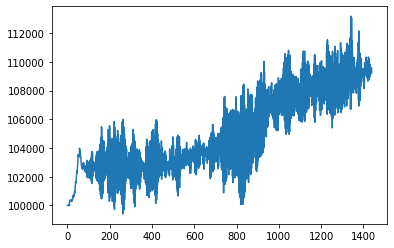

In [150]:
import matplotlib.pyplot as plt
plt.plot(bt.values)

In [13]:
df = pd.read_csv(r'C:\Users\Smart\2-year sample\allstocks_20190319\table_a.csv')

In [15]:
df.columns = ['date','minute','open','high','close','low','volume','a','b','c']

In [16]:
df

date  minute     open     high    close      low     volume  a  b  c
0    20190319     930  79.9340  80.0028  79.7668  79.8651  13943.200  1  0  0
1    20190319     931  79.8701  79.9094  79.7963  79.9045    747.285  1  0  0
2    20190319     932  79.9045  79.9143  79.8356  79.8701   9187.030  1  0  0
3    20190319     933  79.8947  79.9143  79.7963  79.8750   7918.170  1  0  0
4    20190319     934  79.8651  79.8848  79.8061  79.8342   1992.760  1  0  0
..        ...     ...      ...      ...      ...      ...        ... .. .. ..
393  20190319    1611  79.9474  79.9474  79.9474  79.9474   3761.840  1  0  0
394  20190319    1739  79.8651  79.8651  79.8651  79.8651   1762.980  1  0  0
395  20190319    1753  79.8651  79.8651  79.8651  79.8651  12871.600  1  0  0
396  20190319    1803  79.8651  79.8651  79.8651  79.8651    119.972  1  0  0
397  20190319    1835  79.8651  79.8651  79.8651  79.8651   5964.040  1  0  0

[398 rows x 10 columns]

In [18]:
dict1 = {}

In [19]:
dict1['appl']

KeyError: 'appl'